# **A Ballad of NLP (Musical Lyric Generation) 🎶🤖**
## Team Members: Arjun, Joyson, Kunal and Nawang 

##**Motivation**
This project was a cumulation of curiosity and hard work.We wanted to practise and showcase the skills which was taught to us throughout the course,AI-3. We inititally thought of creating a project that had many tasks such as **Lyrics Genration, Music Classification and a combination of both**, we realized that we had overscoped and therefore we decided to stick with one task and try to do it to the best of our abilities i.e **Lyrics Generation**.

The thought of us creating a model that is trained on lyrics of artists and then being able to create our lyrics from it was a great motivation for us as it was interesting as well as fascinating. 

The 1st part of our project is finding a dataset. We decided to make our own instead of a predefined one. The lyrics or dataset which has been collected was done so via 2 main steps:


1.   Collecting all the name of the songs along with the artists from Wikipedia. We have selected songs which have appeared in the Top-100 Billboard from 1959-2022.
2.   We then make use of the details to scrap lyrics from various websites such as **Genius.com** being one of the websites

We then clean up the lyrics of the songs and then use it to train our model.

The 2nd part of our project is nothing but creating our own model to train using the lyrics and also a SOTA Model to compare both.

The 3rd and final part was to scrape data for 2 artists.


1.   Panic! At The Disco
2.   Bruno Mars

The reason we picked these 2 artists are due to the stark difference of the 2 wrt the music that they create. One is a Rock Band and the other is Pop Singer. We then use our 2 models to fine tune the weights and then create the lyrics of the 2 artists. Sounds fun right! Let's dive into it then shall we?




## **Dataset**
We have 3 datasets to work with:


1.   BILLBOARD Dataset
2.   PANIC! AT THE DISCO Dataset
3.   BRUNO MARS Dataset

### **BILLBOARD Dataset**
This is a dataset which we have collected ourselves by scrapping Wikipedia and collecting the Top-100 Songs from 1959-2022.The details of the artists and songs are then used to scrape the lyrics from various websites such as Genius.com being one of them. We then preprocess and clean the dataset to attain the final dataset
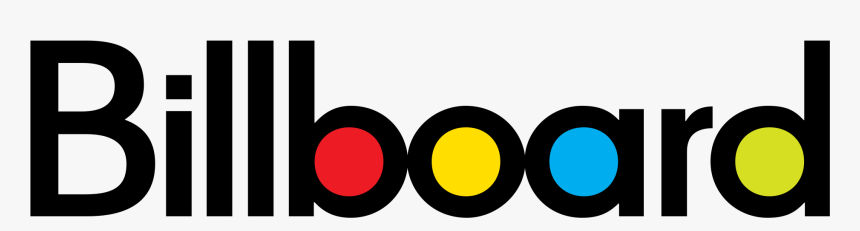

### **PANIC! AT THE DISCO Dataset**
This is a dataset comprised of only column and the column is the lyrics of each song that they have ever written. For this, we made use of Spotify API to collect the details of all the songs ever written by them. We then use the same functions in the BILLBOARD Dataset to retrieve the lyrics of each song

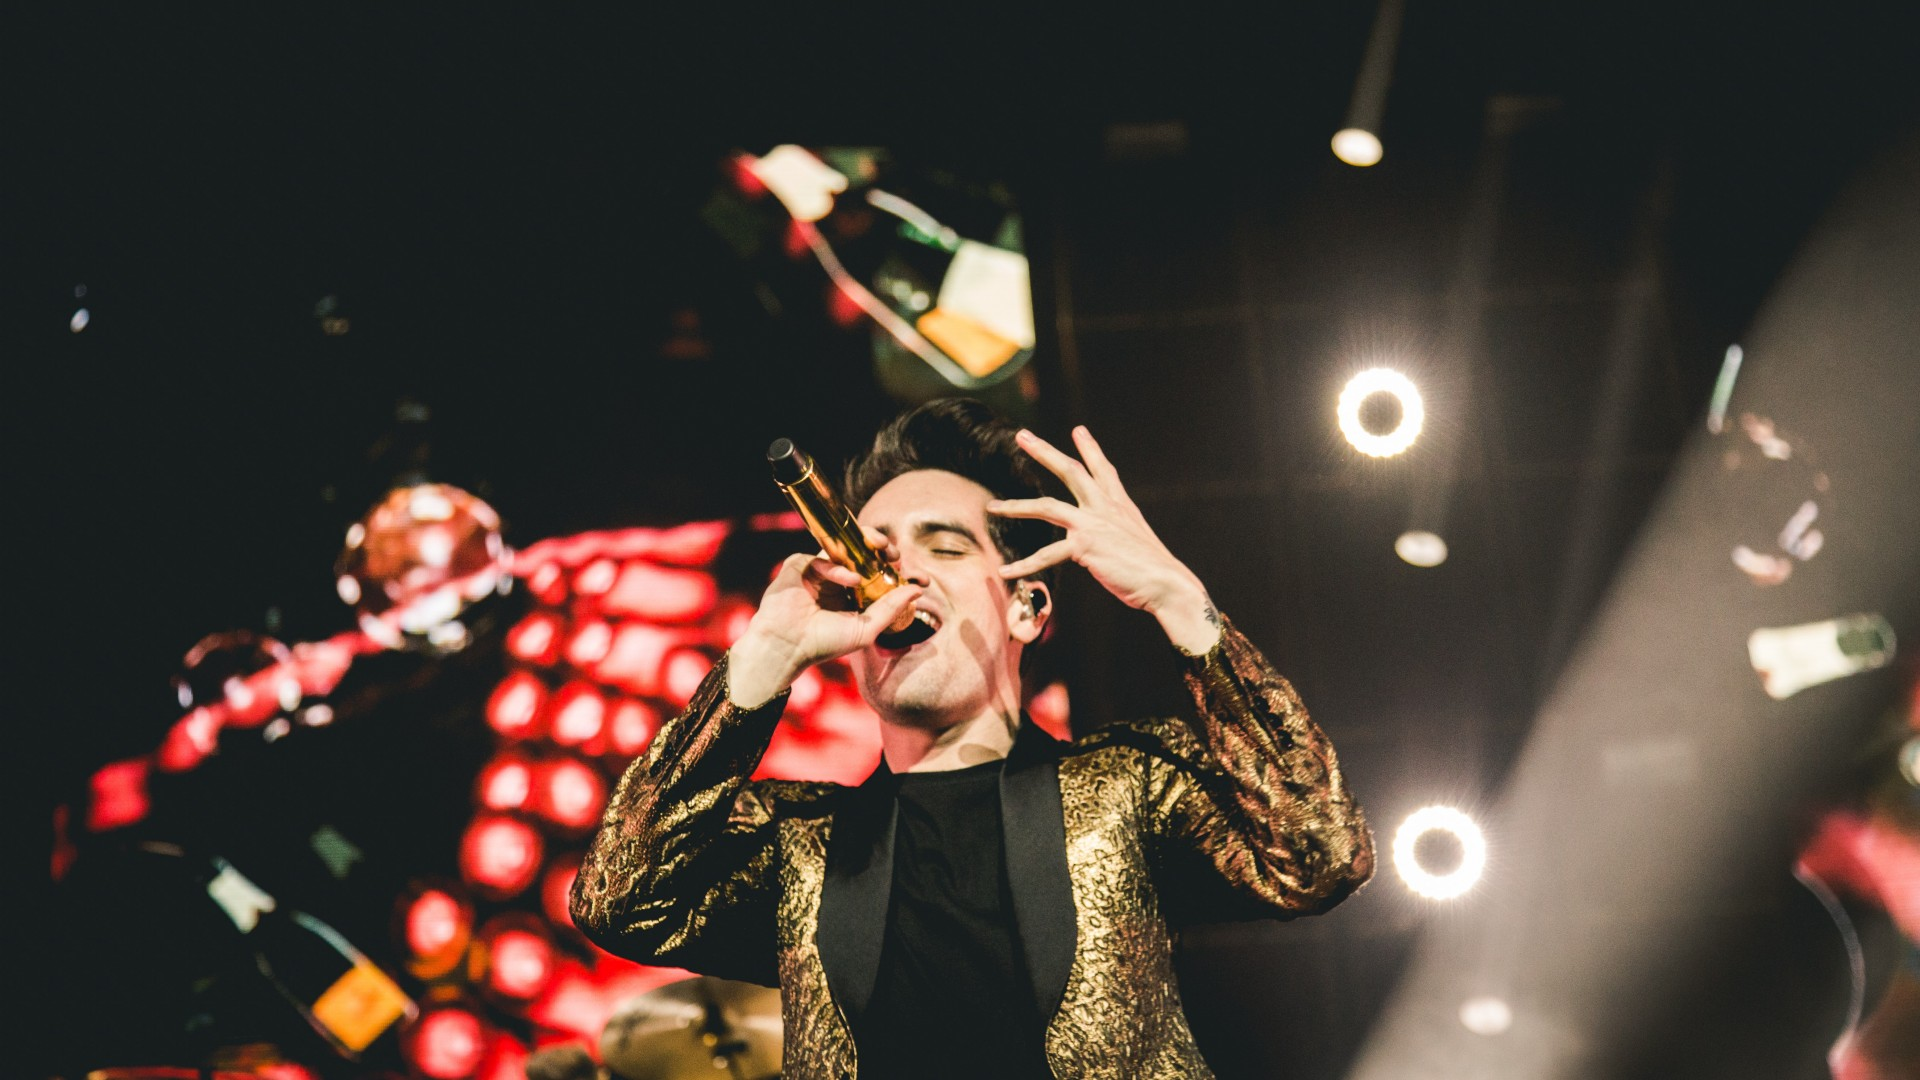
### **BRUNO MARS Dataset**
We collect the dataset similarly to how we did so for PANIC! AT THE DISCO Dataset
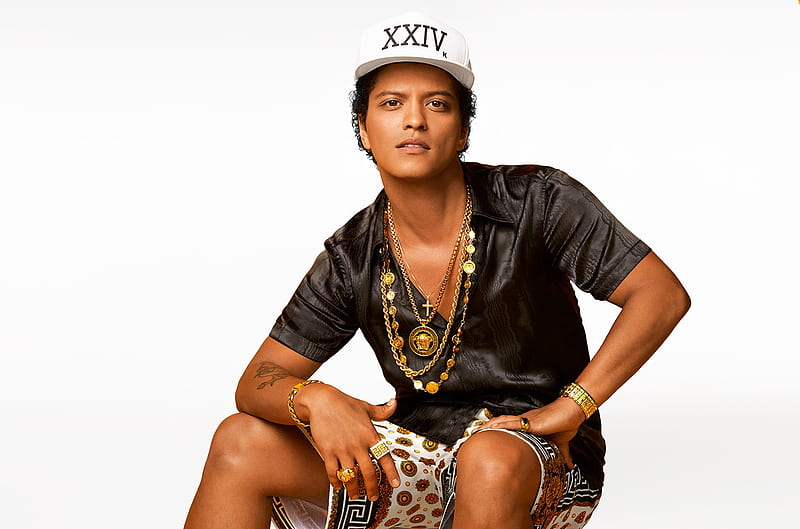

## Data Collection for BILLBOARD Dataset


In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.6 MB/s 


In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 140 kB 11.1 MB/s 
     |████████████████████████████████| 236 kB 39.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
#Importing all the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import warnings
import unidecode
import re

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials 

warnings.filterwarnings('ignore')

### Attaining URLs from Wikipedia
We make use of the various webpages that are created by Wikipedia which has the Top 100 songs  for each. We scrape the songs from 1959-2022

In [ ]:
url_base = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_{}'

htmls = dict()
for year in range(1959, 2023):
    url = url_base.format(year)
    html = requests.get(url=url).content
    htmls[year] = bs4.BeautifulSoup(html)

### Parsing each WebPage
We now attain the names of each of the songs from the pages scraped

In [ ]:
 # To create all the inidividual year dataframes
main_df = list()   

#Looping through each webpage and scrapping the data
for year, soup in list(htmls.items()):
    
    # Collecting the required details
    data = htmls[year]\
        .find('table', {'class':'wikitable sortable'})\
        .find_all('tr')
    rows = [details.contents for details in data]
    
    # We collecting information from the rows that are important
    rows = [row[1::2] for row in rows[1:]]
    
    #Parsing the filtered rows and attaining the 4 details below
    ranks = list()
    songs = list()
    # Primary Artist
    artists_base = list() 
    # Primary and Featured Artists
    artists_all = list() 
    for row in rows:
        ranks.append(str(row[0].contents[0]))
        artists_all.append(' '.join(row[2].findAll(text=True)))
        
        # Some Primary Artists are hyperlink and some are plain texts
        if not isinstance(row[2].contents[0], bs4.NavigableString):
            artists_base.append(row[2].contents[0].get('title'))
        else:
            artists_base.append(str(row[2].contents[0]))
        if len(row[1].contents) == 1:
            songs.append(str(row[1].contents[0]))
        else:
            songs.append(str(row[1].contents[1].findAll(text=True)[0]))
    
    # Removing additional quotes from the start and end of the songname
    songs = [song.strip("\"") for song in songs]
    
    # Combining the data so that we can combine in later
    data = dict(rank=ranks,
                song=songs,
                artist_base=artists_base,
                artist_all=artists_all,
                year=year)
    df = pd.DataFrame(data)
    main_df.append(df)

### Combining the data into 1 dataframe

In [ ]:
billboard = pd.concat(main_df, axis=0)
billboard[['song', 'artist_all', 'artist_base']]\
    = billboard[['song', 'artist_all', 'artist_base']].applymap(str.lower)
billboard = billboard.reset_index()
billboard.tail(5)

,index,rank,song,artist_base,artist_all,year
6396,95,96\n,flower shops,ernest (musician),ernest featuring morgan wallen \n,2022
6397,96,97\n,to the moon,jnr choi and sam tompkins\n,jnr choi and sam tompkins\n,2022
6398,97,98\n,unholy,sam smith,sam smith and kim petras \n,2022
6399,98,99\n,one mississippi,kane brown,kane brown \n,2022
6400,99,100\n,circles around this town,maren morris,maren morris \n,2022


## Data Cleaning and Preprocessing

In [ ]:
#We see that in some rows that we have \n attached to the various values.
#We want to remove that 
billboard[['artist_base', 'artist_all', "rank"]]\
    = billboard[['artist_base', 'artist_all',"rank"]].applymap(
        lambda x: re.sub(r'\(.*', '', x).strip()
    )
#We now see a better dataframe
billboard.tail()

,index,rank,song,artist_base,artist_all,year
6396,95,96,flower shops,ernest,ernest featuring morgan wallen,2022
6397,96,97,to the moon,jnr choi and sam tompkins,jnr choi and sam tompkins,2022
6398,97,98,unholy,sam smith,sam smith and kim petras,2022
6399,98,99,one mississippi,kane brown,kane brown,2022
6400,99,100,circles around this town,maren morris,maren morris,2022


We further modify the songs and name of artists to help in parsing of lyrics. For artists, we replace the ampersand & with and, and for both artists and songs, we strip and replace hyphens & etc

In [ ]:
def clean_song(x):
    x = x.replace('-', ' ')
    x = re.sub(r'[^\w\s]','', x)
    x = unidecode.unidecode(x)
    return x

billboard[['artist_base']] = billboard[['artist_base']].applymap(
        lambda x: x.replace('&', 'and'))

billboard[['song_clean', 'artist_clean']] = billboard[['song', 'artist_base']].applymap(clean_song)

billboard.sample(5)

,index,rank,song,artist_base,artist_all,year,song_clean,artist_clean
1404,3,4,let's get it on,marvin gaye,marvin gaye,1973,lets get it on,marvin gaye
5776,75,76,lost boy,ruth b,ruth b,2016,lost boy,ruth b
6311,10,11,wait for u,future,future featuring drake and tems,2022,wait for u,future
4521,20,21,dirt off your shoulder,jay-z,jay-z,2004,dirt off your shoulder,jay z
4257,56,57,one minute man,missy elliott,missy elliott featuring ludacris,2001,one minute man,missy elliott


### Obtaining Lyrics 
There exists may websites to scrape lyrics but then again it requires a fee and also the ones which are free can be unreliable at times. Thus we have decided to choose these 3 websites and scrape the lyrics sequentially until we get a match from any of these websites.
<br>
1. www.genius.com
2. www.songlyrics.com
3. www.lyricsmode.com

We have encountered a problem whereby a band name has 'The' at the start which the websites don't handle well. So in the first round we check with the word but then remove it in the 2nd round if we don't get a result

In [ ]:
#Lyrics List
lyrics_list = list()
#URL List
source_list = list()

for index, row in billboard.iterrows():
    artist = row['artist_clean']
    # if 1st round fails with 'the'
    artist_2 = re.sub(r'^the ', '', row['artist_clean']) 
    song = row['song_clean']
    source = None
    
    # generate URLs for each website.
    urls = list()
     genius_url = 'https://genius.com/{}-{}-lyrics'.format(
        artist.replace(' ', '-'), song.replace(' ', '-'))
    song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
        artist.replace(' ', '-'), song.replace(' ', '-'))
    mode_url = 'http://www.lyricsmode.com/lyrics/{}/{}/{}.html'.format(
        artist[0], artist.replace(' ', '_'), song.replace(' ', '_'))
    urls.extend([genius_url, song_url, mode_url, metro_url])
    if artist != artist_2:
        genius_url = 'https://genius.com/{}-{}-lyrics'.format(
            artist_2.replace(' ', '-'), song.replace(' ', '-'))
        song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
            artist_2.replace(' ', '-'), song.replace(' ', '-'))
        mode_url = 'http://www.lyricsmode.com/lyrics/{}/{}/{}.html'.format(
            artist_2[0], artist_2.replace(' ', '_'), song.replace(' ', '_'))
        urls.extend([genius_url, song_url, mode_url, metro_url])
        
    # Parsing Lyrics. lyrics are list of tokens
    for url in urls:
        try:
            # request HTML and parse
            html = requests.get(url=url).content
            soup = bs4.BeautifulSoup(html)
            
            # find lyrics and pre-process
            if 'genius.com' in url:
                print(url)
                lyrics = soup\
                    .find('div', {'class': 'lyrics'})\
                    .find('p')\
                    .findAll(text=True)
                if lyrics is None:
                    raise Exception
                source = 'genius.com'
                
            # for songlyrics.com, if no lyrics found, a message is displayed
            # where lyrics would be. thus, we check for this message instead.
            if 'songlyrics' in url:
                print(url)
                lyrics = soup\
                    .find('p', {'id': 'songLyricsDiv'})\
                    .findAll(text=True)
                if 'Sorry, we have no ' in lyrics[0]:
                    lyrics = None
                    raise Exception
                source = 'songlyrics.com'
            if 'lyricsmode' in url:
                print(url)
                lyrics = soup.find('p', {'id': 'lyrics_text'})
                if lyrics is None:
                    raise Exception
                lyrics = lyrics.text.split()
                source = 'lyricsmode.com'
            break
        except:
            print('error')
    lyrics_list.append(lyrics)
    source_list.append(source)

https://genius.com/johnny-horton-the-battle-of-new-orleans-lyrics
error
http://songlyrics.com/johnny-horton/the-battle-of-new-orleans-lyrics/
https://genius.com/bobby-darin-mack-the-knife-lyrics
error
http://songlyrics.com/bobby-darin/mack-the-knife-lyrics/
https://genius.com/lloyd-price-personality-lyrics
error
http://songlyrics.com/lloyd-price/personality-lyrics/
https://genius.com/frankie-avalon-venus-lyrics
error
http://songlyrics.com/frankie-avalon/venus-lyrics/
https://genius.com/paul-anka-lonely-boy-lyrics
error
http://songlyrics.com/paul-anka/lonely-boy-lyrics/
https://genius.com/bobby-darin-dream-lover-lyrics
error
http://songlyrics.com/bobby-darin/dream-lover-lyrics/
https://genius.com/the-browns-the-three-bells-lyrics
error
http://songlyrics.com/the-browns/the-three-bells-lyrics/
https://genius.com/the-fleetwoods-come-softly-to-me-lyrics
error
http://songlyrics.com/the-fleetwoods/come-softly-to-me-lyrics/
https://genius.com/wilbert-harrison-kansas-city-lyrics
error
http://so

http://songlyrics.com/lavern-baker/i-cried-a-tear-lyrics/
https://genius.com/the-platters-enchanted-lyrics
error
http://songlyrics.com/the-platters/enchanted-lyrics/
https://genius.com/the-skyliners-since-i-dont-have-you-lyrics
error
http://songlyrics.com/the-skyliners/since-i-dont-have-you-lyrics/
https://genius.com/ray-anthony-peter-gunn-theme-lyrics
error
http://songlyrics.com/ray-anthony/peter-gunn-theme-lyrics/
https://genius.com/the-chipmunks-the-chipmunk-song-christmas-dont-be-late-lyrics
error
http://songlyrics.com/the-chipmunks/the-chipmunk-song-christmas-dont-be-late-lyrics/
https://genius.com/fats-domino-i-want-to-walk-you-home-lyrics
error
http://songlyrics.com/fats-domino/i-want-to-walk-you-home-lyrics/
https://genius.com/the-fiestas-so-fine-lyrics
error
http://songlyrics.com/the-fiestas/so-fine-lyrics/
https://genius.com/frankie-avalon-bobby-sox-to-stockings-lyrics
error
http://songlyrics.com/frankie-avalon/bobby-sox-to-stockings-lyrics/
https://genius.com/wink-martindale

http://songlyrics.com/the-drifters/save-the-last-dance-for-me-lyrics/
https://genius.com/dinah-washington-baby-youve-got-what-it-takes-lyrics
error
http://songlyrics.com/dinah-washington/baby-youve-got-what-it-takes-lyrics/
https://genius.com/johnny-horton-sink-the-bismarck-lyrics
error
http://songlyrics.com/johnny-horton/sink-the-bismarck-lyrics/
https://genius.com/sam-cooke-chain-gang-lyrics
error
http://songlyrics.com/sam-cooke/chain-gang-lyrics/
https://genius.com/the-everly-brothers-let-it-be-me-lyrics
error
http://songlyrics.com/the-everly-brothers/let-it-be-me-lyrics/
https://genius.com/jimmy-jones-good-timin-lyrics
error
http://songlyrics.com/jimmy-jones/good-timin-lyrics/
https://genius.com/bobby-darin-beyond-the-sea-lyrics
error
http://songlyrics.com/bobby-darin/beyond-the-sea-lyrics/
https://genius.com/jimmy-clanton-go-jimmy-go-lyrics
error
http://songlyrics.com/jimmy-clanton/go-jimmy-go-lyrics/
https://genius.com/jackie-wilson-a-hrefwikinight_jackie_wilson_song-titlenight-j

http://songlyrics.com/johnny-tillotson/poetry-in-motion-lyrics/
https://genius.com/annette-funicello-o-dio-mio-lyrics
error
http://songlyrics.com/annette-funicello/o-dio-mio-lyrics/
https://genius.com/joe-jones-you-talk-too-much-lyrics
error
http://songlyrics.com/joe-jones/you-talk-too-much-lyrics/
https://genius.com/johnny-and-the-hurricanes-beatnik-fly-lyrics
error
http://songlyrics.com/johnny-and-the-hurricanes/beatnik-fly-lyrics/
https://genius.com/the-everly-brothers-when-will-i-be-loved-lyrics
error
http://songlyrics.com/the-everly-brothers/when-will-i-be-loved-lyrics/
https://genius.com/bob-luman-lets-think-about-living-lyrics
error
http://songlyrics.com/bob-luman/lets-think-about-living-lyrics/
https://genius.com/guy-mitchell-heartaches-by-the-number-lyrics
error
http://songlyrics.com/guy-mitchell/heartaches-by-the-number-lyrics/
https://genius.com/anita-bryant-my-little-corner-of-the-world-lyrics
error
http://songlyrics.com/anita-bryant/my-little-corner-of-the-world-lyrics/
ht

http://songlyrics.com/the-paris-sisters/i-love-how-you-love-me-lyrics/
https://genius.com/lee-dorsey-ya-ya-lyrics
error
http://songlyrics.com/lee-dorsey/ya-ya-lyrics/
https://genius.com/gary-us-bonds-school-is-out-lyrics
error
http://songlyrics.com/gary-us-bonds/school-is-out-lyrics/
error
http://www.lyricsmode.com/lyrics/g/gary_us_bonds/school_is_out.html
error
error
https://genius.com/bob-moore-mexico-lyrics
error
http://songlyrics.com/bob-moore/mexico-lyrics/
https://genius.com/ral-donner-you-dont-know-what-youve-got-until-you-lose-it-lyrics
error
http://songlyrics.com/ral-donner/you-dont-know-what-youve-got-until-you-lose-it-lyrics/
https://genius.com/the-everly-brothers-walk-right-back-lyrics
error
http://songlyrics.com/the-everly-brothers/walk-right-back-lyrics/
https://genius.com/the-lettermen-the-way-you-look-tonight-lyrics
error
http://songlyrics.com/the-lettermen/the-way-you-look-tonight-lyrics/
https://genius.com/pat-boone-moody-river-lyrics
error
http://songlyrics.com/pat-b

http://songlyrics.com/gene-chandler/duke-of-earl-lyrics/
https://genius.com/freddy-cannon-palisades-park-lyrics
error
http://songlyrics.com/freddy-cannon/palisades-park-lyrics/
https://genius.com/neil-sedaka-breaking-up-is-hard-to-do-lyrics
error
http://songlyrics.com/neil-sedaka/breaking-up-is-hard-to-do-lyrics/
https://genius.com/claude-king-wolverton-mountain-lyrics
error
http://songlyrics.com/claude-king/wolverton-mountain-lyrics/
https://genius.com/chubby-checker-slow-twistin-lyrics
error
http://songlyrics.com/chubby-checker/slow-twistin-lyrics/
https://genius.com/johnny-tillotson-it-keeps-right-on-a-hurtin-lyrics
error
http://songlyrics.com/johnny-tillotson/it-keeps-right-on-a-hurtin-lyrics/
https://genius.com/mary-wells-the-one-who-really-loves-you-lyrics
error
http://songlyrics.com/mary-wells/the-one-who-really-loves-you-lyrics/
https://genius.com/elvis-presley-good-luck-charm-lyrics
error
http://songlyrics.com/elvis-presley/good-luck-charm-lyrics/
https://genius.com/kenny-ball

http://songlyrics.com/dickey-lee/patches-lyrics/
https://genius.com/jimmy-clanton-venus-in-blue-jeans-lyrics
error
http://songlyrics.com/jimmy-clanton/venus-in-blue-jeans-lyrics/
https://genius.com/paul-anka-love-me-warm-and-tender-lyrics
error
http://songlyrics.com/paul-anka/love-me-warm-and-tender-lyrics/
https://genius.com/ricky-nelson-teen-age-idol-lyrics
error
http://songlyrics.com/ricky-nelson/teen-age-idol-lyrics/
https://genius.com/patsy-cline-shes-got-you-lyrics
error
http://songlyrics.com/patsy-cline/shes-got-you-lyrics/
https://genius.com/larry-finnegan-dear-one-lyrics
error
http://songlyrics.com/larry-finnegan/dear-one-lyrics/
https://genius.com/james-darren-her-royal-majesty-lyrics
error
http://songlyrics.com/james-darren/her-royal-majesty-lyrics/
https://genius.com/walter-brennan-old-rivers-lyrics
error
http://songlyrics.com/walter-brennan/old-rivers-lyrics/
https://genius.com/burl-ives-funny-way-of-laughin-lyrics
error
http://songlyrics.com/burl-ives/funny-way-of-laughin

http://songlyrics.com/barbara-lewis/hello-stranger-lyrics/
https://genius.com/the-ronettes-be-my-baby-lyrics
error
http://songlyrics.com/the-ronettes/be-my-baby-lyrics/
https://genius.com/the-orlons-south-street-lyrics
error
http://songlyrics.com/the-orlons/south-street-lyrics/
https://genius.com/henry-mancini-days-of-wine-and-roses-lyrics
error
http://songlyrics.com/henry-mancini/days-of-wine-and-roses-lyrics/
https://genius.com/major-lance-the-monkey-time-lyrics
error
http://songlyrics.com/major-lance/the-monkey-time-lyrics/
https://genius.com/the-four-seasons-candy-girl-lyrics
error
http://songlyrics.com/the-four-seasons/candy-girl-lyrics/
https://genius.com/the-fireballs-sugar-shack-lyrics
error
http://songlyrics.com/the-fireballs/sugar-shack-lyrics/
https://genius.com/bill-anderson-still-lyrics
error
http://songlyrics.com/bill-anderson/still-lyrics/
https://genius.com/bobby-vinton-blue-on-blue-lyrics
error
http://songlyrics.com/bobby-vinton/blue-on-blue-lyrics/
https://genius.com/

http://songlyrics.com/los-indios-tabajaras/maria-elena-lyrics/
https://genius.com/bobby-bare-detroit-city-lyrics
error
http://songlyrics.com/bobby-bare/detroit-city-lyrics/
https://genius.com/chubby-checker-twenty-miles-lyrics
error
http://songlyrics.com/chubby-checker/twenty-miles-lyrics/
https://genius.com/the-new-christy-minstrels-green-green-lyrics
error
http://songlyrics.com/the-new-christy-minstrels/green-green-lyrics/
https://genius.com/freddie-scott-hey-girl-lyrics
error
http://songlyrics.com/freddie-scott/hey-girl-lyrics/
https://genius.com/the-beatles-i-want-to-hold-your-hand-lyrics
error
http://songlyrics.com/the-beatles/i-want-to-hold-your-hand-lyrics/
https://genius.com/the-beatles-she-loves-you-lyrics
error
http://songlyrics.com/the-beatles/she-loves-you-lyrics/
https://genius.com/louis-armstrong-hello-dolly-lyrics
error
http://songlyrics.com/louis-armstrong/hello-dolly-lyrics/
https://genius.com/roy-orbison-oh-pretty-woman-lyrics
error
http://songlyrics.com/roy-orbison/o

http://songlyrics.com/the-beatles/cant-buy-me-love-lyrics/
https://genius.com/the-shangri-las-remember-walking-in-the-sand-lyrics
error
http://songlyrics.com/the-shangri-las/remember-walking-in-the-sand-lyrics/
https://genius.com/bobby-freeman-cmon-and-swim-lyrics
error
http://songlyrics.com/bobby-freeman/cmon-and-swim-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bobby_freeman/cmon_and_swim.html
error
error
https://genius.com/the-beatles-do-you-want-to-know-a-secret-lyrics
error
http://songlyrics.com/the-beatles/do-you-want-to-know-a-secret-lyrics/
https://genius.com/the-impressions-keep-on-pushing-lyrics
error
http://songlyrics.com/the-impressions/keep-on-pushing-lyrics/
https://genius.com/the-four-tops-baby-i-need-your-loving-lyrics
error
http://songlyrics.com/the-four-tops/baby-i-need-your-loving-lyrics/
https://genius.com/diane-renay-navy-blue-lyrics
error
http://songlyrics.com/diane-renay/navy-blue-lyrics/
https://genius.com/the-bachelors-diane-lyrics
error
http://songlyrics.c

http://songlyrics.com/we-five/you-were-on-my-mind-lyrics/
https://genius.com/the-righteous-brothers-youve-lost-that-lovin-feelin-lyrics
error
http://songlyrics.com/the-righteous-brothers/youve-lost-that-lovin-feelin-lyrics/
https://genius.com/petula-clark-downtown-lyrics
error
http://songlyrics.com/petula-clark/downtown-lyrics/
https://genius.com/the-beatles-help-lyrics
error
http://songlyrics.com/the-beatles/help-lyrics/
https://genius.com/hermans-hermits-cant-you-hear-my-heartbeat-lyrics
error
http://songlyrics.com/hermans-hermits/cant-you-hear-my-heartbeat-lyrics/
https://genius.com/elvis-presley-crying-in-the-chapel-lyrics
error
http://songlyrics.com/elvis-presley/crying-in-the-chapel-lyrics/
https://genius.com/the-temptations-my-girl-lyrics
error
http://songlyrics.com/the-temptations/my-girl-lyrics/
https://genius.com/the-beach-boys-help-me-rhonda-lyrics
error
http://songlyrics.com/the-beach-boys/help-me-rhonda-lyrics/
https://genius.com/roger-miller-king-of-the-road-lyrics
error


http://songlyrics.com/tom-jones/its-not-unusual-lyrics/
https://genius.com/sir-douglas-quintet-shes-about-a-mover-lyrics
error
http://songlyrics.com/sir-douglas-quintet/shes-about-a-mover-lyrics/
https://genius.com/sam-cooke-shake-lyrics
error
http://songlyrics.com/sam-cooke/shake-lyrics/
https://genius.com/hermans-hermits-wonderful-world-lyrics
error
http://songlyrics.com/hermans-hermits/wonderful-world-lyrics/
https://genius.com/martha-and-the-vandellas-nowhere-to-run-lyrics
error
http://songlyrics.com/martha-and-the-vandellas/nowhere-to-run-lyrics/
https://genius.com/the-yardbirds-heart-full-of-soul-lyrics
error
http://songlyrics.com/the-yardbirds/heart-full-of-soul-lyrics/
https://genius.com/the-searchers-love-potion-no-9-lyrics
error
http://songlyrics.com/the-searchers/love-potion-no-9-lyrics/
https://genius.com/dickey-lee-laurie-strange-things-happen-lyrics
error
http://songlyrics.com/dickey-lee/laurie-strange-things-happen-lyrics/
https://genius.com/sonny-and-cher-baby-dont-go-l

http://songlyrics.com/roger-williams/born-free-lyrics/
https://genius.com/the-left-banke-walk-away-renee-lyrics
error
http://songlyrics.com/the-left-banke/walk-away-renee-lyrics/
https://genius.com/the-capitols-cool-jerk-lyrics
error
http://songlyrics.com/the-capitols/cool-jerk-lyrics/
https://genius.com/carla-thomas-b-a-b-y-lyrics
error
http://songlyrics.com/carla-thomas/b-a-b-y-lyrics/
https://genius.com/tommy-james-and-the-shondells-hanky-panky-lyrics
error
http://songlyrics.com/tommy-james-and-the-shondells/hanky-panky-lyrics/
https://genius.com/percy-sledge-when-a-man-loves-a-woman-lyrics
error
http://songlyrics.com/percy-sledge/when-a-man-loves-a-woman-lyrics/
https://genius.com/the-outsiders-time-wont-let-me-lyrics
error
http://songlyrics.com/the-outsiders/time-wont-let-me-lyrics/
https://genius.com/the-beach-boys-good-vibrations-lyrics
error
http://songlyrics.com/the-beach-boys/good-vibrations-lyrics/
https://genius.com/the-rolling-stones-paint-it-black-lyrics
error
http://song

http://songlyrics.com/slim-harpo/baby-scratch-my-back-lyrics/
https://genius.com/gary-lewis-and-the-playboys-shes-just-my-style-lyrics
error
http://songlyrics.com/gary-lewis-and-the-playboys/shes-just-my-style-lyrics/
error
http://www.lyricsmode.com/lyrics/g/gary_lewis_and_the_playboys/shes_just_my_style.html
error
error
https://genius.com/chris-montez-the-more-i-see-you-lyrics
error
http://songlyrics.com/chris-montez/the-more-i-see-you-lyrics/
https://genius.com/bobby-fuller-i-fought-the-law-lyrics
error
http://songlyrics.com/bobby-fuller/i-fought-the-law-lyrics/
https://genius.com/the-beatles-yellow-submarine-lyrics
error
http://songlyrics.com/the-beatles/yellow-submarine-lyrics/
https://genius.com/paul-revere-and-the-raiders-hungry-lyrics
error
http://songlyrics.com/paul-revere-and-the-raiders/hungry-lyrics/
https://genius.com/herb-alpert-and-the-tijuana-brass-zorba-the-greek-lyrics
error
http://songlyrics.com/herb-alpert-and-the-tijuana-brass/zorba-the-greek-lyrics/
error
http://ww

http://songlyrics.com/dionne-warwick/alfie-lyrics/
https://genius.com/the-tremeloes-silence-is-golden-lyrics
error
http://songlyrics.com/the-tremeloes/silence-is-golden-lyrics/
https://genius.com/ed-ames-my-cup-runneth-over-lyrics
error
http://songlyrics.com/ed-ames/my-cup-runneth-over-lyrics/
https://genius.com/the-5th-dimension-up-up-and-away-lyrics
error
http://songlyrics.com/the-5th-dimension/up-up-and-away-lyrics/
https://genius.com/scott-mckenzie-san-francisco-be-sure-to-wear-flowers-in-your-hair-lyrics
error
http://songlyrics.com/scott-mckenzie/san-francisco-be-sure-to-wear-flowers-in-your-hair-lyrics/
https://genius.com/the-cowsills-the-rain-the-park--other-things-lyrics
error
http://songlyrics.com/the-cowsills/the-rain-the-park--other-things-lyrics/
https://genius.com/hermans-hermits-theres-a-kind-of-hush-lyrics
error
http://songlyrics.com/hermans-hermits/theres-a-kind-of-hush-lyrics/
https://genius.com/the-buckinghams-mercy-mercy-mercy-lyrics
error
http://songlyrics.com/the-b

http://songlyrics.com/the-who/i-can-see-for-miles-lyrics/
https://genius.com/petula-clark-dont-sleep-in-the-subway-lyrics
error
http://songlyrics.com/petula-clark/dont-sleep-in-the-subway-lyrics/
https://genius.com/neil-diamond-thank-the-lord-for-the-night-time-lyrics
error
http://songlyrics.com/neil-diamond/thank-the-lord-for-the-night-time-lyrics/
https://genius.com/the-beatles-hey-jude-lyrics
error
http://songlyrics.com/the-beatles/hey-jude-lyrics/
https://genius.com/paul-mauriat-love-is-blue-lyrics
error
http://songlyrics.com/paul-mauriat/love-is-blue-lyrics/
https://genius.com/bobby-goldsboro-honey-lyrics
error
http://songlyrics.com/bobby-goldsboro/honey-lyrics/
https://genius.com/otis-redding-sittin-on-the-dock-of-the-bay-lyrics
error
http://songlyrics.com/otis-redding/sittin-on-the-dock-of-the-bay-lyrics/
https://genius.com/the-rascals-people-got-to-be-free-lyrics
error
http://songlyrics.com/the-rascals/people-got-to-be-free-lyrics/
https://genius.com/cream-sunshine-of-your-love

http://songlyrics.com/james-brown/i-got-the-feelin-lyrics/
https://genius.com/bee-gees-ive-gotta-get-a-message-to-you-lyrics
error
http://songlyrics.com/bee-gees/ive-gotta-get-a-message-to-you-lyrics/
https://genius.com/the-beatles-lady-madonna-lyrics
error
http://songlyrics.com/the-beatles/lady-madonna-lyrics/
https://genius.com/donovan-hurdy-gurdy-man-lyrics
error
http://songlyrics.com/donovan/hurdy-gurdy-man-lyrics/
https://genius.com/steppenwolf-magic-carpet-ride-lyrics
error
http://songlyrics.com/steppenwolf/magic-carpet-ride-lyrics/
https://genius.com/the-fireballs-bottle-of-wine-lyrics
error
http://songlyrics.com/the-fireballs/bottle-of-wine-lyrics/
https://genius.com/the-dells-stay-in-my-corner-lyrics
error
http://songlyrics.com/the-dells/stay-in-my-corner-lyrics/
https://genius.com/willie-mitchell-soul-serenade-lyrics
error
http://songlyrics.com/willie-mitchell/soul-serenade-lyrics/
https://genius.com/tom-jones-delilah-lyrics
error
http://songlyrics.com/tom-jones/delilah-lyric

http://songlyrics.com/elvis-presley/suspicious-minds-lyrics/
https://genius.com/creedence-clearwater-revival-proud-mary-lyrics
error
http://songlyrics.com/creedence-clearwater-revival/proud-mary-lyrics/
https://genius.com/junior-walker-what-does-it-take-to-win-your-love-lyrics
error
http://songlyrics.com/junior-walker/what-does-it-take-to-win-your-love-lyrics/
https://genius.com/the-isley-brothers-its-your-thing-lyrics
error
http://songlyrics.com/the-isley-brothers/its-your-thing-lyrics/
https://genius.com/neil-diamond-sweet-caroline-lyrics
error
http://songlyrics.com/neil-diamond/sweet-caroline-lyrics/
https://genius.com/oliver-jean-lyrics
error
http://songlyrics.com/oliver/jean-lyrics/
https://genius.com/creedence-clearwater-revival-bad-moon-rising-lyrics
error
http://songlyrics.com/creedence-clearwater-revival/bad-moon-rising-lyrics/
https://genius.com/the-beatles-get-back-lyrics
error
http://songlyrics.com/the-beatles/get-back-lyrics/
https://genius.com/zager-and-evans-in-the-year-

http://songlyrics.com/tony-joe-white/polk-salad-annie-lyrics/
https://genius.com/kenny-rogers-and-the-first-edition-ruby-dont-take-your-love-to-town-lyrics
error
http://songlyrics.com/kenny-rogers-and-the-first-edition/ruby-dont-take-your-love-to-town-lyrics/
error
http://www.lyricsmode.com/lyrics/k/kenny_rogers_and_the_first_edition/ruby_dont_take_your_love_to_town.html
error
error
https://genius.com/joe-south-games-people-play-lyrics
error
http://songlyrics.com/joe-south/games-people-play-lyrics/
https://genius.com/the-turtles-you-showed-me-lyrics
error
http://songlyrics.com/the-turtles/you-showed-me-lyrics/
https://genius.com/the-cuff-links-tracy-lyrics
error
http://songlyrics.com/the-cuff-links/tracy-lyrics/
https://genius.com/the-dells-oh-what-a-night-lyrics
error
http://songlyrics.com/the-dells/oh-what-a-night-lyrics/
https://genius.com/the-beatles-something-lyrics
error
http://songlyrics.com/the-beatles/something-lyrics/
https://genius.com/gary-puckett-and-the-union-gap-this-gir

http://songlyrics.com/brook-benton/rainy-night-in-georgia-lyrics/
https://genius.com/kenny-rogers-somethings-burning-lyrics
error
http://songlyrics.com/kenny-rogers/somethings-burning-lyrics/
https://genius.com/chairmen-of-the-board-give-me-just-a-little-more-time-lyrics
error
http://songlyrics.com/chairmen-of-the-board/give-me-just-a-little-more-time-lyrics/
https://genius.com/edison-lighthouse-love-grows-where-my-rosemary-goes-lyrics
error
http://songlyrics.com/edison-lighthouse/love-grows-where-my-rosemary-goes-lyrics/
https://genius.com/the-beatles-the-long-and-winding-road-lyrics
error
http://songlyrics.com/the-beatles/the-long-and-winding-road-lyrics/
https://genius.com/anne-murray-snowbird-lyrics
error
http://songlyrics.com/anne-murray/snowbird-lyrics/
https://genius.com/marmalade-reflections-of-my-life-lyrics
error
http://songlyrics.com/marmalade/reflections-of-my-life-lyrics/
https://genius.com/eddie-holman-hey-there-lonely-girl-lyrics
error
http://songlyrics.com/eddie-holman/

https://genius.com/crosby-stills-nash-and-young-woodstock-lyrics
error
http://songlyrics.com/crosby-stills-nash-and-young/woodstock-lyrics/
https://genius.com/dionne-warwick-ill-never-fall-in-love-again-lyrics
error
http://songlyrics.com/dionne-warwick/ill-never-fall-in-love-again-lyrics/
https://genius.com/the-new-seekers-look-what-theyve-done-to-my-song-ma-lyrics
error
http://songlyrics.com/the-new-seekers/look-what-theyve-done-to-my-song-ma-lyrics/
https://genius.com/joe-south-walk-a-mile-in-my-shoes-lyrics
error
http://songlyrics.com/joe-south/walk-a-mile-in-my-shoes-lyrics/
https://genius.com/bb-king-the-thrill-is-gone-lyrics
error
http://songlyrics.com/bb-king/the-thrill-is-gone-lyrics/
https://genius.com/glen-campbell-its-only-make-believe-lyrics
error
http://songlyrics.com/glen-campbell/its-only-make-believe-lyrics/
https://genius.com/aretha-franklin-call-me-lyrics
error
http://songlyrics.com/aretha-franklin/call-me-lyrics/
https://genius.com/three-dog-night-joy-to-the-world-ly

http://songlyrics.com/helen-reddy/i-dont-know-how-to-love-him-lyrics/
https://genius.com/the-osmonds-yo-yo-lyrics
error
http://songlyrics.com/the-osmonds/yo-yo-lyrics/
https://genius.com/aretha-franklin-bridge-over-troubled-water-lyrics
error
http://songlyrics.com/aretha-franklin/bridge-over-troubled-water-lyrics/
https://genius.com/the-partridge-family-doesnt-somebody-want-to-be-wanted-lyrics
error
http://songlyrics.com/the-partridge-family/doesnt-somebody-want-to-be-wanted-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_partridge_family/doesnt_somebody_want_to_be_wanted.html
error
error
https://genius.com/partridge-family-doesnt-somebody-want-to-be-wanted-lyrics
error
http://songlyrics.com/partridge-family/doesnt-somebody-want-to-be-wanted-lyrics/
error
http://www.lyricsmode.com/lyrics/p/partridge_family/doesnt_somebody_want_to_be_wanted.html
error
error
https://genius.com/tommy-james-draggin-the-line-lyrics
error
http://songlyrics.com/tommy-james/draggin-the-line-lyrics/
https:

http://songlyrics.com/joe-tex/i-gotcha-lyrics/
https://genius.com/bill-withers-lean-on-me-lyrics
error
http://songlyrics.com/bill-withers/lean-on-me-lyrics/
https://genius.com/mac-davis-baby-dont-get-hooked-on-me-lyrics
error
http://songlyrics.com/mac-davis/baby-dont-get-hooked-on-me-lyrics/
https://genius.com/melanie-safka-brand-new-key-lyrics
error
http://songlyrics.com/melanie-safka/brand-new-key-lyrics/
https://genius.com/wayne-newton-daddy-dont-you-walk-so-fast-lyrics
error
http://songlyrics.com/wayne-newton/daddy-dont-you-walk-so-fast-lyrics/
error
http://www.lyricsmode.com/lyrics/w/wayne_newton/daddy_dont_you_walk_so_fast.html
error
error
https://genius.com/al-green-lets-stay-together-lyrics
error
http://songlyrics.com/al-green/lets-stay-together-lyrics/
https://genius.com/looking-glass-brandy-youre-a-fine-girl-lyrics
error
http://songlyrics.com/looking-glass/brandy-youre-a-fine-girl-lyrics/
https://genius.com/the-chi-lites-oh-girl-lyrics
error
http://songlyrics.com/the-chi-lite

http://songlyrics.com/harry-nilsson/coconut-lyrics/
https://genius.com/donny-osmond-puppy-love-lyrics
error
http://songlyrics.com/donny-osmond/puppy-love-lyrics/
https://genius.com/jim-croce-you-dont-mess-around-with-jim-lyrics
error
http://songlyrics.com/jim-croce/you-dont-mess-around-with-jim-lyrics/
https://genius.com/commander-cody-and-his-lost-planet-airmen-hot-rod-lincoln-lyrics
error
http://songlyrics.com/commander-cody-and-his-lost-planet-airmen/hot-rod-lincoln-lyrics/
https://genius.com/sonny-and-cher-a-cowboys-work-is-never-done-lyrics
error
http://songlyrics.com/sonny-and-cher/a-cowboys-work-is-never-done-lyrics/
error
http://www.lyricsmode.com/lyrics/s/sonny_and_cher/a_cowboys_work_is_never_done.html
error
error
https://genius.com/apollo-100-joy-lyrics
error
http://songlyrics.com/apollo-100/joy-lyrics/
https://genius.com/carly-simon-anticipation-lyrics
error
http://songlyrics.com/carly-simon/anticipation-lyrics/
https://genius.com/three-dog-night-never-been-to-spain-lyrics


http://songlyrics.com/dr-john/right-place-wrong-time-lyrics/
https://genius.com/skylark-wildflower-lyrics
error
http://songlyrics.com/skylark/wildflower-lyrics/
https://genius.com/stevie-wonder-superstition-lyrics
error
http://songlyrics.com/stevie-wonder/superstition-lyrics/
https://genius.com/paul-simon-loves-me-like-a-rock-lyrics
error
http://songlyrics.com/paul-simon/loves-me-like-a-rock-lyrics/
https://genius.com/maureen-mcgovern-the-morning-after-lyrics
error
http://songlyrics.com/maureen-mcgovern/the-morning-after-lyrics/
https://genius.com/john-denver-rocky-mountain-high-lyrics
error
http://songlyrics.com/john-denver/rocky-mountain-high-lyrics/
https://genius.com/stealers-wheel-stuck-in-the-middle-with-you-lyrics
error
http://songlyrics.com/stealers-wheel/stuck-in-the-middle-with-you-lyrics/
https://genius.com/three-dog-night-shambala-lyrics
error
http://songlyrics.com/three-dog-night/shambala-lyrics/
https://genius.com/the-ojays-love-train-lyrics
error
http://songlyrics.com/th

http://songlyrics.com/johnny-rivers/rockin-pneumonia-and-the-boogie-woogie-flu-lyrics/
https://genius.com/the-allman-brothers-band-ramblin-man-lyrics
error
http://songlyrics.com/the-allman-brothers-band/ramblin-man-lyrics/
https://genius.com/the-temptations-masterpiece-lyrics
error
http://songlyrics.com/the-temptations/masterpiece-lyrics/
https://genius.com/helen-reddy-peaceful-lyrics
error
http://songlyrics.com/helen-reddy/peaceful-lyrics/
https://genius.com/the-spinners-one-of-a-kind-love-affair-lyrics
error
http://songlyrics.com/the-spinners/one-of-a-kind-love-affair-lyrics/
https://genius.com/donna-fargo-funny-face-lyrics
error
http://songlyrics.com/donna-fargo/funny-face-lyrics/
https://genius.com/ohio-players-funky-worm-lyrics
error
http://songlyrics.com/ohio-players/funky-worm-lyrics/
https://genius.com/the-rolling-stones-angie-lyrics
error
http://songlyrics.com/the-rolling-stones/angie-lyrics/
https://genius.com/john-fogerty-jambalaya-on-the-bayou-lyrics
error
http://songlyrics

http://songlyrics.com/gladys-knight-and-the-pips/ive-got-to-use-my-imagination-lyrics/
error
http://www.lyricsmode.com/lyrics/g/gladys_knight_and_the_pips/ive_got_to_use_my_imagination.html
error
error
https://genius.com/three-dog-night-the-show-must-go-on-lyrics
error
http://songlyrics.com/three-dog-night/the-show-must-go-on-lyrics/
https://genius.com/the-hues-corporation-rock-the-boat-lyrics
error
http://songlyrics.com/the-hues-corporation/rock-the-boat-lyrics/
https://genius.com/brownsville-station-smokin-in-the-boys-room-lyrics
error
http://songlyrics.com/brownsville-station/smokin-in-the-boys-room-lyrics/
https://genius.com/stevie-wonder-living-for-the-city-lyrics
error
http://songlyrics.com/stevie-wonder/living-for-the-city-lyrics/
https://genius.com/dionne-warwick-then-came-you-lyrics
error
http://songlyrics.com/dionne-warwick/then-came-you-lyrics/
https://genius.com/paper-lace-the-night-chicago-died-lyrics
error
http://songlyrics.com/paper-lace/the-night-chicago-died-lyrics/
ht

http://songlyrics.com/fancy/wild-thing-lyrics/
https://genius.com/the-spinners-mighty-love-lyrics
error
http://songlyrics.com/the-spinners/mighty-love-lyrics/
https://genius.com/captain-and-tennille-love-will-keep-us-together-lyrics
error
http://songlyrics.com/captain-and-tennille/love-will-keep-us-together-lyrics/
https://genius.com/glen-campbell-rhinestone-cowboy-lyrics
error
http://songlyrics.com/glen-campbell/rhinestone-cowboy-lyrics/
https://genius.com/elton-john-philadelphia-freedom-lyrics
error
http://songlyrics.com/elton-john/philadelphia-freedom-lyrics/
https://genius.com/freddy-fender-before-the-next-teardrop-falls-lyrics
error
http://songlyrics.com/freddy-fender/before-the-next-teardrop-falls-lyrics/
https://genius.com/frankie-valli-my-eyes-adored-you-lyrics
error
http://songlyrics.com/frankie-valli/my-eyes-adored-you-lyrics/
https://genius.com/grand-funk-railroad-some-kind-of-wonderful-lyrics
error
http://songlyrics.com/grand-funk-railroad/some-kind-of-wonderful-lyrics/
htt

http://songlyrics.com/styx/lady-lyrics/
https://genius.com/grand-funk-railroad-bad-time-lyrics
error
http://songlyrics.com/grand-funk-railroad/bad-time-lyrics/
https://genius.com/alice-cooper-only-women-bleed-lyrics
error
http://songlyrics.com/alice-cooper/only-women-bleed-lyrics/
https://genius.com/carol-douglas-doctors-orders-lyrics
error
http://songlyrics.com/carol-douglas/doctors-orders-lyrics/
https://genius.com/kc-and-the-sunshine-band-get-down-tonight-lyrics
error
http://songlyrics.com/kc-and-the-sunshine-band/get-down-tonight-lyrics/
https://genius.com/paul-anka-one-man-womanone-woman-man-lyrics
error
http://songlyrics.com/paul-anka/one-man-womanone-woman-man-lyrics/
error
http://www.lyricsmode.com/lyrics/p/paul_anka/one_man_womanone_woman_man.html
error
error
https://genius.com/joe-cocker-you-are-so-beautiful-lyrics
error
http://songlyrics.com/joe-cocker/you-are-so-beautiful-lyrics/
https://genius.com/bad-company-feel-like-makin-love-lyrics
error
http://songlyrics.com/bad-comp

http://songlyrics.com/the-sylvers/boogie-fever-lyrics/
https://genius.com/england-dan-and-john-ford-coley-id-really-love-to-see-you-tonight-lyrics
error
http://songlyrics.com/england-dan-and-john-ford-coley/id-really-love-to-see-you-tonight-lyrics/
error
http://www.lyricsmode.com/lyrics/e/england_dan_and_john_ford_coley/id_really_love_to_see_you_tonight.html
error
error
https://genius.com/hot-chocolate-you-sexy-thing-lyrics
error
http://songlyrics.com/hot-chocolate/you-sexy-thing-lyrics/
https://genius.com/nazareth-love-hurts-lyrics
error
http://songlyrics.com/nazareth/love-hurts-lyrics/
https://genius.com/silver-convention-get-up-and-boogie-lyrics
error
http://songlyrics.com/silver-convention/get-up-and-boogie-lyrics/
https://genius.com/eagles-take-it-to-the-limit-lyrics
error
http://songlyrics.com/eagles/take-it-to-the-limit-lyrics/
https://genius.com/kc-and-the-sunshine-band-shake-shake-shake-shake-your-booty-lyrics
error
http://songlyrics.com/kc-and-the-sunshine-band/shake-shake-sh

http://songlyrics.com/earth-wind-and-fire/getaway-lyrics/
https://genius.com/hall-and-oates-shes-gone-lyrics
error
http://songlyrics.com/hall-and-oates/shes-gone-lyrics/
https://genius.com/orleans-still-the-one-lyrics
error
http://songlyrics.com/orleans/still-the-one-lyrics/
https://genius.com/queen-youre-my-best-friend-lyrics
error
http://songlyrics.com/queen/youre-my-best-friend-lyrics/
https://genius.com/jefferson-starship-with-your-love-lyrics
error
http://songlyrics.com/jefferson-starship/with-your-love-lyrics/
https://genius.com/foghat-slow-ride-lyrics
error
http://songlyrics.com/foghat/slow-ride-lyrics/
https://genius.com/ohio-players-whod-she-coo-lyrics
error
http://songlyrics.com/ohio-players/whod-she-coo-lyrics/
error
http://www.lyricsmode.com/lyrics/o/ohio_players/whod_she_coo.html
error
error
https://genius.com/thin-lizzy-the-boys-are-back-in-town-lyrics
error
http://songlyrics.com/thin-lizzy/the-boys-are-back-in-town-lyrics/
https://genius.com/david-ruffin-walk-away-from-l

http://songlyrics.com/10cc/the-things-we-do-for-love-lyrics/
https://genius.com/shaun-cassidy-da-doo-ron-ron-lyrics
error
http://songlyrics.com/shaun-cassidy/da-doo-ron-ron-lyrics/
https://genius.com/james-taylor-handy-man-lyrics
error
http://songlyrics.com/james-taylor/handy-man-lyrics/
https://genius.com/crosby-stills-and-nash-just-a-song-before-i-go-lyrics
error
http://songlyrics.com/crosby-stills-and-nash/just-a-song-before-i-go-lyrics/
https://genius.com/alice-cooper-you-and-me-lyrics
error
http://songlyrics.com/alice-cooper/you-and-me-lyrics/
https://genius.com/johnny-rivers-swayin-to-the-music-slow-dancing-lyrics
error
http://songlyrics.com/johnny-rivers/swayin-to-the-music-slow-dancing-lyrics/
https://genius.com/andrew-gold-lonely-boy-lyrics
error
http://songlyrics.com/andrew-gold/lonely-boy-lyrics/
https://genius.com/stevie-wonder-i-wish-lyrics
error
http://songlyrics.com/stevie-wonder/i-wish-lyrics/
https://genius.com/fleetwood-mac-dont-stop-lyrics
error
http://songlyrics.com

https://genius.com/exile-kiss-you-all-over-lyrics
error
http://songlyrics.com/exile/kiss-you-all-over-lyrics/
https://genius.com/bee-gees-how-deep-is-your-love-lyrics
error
http://songlyrics.com/bee-gees/how-deep-is-your-love-lyrics/
https://genius.com/player-baby-come-back-lyrics
error
http://songlyrics.com/player/baby-come-back-lyrics/
https://genius.com/andy-gibb-love-is-thicker-than-water-lyrics
error
http://songlyrics.com/andy-gibb/love-is-thicker-than-water-lyrics/
https://genius.com/a-taste-of-honey-boogie-oogie-oogie-lyrics
error
http://songlyrics.com/a-taste-of-honey/boogie-oogie-oogie-lyrics/
https://genius.com/commodores-three-times-a-lady-lyrics
error
http://songlyrics.com/commodores/three-times-a-lady-lyrics/
https://genius.com/frankie-valli-grease-lyrics
error
http://songlyrics.com/frankie-valli/grease-lyrics/
https://genius.com/paul-davis-i-go-crazy-lyrics
error
http://songlyrics.com/paul-davis/i-go-crazy-lyrics/
https://genius.com/john-travolta-youre-the-one-that-i-want

https://genius.com/john-travolta-summer-nights-lyrics
error
http://songlyrics.com/john-travolta/summer-nights-lyrics/
https://genius.com/lynyrd-skynyrd-whats-your-name-lyrics
error
http://songlyrics.com/lynyrd-skynyrd/whats-your-name-lyrics/
https://genius.com/crystal-gayle-dont-it-make-my-brown-eyes-blue-lyrics
error
http://songlyrics.com/crystal-gayle/dont-it-make-my-brown-eyes-blue-lyrics/
https://genius.com/patti-smith-because-the-night-lyrics
error
http://songlyrics.com/patti-smith/because-the-night-lyrics/
https://genius.com/robert-palmer-every-kinda-people-lyrics
error
http://songlyrics.com/robert-palmer/every-kinda-people-lyrics/
https://genius.com/barry-manilow-copacabana-lyrics
error
http://songlyrics.com/barry-manilow/copacabana-lyrics/
https://genius.com/heatwave-always-and-forever-lyrics
error
http://songlyrics.com/heatwave/always-and-forever-lyrics/
https://genius.com/rick-james-you-and-i-lyrics
error
http://songlyrics.com/rick-james/you-and-i-lyrics/
https://genius.com/e

http://songlyrics.com/cheap-trick/i-want-you-to-want-me-lyrics/
https://genius.com/barbra-streisand-the-main-eventfight-lyrics
error
http://songlyrics.com/barbra-streisand/the-main-eventfight-lyrics/
https://genius.com/elton-john-mama-cant-buy-you-love-lyrics
error
http://songlyrics.com/elton-john/mama-cant-buy-you-love-lyrics/
https://genius.com/leif-garrett-i-was-made-for-dancin-lyrics
error
http://songlyrics.com/leif-garrett/i-was-made-for-dancin-lyrics/
https://genius.com/earth-wind-and-fire-after-the-love-has-gone-lyrics
error
http://songlyrics.com/earth-wind-and-fire/after-the-love-has-gone-lyrics/
https://genius.com/donna-summer-heaven-knows-lyrics
error
http://songlyrics.com/donna-summer/heaven-knows-lyrics/
https://genius.com/kenny-rogers-the-gambler-lyrics
error
http://songlyrics.com/kenny-rogers/the-gambler-lyrics/
https://genius.com/nicolette-larson-lotta-love-lyrics
error
http://songlyrics.com/nicolette-larson/lotta-love-lyrics/
https://genius.com/little-river-band-lady-ly

https://genius.com/nigel-olsson-dancin-shoes-lyrics
error
http://songlyrics.com/nigel-olsson/dancin-shoes-lyrics/
error
http://www.lyricsmode.com/lyrics/n/nigel_olsson/dancin_shoes.html
error
error
https://genius.com/diana-ross-the-boss-lyrics
error
http://songlyrics.com/diana-ross/the-boss-lyrics/
https://genius.com/commodores-sail-on-lyrics
error
http://songlyrics.com/commodores/sail-on-lyrics/
https://genius.com/gq-i-do-love-you-lyrics
error
http://songlyrics.com/gq/i-do-love-you-lyrics/
https://genius.com/firefall-strange-way-lyrics
error
http://songlyrics.com/firefall/strange-way-lyrics/
https://genius.com/blondie-call-me-lyrics
error
http://songlyrics.com/blondie/call-me-lyrics/
https://genius.com/pink-floyd-another-brick-in-the-wall-part-ii-lyrics
error
http://songlyrics.com/pink-floyd/another-brick-in-the-wall-part-ii-lyrics/
https://genius.com/olivia-newton-john-magic-lyrics
error
http://songlyrics.com/olivia-newton-john/magic-lyrics/
https://genius.com/michael-jackson-rock-wi

https://genius.com/eagles-i-cant-tell-you-why-lyrics
error
http://songlyrics.com/eagles/i-cant-tell-you-why-lyrics/
https://genius.com/isaac-hayes-dont-let-go-lyrics
error
http://songlyrics.com/isaac-hayes/dont-let-go-lyrics/
error
http://www.lyricsmode.com/lyrics/i/isaac_hayes/dont_let_go.html
error
error
https://genius.com/tom-petty-and-the-heartbreakers-dont-do-me-like-that-lyrics
error
http://songlyrics.com/tom-petty-and-the-heartbreakers/dont-do-me-like-that-lyrics/
https://genius.com/michael-jackson-shes-out-of-my-life-lyrics
error
http://songlyrics.com/michael-jackson/shes-out-of-my-life-lyrics/
https://genius.com/irene-cara-fame-lyrics
error
http://songlyrics.com/irene-cara/fame-lyrics/
https://genius.com/bob-seger-and-the-silver-bullet-band-fire-lake-lyrics
error
http://songlyrics.com/bob-seger-and-the-silver-bullet-band/fire-lake-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bob_seger_and_the_silver_bullet_band/fire_lake.html
error
error
https://genius.com/linda-ronstadt-h

https://genius.com/neil-diamond-love-on-the-rocks-lyrics
error
http://songlyrics.com/neil-diamond/love-on-the-rocks-lyrics/
https://genius.com/air-supply-every-woman-in-the-world-lyrics
error
http://songlyrics.com/air-supply/every-woman-in-the-world-lyrics/
https://genius.com/air-supply-the-one-that-you-love-lyrics
error
http://songlyrics.com/air-supply/the-one-that-you-love-lyrics/
https://genius.com/barbra-streisand-guilty-lyrics
error
http://songlyrics.com/barbra-streisand/guilty-lyrics/
https://genius.com/styx-the-best-of-times-lyrics
error
http://songlyrics.com/styx/the-best-of-times-lyrics/
https://genius.com/the-oak-ridge-boys-elvira-lyrics
error
http://songlyrics.com/the-oak-ridge-boys/elvira-lyrics/
https://genius.com/reo-speedwagon-take-it-on-the-run-lyrics
error
http://songlyrics.com/reo-speedwagon/take-it-on-the-run-lyrics/
https://genius.com/ronnie-milsap-theres-no-gettin-over-me-lyrics
error
http://songlyrics.com/ronnie-milsap/theres-no-gettin-over-me-lyrics/
https://geni

http://songlyrics.com/john-lennon/watching-the-wheels-lyrics/
https://genius.com/heart-tell-it-like-it-is-lyrics
error
http://songlyrics.com/heart/tell-it-like-it-is-lyrics/
https://genius.com/ronnie-milsap-smoky-mountain-rain-lyrics
error
http://songlyrics.com/ronnie-milsap/smoky-mountain-rain-lyrics/
https://genius.com/barry-manilow-i-made-it-through-the-rain-lyrics
error
http://songlyrics.com/barry-manilow/i-made-it-through-the-rain-lyrics/
https://genius.com/hall-and-oates-youve-lost-that-lovin-feelin-lyrics
error
http://songlyrics.com/hall-and-oates/youve-lost-that-lovin-feelin-lyrics/
error
http://www.lyricsmode.com/lyrics/h/hall_and_oates/youve_lost_that_lovin_feelin.html
error
error
https://genius.com/olivia-newton-john-suddenly-lyrics
error
http://songlyrics.com/olivia-newton-john/suddenly-lyrics/
https://genius.com/sheena-easton-for-your-eyes-only-lyrics
error
http://songlyrics.com/sheena-easton/for-your-eyes-only-lyrics/
https://genius.com/the-beach-boys-the-beach-boys-medle

http://songlyrics.com/huey-lewis-and-the-news/do-you-believe-in-love-lyrics/
https://genius.com/paul-davis-cool-night-lyrics
error
http://songlyrics.com/paul-davis/cool-night-lyrics/
https://genius.com/38-special-caught-up-in-you-lyrics
error
http://songlyrics.com/38-special/caught-up-in-you-lyrics/
https://genius.com/diana-ross-why-do-fools-fall-in-love-lyrics
error
http://songlyrics.com/diana-ross/why-do-fools-fall-in-love-lyrics/
https://genius.com/alabama-love-in-the-first-degree-lyrics
error
http://songlyrics.com/alabama/love-in-the-first-degree-lyrics/
https://genius.com/royal-philharmonic-orchestra-hooked-on-classics-lyrics
error
http://songlyrics.com/royal-philharmonic-orchestra/hooked-on-classics-lyrics/
https://genius.com/crosby-stills-nash-and-young-wasted-on-the-way-lyrics
error
http://songlyrics.com/crosby-stills-nash-and-young/wasted-on-the-way-lyrics/
error
http://www.lyricsmode.com/lyrics/c/crosby_stills_nash_and_young/wasted_on_the_way.html
error
error
https://genius.c

http://songlyrics.com/eddie-rabbitt/you-and-i-lyrics/
https://genius.com/dexys-midnight-runners-come-on-eileen-lyrics
error
http://songlyrics.com/dexys-midnight-runners/come-on-eileen-lyrics/
https://genius.com/bob-seger-and-the-silver-bullet-band-shame-on-the-moon-lyrics
error
http://songlyrics.com/bob-seger-and-the-silver-bullet-band/shame-on-the-moon-lyrics/
https://genius.com/donna-summer-she-works-hard-for-the-money-lyrics
error
http://songlyrics.com/donna-summer/she-works-hard-for-the-money-lyrics/
https://genius.com/sergio-mendes-never-gonna-let-you-go-lyrics
error
http://songlyrics.com/sergio-mendes/never-gonna-let-you-go-lyrics/
https://genius.com/duran-duran-hungry-like-the-wolf-lyrics
error
http://songlyrics.com/duran-duran/hungry-like-the-wolf-lyrics/
https://genius.com/david-bowie-lets-dance-lyrics
error
http://songlyrics.com/david-bowie/lets-dance-lyrics/
https://genius.com/golden-earring-twilight-zone-lyrics
error
http://songlyrics.com/golden-earring/twilight-zone-lyrics

https://genius.com/debarge-all-this-love-lyrics
error
http://songlyrics.com/debarge/all-this-love-lyrics/
https://genius.com/sammy-hagar-your-love-is-driving-me-crazy-lyrics
error
http://songlyrics.com/sammy-hagar/your-love-is-driving-me-crazy-lyrics/
https://genius.com/dionne-warwick-heartbreaker-lyrics
error
http://songlyrics.com/dionne-warwick/heartbreaker-lyrics/
https://genius.com/journey-faithfully-lyrics
error
http://songlyrics.com/journey/faithfully-lyrics/
https://genius.com/joe-jackson-steppin-out-lyrics
error
http://songlyrics.com/joe-jackson/steppin-out-lyrics/
https://genius.com/quarterflash-take-me-to-heart-lyrics
error
http://songlyrics.com/quarterflash/take-me-to-heart-lyrics/
https://genius.com/stray-cats-shes-sexy--17-lyrics
error
http://songlyrics.com/stray-cats/shes-sexy--17-lyrics/
https://genius.com/champaign-try-again-lyrics
error
http://songlyrics.com/champaign/try-again-lyrics/
https://genius.com/shalamar-dead-giveaway-lyrics
error
http://songlyrics.com/shalama

http://songlyrics.com/huey-lewis-and-the-news/the-heart-of-rock--roll-lyrics/
https://genius.com/chicago-hard-habit-to-break-lyrics
error
http://songlyrics.com/chicago/hard-habit-to-break-lyrics/
https://genius.com/scandal-the-warrior-lyrics
error
http://songlyrics.com/scandal/the-warrior-lyrics/
https://genius.com/peabo-bryson-if-ever-youre-in-my-arms-again-lyrics
error
http://songlyrics.com/peabo-bryson/if-ever-youre-in-my-arms-again-lyrics/
https://genius.com/the-pointer-sisters-automatic-lyrics
error
http://songlyrics.com/the-pointer-sisters/automatic-lyrics/
https://genius.com/shannon-let-the-music-play-lyrics
error
http://songlyrics.com/shannon/let-the-music-play-lyrics/
https://genius.com/julio-iglesias-to-all-the-girls-ive-loved-before-lyrics
error
http://songlyrics.com/julio-iglesias/to-all-the-girls-ive-loved-before-lyrics/
https://genius.com/billy-ocean-caribbean-queen-no-more-love-on-the-run-lyrics
error
http://songlyrics.com/billy-ocean/caribbean-queen-no-more-love-on-the-

http://songlyrics.com/hall-and-oates/out-of-touch-lyrics/
https://genius.com/tears-for-fears-everybody-wants-to-rule-the-world-lyrics
error
http://songlyrics.com/tears-for-fears/everybody-wants-to-rule-the-world-lyrics/
https://genius.com/dire-straits-money-for-nothing-lyrics
error
http://songlyrics.com/dire-straits/money-for-nothing-lyrics/
https://genius.com/madonna-crazy-for-you-lyrics
error
http://songlyrics.com/madonna/crazy-for-you-lyrics/
https://genius.com/a-ha-take-on-me-lyrics
error
http://songlyrics.com/a-ha/take-on-me-lyrics/
https://genius.com/paul-young-everytime-you-go-away-lyrics
error
http://songlyrics.com/paul-young/everytime-you-go-away-lyrics/
https://genius.com/philip-bailey-easy-lover-lyrics
error
http://songlyrics.com/philip-bailey/easy-lover-lyrics/
https://genius.com/reo-speedwagon-cant-fight-this-feeling-lyrics
error
http://songlyrics.com/reo-speedwagon/cant-fight-this-feeling-lyrics/
https://genius.com/starship-we-built-this-city-lyrics
error
http://songlyric

http://songlyrics.com/bryan-adams/summer-of-69-lyrics/
https://genius.com/katrina-and-the-waves-walking-on-sunshine-lyrics
error
http://songlyrics.com/katrina-and-the-waves/walking-on-sunshine-lyrics/
https://genius.com/wham-freedom-lyrics
error
http://songlyrics.com/wham/freedom-lyrics/
https://genius.com/julian-lennon-too-late-for-goodbyes-lyrics
error
http://songlyrics.com/julian-lennon/too-late-for-goodbyes-lyrics/
https://genius.com/julian-lennon-valotte-lyrics
error
http://songlyrics.com/julian-lennon/valotte-lyrics/
https://genius.com/power-station-some-like-it-hot-lyrics
error
http://songlyrics.com/power-station/some-like-it-hot-lyrics/
https://genius.com/ashford-and-simpson-solid-lyrics
error
http://songlyrics.com/ashford-and-simpson/solid-lyrics/
https://genius.com/madonna-angel-lyrics
error
http://songlyrics.com/madonna/angel-lyrics/
https://genius.com/bruce-springsteen-im-on-fire-lyrics
error
http://songlyrics.com/bruce-springsteen/im-on-fire-lyrics/
https://genius.com/dary

http://songlyrics.com/cyndi-lauper/true-colors-lyrics/
https://genius.com/kenny-loggins-danger-zone-lyrics
error
http://songlyrics.com/kenny-loggins/danger-zone-lyrics/
https://genius.com/janet-jackson-what-have-you-done-for-me-lately-lyrics
error
http://songlyrics.com/janet-jackson/what-have-you-done-for-me-lately-lyrics/
https://genius.com/howard-jones-no-one-is-to-blame-lyrics
error
http://songlyrics.com/howard-jones/no-one-is-to-blame-lyrics/
https://genius.com/sly-fox-lets-go-all-the-way-lyrics
error
http://songlyrics.com/sly-fox/lets-go-all-the-way-lyrics/
https://genius.com/robert-palmer-i-didnt-mean-to-turn-you-on-lyrics
error
http://songlyrics.com/robert-palmer/i-didnt-mean-to-turn-you-on-lyrics/
https://genius.com/gloria-estefan-words-get-in-the-way-lyrics
error
http://songlyrics.com/gloria-estefan/words-get-in-the-way-lyrics/
https://genius.com/the-bangles-manic-monday-lyrics
error
http://songlyrics.com/the-bangles/manic-monday-lyrics/
https://genius.com/dire-straits-walk-of

https://genius.com/whitesnake-here-i-go-again-lyrics
error
http://songlyrics.com/whitesnake/here-i-go-again-lyrics/
https://genius.com/bruce-hornsby-the-way-it-is-lyrics
error
http://songlyrics.com/bruce-hornsby/the-way-it-is-lyrics/
https://genius.com/bob-seger-shakedown-lyrics
error
http://songlyrics.com/bob-seger/shakedown-lyrics/
https://genius.com/bon-jovi-livin-on-a-prayer-lyrics
error
http://songlyrics.com/bon-jovi/livin-on-a-prayer-lyrics/
https://genius.com/los-lobos-la-bamba-lyrics
error
http://songlyrics.com/los-lobos/la-bamba-lyrics/
https://genius.com/wang-chung-everybody-have-fun-tonight-lyrics
error
http://songlyrics.com/wang-chung/everybody-have-fun-tonight-lyrics/
https://genius.com/crowded-house-dont-dream-its-over-lyrics
error
http://songlyrics.com/crowded-house/dont-dream-its-over-lyrics/
https://genius.com/atlantic-starr-always-lyrics
error
http://songlyrics.com/atlantic-starr/always-lyrics/
https://genius.com/u2-with-or-without-you-lyrics
error
http://songlyrics.c

http://songlyrics.com/the-whispers/rock-steady-lyrics/
https://genius.com/bon-jovi-wanted-dead-or-alive-lyrics
error
http://songlyrics.com/bon-jovi/wanted-dead-or-alive-lyrics/
https://genius.com/peter-gabriel-big-time-lyrics
error
http://songlyrics.com/peter-gabriel/big-time-lyrics/
https://genius.com/steve-winwood-the-finer-things-lyrics
error
http://songlyrics.com/steve-winwood/the-finer-things-lyrics/
https://genius.com/expose-let-me-be-the-one-lyrics
error
http://songlyrics.com/expose/let-me-be-the-one-lyrics/
https://genius.com/survivor-is-this-love-lyrics
error
http://songlyrics.com/survivor/is-this-love-lyrics/
https://genius.com/herb-alpert-diamonds-lyrics
error
http://songlyrics.com/herb-alpert/diamonds-lyrics/
https://genius.com/expose-point-of-no-return-lyrics
error
http://songlyrics.com/expose/point-of-no-return-lyrics/
https://genius.com/fleetwood-mac-big-love-lyrics
error
http://songlyrics.com/fleetwood-mac/big-love-lyrics/
https://genius.com/lou-gramm-midnight-blue-lyri

http://songlyrics.com/michael-jackson/the-way-you-make-me-feel-lyrics/
https://genius.com/bobby-mcferrin-dont-worry-be-happy-lyrics
error
http://songlyrics.com/bobby-mcferrin/dont-worry-be-happy-lyrics/
https://genius.com/eric-carmen-make-me-lose-control-lyrics
error
http://songlyrics.com/eric-carmen/make-me-lose-control-lyrics/
https://genius.com/ub40-red-red-wine-lyrics
error
http://songlyrics.com/ub40/red-red-wine-lyrics/
https://genius.com/patrick-swayze-shes-like-the-wind-lyrics
error
http://songlyrics.com/patrick-swayze/shes-like-the-wind-lyrics/
https://genius.com/bon-jovi-bad-medicine-lyrics
error
http://songlyrics.com/bon-jovi/bad-medicine-lyrics/
https://genius.com/the-beach-boys-kokomo-lyrics
error
http://songlyrics.com/the-beach-boys/kokomo-lyrics/
https://genius.com/elton-john-i-dont-wanna-go-on-with-you-like-that-lyrics
error
http://songlyrics.com/elton-john/i-dont-wanna-go-on-with-you-like-that-lyrics/
https://genius.com/rick-astley-together-forever-lyrics
error
http://s

http://songlyrics.com/poison/nothin-but-a-good-time-lyrics/
https://genius.com/white-lion-wait-lyrics
error
http://songlyrics.com/white-lion/wait-lyrics/
https://genius.com/taylor-dayne-prove-your-love-lyrics
error
http://songlyrics.com/taylor-dayne/prove-your-love-lyrics/
https://genius.com/chicago-look-away-lyrics
error
http://songlyrics.com/chicago/look-away-lyrics/
https://genius.com/bobby-brown-my-prerogative-lyrics
error
http://songlyrics.com/bobby-brown/my-prerogative-lyrics/
https://genius.com/poison-every-rose-has-its-thorn-lyrics
error
http://songlyrics.com/poison/every-rose-has-its-thorn-lyrics/
https://genius.com/paula-abdul-straight-up-lyrics
error
http://songlyrics.com/paula-abdul/straight-up-lyrics/
https://genius.com/janet-jackson-miss-you-much-lyrics
error
http://songlyrics.com/janet-jackson/miss-you-much-lyrics/
https://genius.com/paula-abdul-cold-hearted-lyrics
error
http://songlyrics.com/paula-abdul/cold-hearted-lyrics/
https://genius.com/bette-midler-wind-beneath-m

https://genius.com/the-bangles-in-your-room-lyrics
error
http://songlyrics.com/the-bangles/in-your-room-lyrics/
https://genius.com/natalie-cole-miss-you-like-crazy-lyrics
error
http://songlyrics.com/natalie-cole/miss-you-like-crazy-lyrics/
https://genius.com/the-cure-lovesong-lyrics
error
http://songlyrics.com/the-cure/lovesong-lyrics/
https://genius.com/karyn-white-secret-rendezvous-lyrics
error
http://songlyrics.com/karyn-white/secret-rendezvous-lyrics/
https://genius.com/the-jeff-healey-band-angel-eyes-lyrics
error
http://songlyrics.com/the-jeff-healey-band/angel-eyes-lyrics/
https://genius.com/guns-n-roses-patience-lyrics
error
http://songlyrics.com/guns-n-roses/patience-lyrics/
https://genius.com/eddie-money-walk-on-water-lyrics
error
http://songlyrics.com/eddie-money/walk-on-water-lyrics/
https://genius.com/new-kids-on-the-block-cover-girl-lyrics
error
http://songlyrics.com/new-kids-on-the-block/cover-girl-lyrics/
https://genius.com/guns-n-roses-welcome-to-the-jungle-lyrics
error

http://songlyrics.com/linear/sending-all-my-love-lyrics/
https://genius.com/poison-unskinny-bop-lyrics
error
http://songlyrics.com/poison/unskinny-bop-lyrics/
https://genius.com/new-kids-on-the-block-step-by-step-lyrics
error
http://songlyrics.com/new-kids-on-the-block/step-by-step-lyrics/
https://genius.com/roxette-dangerous-lyrics
error
http://songlyrics.com/roxette/dangerous-lyrics/
https://genius.com/billy-joel-we-didnt-start-the-fire-lyrics
error
http://songlyrics.com/billy-joel/we-didnt-start-the-fire-lyrics/
https://genius.com/james-ingram-i-dont-have-the-heart-lyrics
error
http://songlyrics.com/james-ingram/i-dont-have-the-heart-lyrics/
https://genius.com/rod-stewart-downtown-train-lyrics
error
http://songlyrics.com/rod-stewart/downtown-train-lyrics/
https://genius.com/janet-jackson-rhythm-nation-lyrics
error
http://songlyrics.com/janet-jackson/rhythm-nation-lyrics/
https://genius.com/tommy-page-ill-be-your-everything-lyrics
error
http://songlyrics.com/tommy-page/ill-be-your-ev

http://songlyrics.com/the-time/jerk-out-lyrics/
https://genius.com/biz-markie-just-a-friend-lyrics
error
http://songlyrics.com/biz-markie/just-a-friend-lyrics/
https://genius.com/ame-lorain-whole-wide-world-lyrics
error
http://songlyrics.com/ame-lorain/whole-wide-world-lyrics/
error
http://www.lyricsmode.com/lyrics/a/ame_lorain/whole_wide_world.html
error
error
https://genius.com/motley-crue-without-you-lyrics
error
http://songlyrics.com/motley-crue/without-you-lyrics/
https://genius.com/jive-bunny-and-the-mastermixers-swing-the-mood-lyrics
error
http://songlyrics.com/jive-bunny-and-the-mastermixers/swing-the-mood-lyrics/
https://genius.com/prince-thieves-in-the-temple-lyrics
error
http://songlyrics.com/prince/thieves-in-the-temple-lyrics/
https://genius.com/mellow-man-ace-mentirosa-lyrics
error
http://songlyrics.com/mellow-man-ace/mentirosa-lyrics/
https://genius.com/kyper-tic-tac-toe-lyrics
error
http://songlyrics.com/kyper/tic-tac-toe-lyrics/
https://genius.com/bryan-adams-everythin

http://songlyrics.com/vanilla-ice/play-that-funky-music-lyrics/
https://genius.com/corina-temptation-lyrics
error
http://songlyrics.com/corina/temptation-lyrics/
https://genius.com/bryan-adams-cant-stop-this-thing-we-started-lyrics
error
http://songlyrics.com/bryan-adams/cant-stop-this-thing-we-started-lyrics/
https://genius.com/hi-five-i-cant-wait-another-minute-lyrics
error
http://songlyrics.com/hi-five/i-cant-wait-another-minute-lyrics/
error
http://www.lyricsmode.com/lyrics/h/hi_five/i_cant_wait_another_minute.html
error
error
https://genius.com/the-klf-3-am-eternal-lyrics
error
http://songlyrics.com/the-klf/3-am-eternal-lyrics/
https://genius.com/michael-bolton-time-love-and-tenderness-lyrics
error
http://songlyrics.com/michael-bolton/time-love-and-tenderness-lyrics/
https://genius.com/enigma-sadeness-part-i-lyrics
error
http://songlyrics.com/enigma/sadeness-part-i-lyrics/
https://genius.com/ll-cool-j-around-the-way-girl-lyrics
error
http://songlyrics.com/ll-cool-j/around-the-way-

http://songlyrics.com/madonna/this-used-to-be-my-playground-lyrics/
https://genius.com/patty-smyth-sometimes-love-just-aint-enough-lyrics
error
http://songlyrics.com/patty-smyth/sometimes-love-just-aint-enough-lyrics/
https://genius.com/mariah-carey-cant-let-go-lyrics
error
http://songlyrics.com/mariah-carey/cant-let-go-lyrics/
error
http://www.lyricsmode.com/lyrics/m/mariah_carey/cant_let_go.html
error
error
https://genius.com/house-of-pain-jump-around-lyrics
error
http://songlyrics.com/house-of-pain/jump-around-lyrics/
https://genius.com/prince-diamonds-and-pearls-lyrics
error
http://songlyrics.com/prince/diamonds-and-pearls-lyrics/
https://genius.com/george-michael-dont-let-the-sun-go-down-on-me-lyrics
error
http://songlyrics.com/george-michael/dont-let-the-sun-go-down-on-me-lyrics/
https://genius.com/atlantic-starr-masterpiece-lyrics
error
http://songlyrics.com/atlantic-starr/masterpiece-lyrics/
https://genius.com/celine-dion-if-you-asked-me-to-lyrics
error
http://songlyrics.com/ce

http://songlyrics.com/mary-j-blige/real-love-lyrics/
https://genius.com/the-klf-justified-and-ancient-lyrics
error
http://songlyrics.com/the-klf/justified-and-ancient-lyrics/
https://genius.com/color-me-badd-slow-motion-lyrics
error
http://songlyrics.com/color-me-badd/slow-motion-lyrics/
https://genius.com/tlc-what-about-your-friends-lyrics
error
http://songlyrics.com/tlc/what-about-your-friends-lyrics/
https://genius.com/color-me-badd-thinkin-back-lyrics
error
http://songlyrics.com/color-me-badd/thinkin-back-lyrics/
https://genius.com/charles-and-eddie-would-i-lie-to-you-lyrics
error
http://songlyrics.com/charles-and-eddie/would-i-lie-to-you-lyrics/
https://genius.com/amy-grant-thats-what-love-is-for-lyrics
error
http://songlyrics.com/amy-grant/thats-what-love-is-for-lyrics/
https://genius.com/richard-marx-keep-coming-back-lyrics
error
http://songlyrics.com/richard-marx/keep-coming-back-lyrics/
https://genius.com/en-vogue-free-your-mind-lyrics
error
http://songlyrics.com/en-vogue/free

http://songlyrics.com/prince/7-lyrics/
https://genius.com/dr-dre-dre-day-lyrics
error
http://songlyrics.com/dr-dre/dre-day-lyrics/
https://genius.com/brian-mcknight-one-last-cry-lyrics
error
http://songlyrics.com/brian-mcknight/one-last-cry-lyrics/
https://genius.com/xscape-just-kickin-it-lyrics
error
http://songlyrics.com/xscape/just-kickin-it-lyrics/
https://genius.com/tupac-shakur-i-get-around-lyrics
error
http://songlyrics.com/tupac-shakur/i-get-around-lyrics/
error
http://www.lyricsmode.com/lyrics/t/tupac_shakur/i_get_around.html
error
error
https://genius.com/bon-jovi-bed-of-roses-lyrics
error
http://songlyrics.com/bon-jovi/bed-of-roses-lyrics/
https://genius.com/mary-j-blige-real-love-lyrics
error
http://songlyrics.com/mary-j-blige/real-love-lyrics/
https://genius.com/portrait-here-we-go-again-lyrics
error
http://songlyrics.com/portrait/here-we-go-again-lyrics/
https://genius.com/aerosmith-cryin-lyrics
error
http://songlyrics.com/aerosmith/cryin-lyrics/
https://genius.com/ugly-k

http://songlyrics.com/coolio/fantastic-voyage-lyrics/
https://genius.com/big-mountain-baby-i-love-your-way-lyrics
error
http://songlyrics.com/big-mountain/baby-i-love-your-way-lyrics/
https://genius.com/warren-g-regulate-lyrics
error
http://songlyrics.com/warren-g/regulate-lyrics/
https://genius.com/jon-secada-if-you-go-lyrics
error
http://songlyrics.com/jon-secada/if-you-go-lyrics/
https://genius.com/aaliyah-back--forth-lyrics
error
http://songlyrics.com/aaliyah/back--forth-lyrics/
https://genius.com/richard-marx-now-and-forever-lyrics
error
http://songlyrics.com/richard-marx/now-and-forever-lyrics/
https://genius.com/babyface-when-can-i-see-you-lyrics
error
http://songlyrics.com/babyface/when-can-i-see-you-lyrics/
https://genius.com/bryan-adams-please-forgive-me-lyrics
error
http://songlyrics.com/bryan-adams/please-forgive-me-lyrics/
https://genius.com/all-4-one-so-much-in-love-lyrics
error
http://songlyrics.com/all-4-one/so-much-in-love-lyrics/
https://genius.com/salt-n-pepa-shoop-l

http://songlyrics.com/tim-mcgraw/dont-take-the-girl-lyrics/
error
http://www.lyricsmode.com/lyrics/t/tim_mcgraw/dont_take_the_girl.html
error
error
https://genius.com/heavy-d-got-me-waiting-lyrics
error
http://songlyrics.com/heavy-d/got-me-waiting-lyrics/
https://genius.com/the-four-seasons-december-1963-oh-what-a-night-lyrics
error
http://songlyrics.com/the-four-seasons/december-1963-oh-what-a-night-lyrics/
https://genius.com/tim-mcgraw-indian-outlaw-lyrics
error
http://songlyrics.com/tim-mcgraw/indian-outlaw-lyrics/
https://genius.com/bon-jovi-always-lyrics
error
http://songlyrics.com/bon-jovi/always-lyrics/
https://genius.com/melissa-etheridge-im-the-only-one-lyrics
error
http://songlyrics.com/melissa-etheridge/im-the-only-one-lyrics/
https://genius.com/ahmad-back-in-the-day-lyrics
error
http://songlyrics.com/ahmad/back-in-the-day-lyrics/
https://genius.com/bonnie-raitt-love-sneakin-up-on-you-lyrics
error
http://songlyrics.com/bonnie-raitt/love-sneakin-up-on-you-lyrics/
https://geni

http://songlyrics.com/the-notorious-big/big-poppa-lyrics/
https://genius.com/4-pm-sukiyaki-lyrics
error
http://songlyrics.com/4-pm/sukiyaki-lyrics/
https://genius.com/brandy-i-wanna-be-down-lyrics
error
http://songlyrics.com/brandy/i-wanna-be-down-lyrics/
https://genius.com/boyz-ii-men-ill-make-love-to-you-lyrics
error
http://songlyrics.com/boyz-ii-men/ill-make-love-to-you-lyrics/
https://genius.com/tupac-shakur-dear-mama-lyrics
error
http://songlyrics.com/tupac-shakur/dear-mama-lyrics/
https://genius.com/jamie-walters-hold-on-lyrics
error
http://songlyrics.com/jamie-walters/hold-on-lyrics/
https://genius.com/dr-dre-keep-their-heads-ringin-lyrics
error
http://songlyrics.com/dr-dre/keep-their-heads-ringin-lyrics/
https://genius.com/corona-the-rhythm-of-the-night-lyrics
error
http://songlyrics.com/corona/the-rhythm-of-the-night-lyrics/
https://genius.com/del-amitri-roll-to-me-lyrics
error
http://songlyrics.com/del-amitri/roll-to-me-lyrics/
https://genius.com/michael-jackson-and-janet-jac

http://songlyrics.com/alanis-morissette/ironic-lyrics/
https://genius.com/whitney-houston-exhale-shoop-shoop-lyrics
error
http://songlyrics.com/whitney-houston/exhale-shoop-shoop-lyrics/
https://genius.com/gin-blossoms-follow-you-down-lyrics
error
http://songlyrics.com/gin-blossoms/follow-you-down-lyrics/
https://genius.com/brandy-norwood-sittin-up-in-my-room-lyrics
error
http://songlyrics.com/brandy-norwood/sittin-up-in-my-room-lyrics/
error
http://www.lyricsmode.com/lyrics/b/brandy_norwood/sittin_up_in_my_room.html
error
error
https://genius.com/2pac-how-do-u-want-it-lyrics
error
http://songlyrics.com/2pac/how-do-u-want-it-lyrics/
https://genius.com/celine-dion-its-all-coming-back-to-me-now-lyrics
error
http://songlyrics.com/celine-dion/its-all-coming-back-to-me-now-lyrics/
https://genius.com/eric-clapton-change-the-world-lyrics
error
http://songlyrics.com/eric-clapton/change-the-world-lyrics/
https://genius.com/ll-cool-j-hey-lover-lyrics
error
http://songlyrics.com/ll-cool-j/hey-lov

http://songlyrics.com/amber/this-is-your-night-lyrics/
https://genius.com/r-kelly-you-remind-me-of-something-lyrics
error
http://songlyrics.com/r-kelly/you-remind-me-of-something-lyrics/
https://genius.com/janet-jackson-runaway-lyrics
error
http://songlyrics.com/janet-jackson/runaway-lyrics/
https://genius.com/planet-soul-set-u-free-lyrics
error
http://songlyrics.com/planet-soul/set-u-free-lyrics/
https://genius.com/new-edition-hit-me-off-lyrics
error
http://songlyrics.com/new-edition/hit-me-off-lyrics/
https://genius.com/total-no-one-else-lyrics
error
http://songlyrics.com/total/no-one-else-lyrics/
https://genius.com/ghost-town-djs-my-boo-lyrics
error
http://songlyrics.com/ghost-town-djs/my-boo-lyrics/
https://genius.com/junior-mafia-get-money-lyrics
error
http://songlyrics.com/junior-mafia/get-money-lyrics/
https://genius.com/maxi-priest-that-girl-lyrics
error
http://songlyrics.com/maxi-priest/that-girl-lyrics/
https://genius.com/do-or-die-po-pimp-lyrics
error
http://songlyrics.com/d

http://songlyrics.com/lil-kim/not-tonight-lyrics/
https://genius.com/bone-thugs-n-harmony-look-into-my-eyes-lyrics
error
http://songlyrics.com/bone-thugs-n-harmony/look-into-my-eyes-lyrics/
https://genius.com/702-get-it-together-lyrics
error
http://songlyrics.com/702/get-it-together-lyrics/
https://genius.com/celine-dion-all-by-myself-lyrics
error
http://songlyrics.com/celine-dion/all-by-myself-lyrics/
https://genius.com/celine-dion-its-all-coming-back-to-me-now-lyrics
error
http://songlyrics.com/celine-dion/its-all-coming-back-to-me-now-lyrics/
https://genius.com/somethin-for-the-people-my-love-is-the-shhh-lyrics
error
http://songlyrics.com/somethin-for-the-people/my-love-is-the-shhh-lyrics/
https://genius.com/no-mercy-where-do-you-go-lyrics
error
http://songlyrics.com/no-mercy/where-do-you-go-lyrics/
https://genius.com/barbra-streisand-i-finally-found-someone-lyrics
error
http://songlyrics.com/barbra-streisand/i-finally-found-someone-lyrics/
https://genius.com/foxy-brown-ill-be-lyric

http://www.lyricsmode.com/lyrics/t/third_eye_blind/hows_it_going_to_be.html
error
error
https://genius.com/destinys-child-no-no-no-lyrics
error
http://songlyrics.com/destinys-child/no-no-no-lyrics/
error
http://www.lyricsmode.com/lyrics/d/destinys_child/no_no_no.html
error
error
https://genius.com/celine-dion-my-heart-will-go-on-lyrics
error
http://songlyrics.com/celine-dion/my-heart-will-go-on-lyrics/
https://genius.com/will-smith-gettin-jiggy-wit-it-lyrics
error
http://songlyrics.com/will-smith/gettin-jiggy-wit-it-lyrics/
https://genius.com/usher-you-make-me-wanna-lyrics
error
http://songlyrics.com/usher/you-make-me-wanna-lyrics/
https://genius.com/usher-my-way-lyrics
error
http://songlyrics.com/usher/my-way-lyrics/
https://genius.com/mariah-carey-my-all-lyrics
error
http://songlyrics.com/mariah-carey/my-all-lyrics/
https://genius.com/monica-the-first-night-lyrics
error
http://songlyrics.com/monica/the-first-night-lyrics/
https://genius.com/sean-combs-been-around-the-world-lyrics
err

http://songlyrics.com/the-lox/money-power--respect-lyrics/
https://genius.com/the-verve-bitter-sweet-symphony-lyrics
error
http://songlyrics.com/the-verve/bitter-sweet-symphony-lyrics/
https://genius.com/busta-rhymes-dangerous-lyrics
error
http://songlyrics.com/busta-rhymes/dangerous-lyrics/
https://genius.com/spice-girls-spice-up-your-life-lyrics
error
http://songlyrics.com/spice-girls/spice-up-your-life-lyrics/
https://genius.com/98-degrees-because-of-you-lyrics
error
http://songlyrics.com/98-degrees/because-of-you-lyrics/
https://genius.com/loreena-mckennitt-the-mummers-dance-lyrics
error
http://songlyrics.com/loreena-mckennitt/the-mummers-dance-lyrics/
https://genius.com/allure-all-cried-out-lyrics
error
http://songlyrics.com/allure/all-cried-out-lyrics/
https://genius.com/big-pun-still-not-a-player-lyrics
error
http://songlyrics.com/big-pun/still-not-a-player-lyrics/
https://genius.com/aaliyah-the-one-i-gave-my-heart-to-lyrics
error
http://songlyrics.com/aaliyah/the-one-i-gave-my-

http://songlyrics.com/n-sync/god-must-have-spent-a-little-more-time-on-you-lyrics/
https://genius.com/shawn-mullins-lullaby-lyrics
error
http://songlyrics.com/shawn-mullins/lullaby-lyrics/
https://genius.com/112-anywhere-lyrics
error
http://songlyrics.com/112/anywhere-lyrics/
https://genius.com/k-ci-and-jojo-tell-me-its-real-lyrics
error
http://songlyrics.com/k-ci-and-jojo/tell-me-its-real-lyrics/
error
http://www.lyricsmode.com/lyrics/k/k_ci_and_jojo/tell_me_its_real.html
error
error
https://genius.com/matchbox-twenty-back-2-good-lyrics
error
http://songlyrics.com/matchbox-twenty/back-2-good-lyrics/
https://genius.com/blaque-808-lyrics
error
http://songlyrics.com/blaque/808-lyrics/
https://genius.com/tal-bachman-shes-so-high-lyrics
error
http://songlyrics.com/tal-bachman/shes-so-high-lyrics/
https://genius.com/ricky-martin-shes-all-i-ever-had-lyrics
error
http://songlyrics.com/ricky-martin/shes-all-i-ever-had-lyrics/
https://genius.com/will-smith-miami-lyrics
error
http://songlyrics.c

http://songlyrics.com/aaliyah/try-again-lyrics/
https://genius.com/destinys-child-jumpin-jumpin-lyrics
error
http://songlyrics.com/destinys-child/jumpin-jumpin-lyrics/
https://genius.com/sisqo-thong-song-lyrics
error
http://songlyrics.com/sisqo/thong-song-lyrics/
https://genius.com/3-doors-down-kryptonite-lyrics
error
http://songlyrics.com/3-doors-down/kryptonite-lyrics/
https://genius.com/pink-there-you-go-lyrics
error
http://songlyrics.com/pink/there-you-go-lyrics/
https://genius.com/madonna-music-lyrics
error
http://songlyrics.com/madonna/music-lyrics/
https://genius.com/janet-jackson-doesnt-really-matter-lyrics
error
http://songlyrics.com/janet-jackson/doesnt-really-matter-lyrics/
https://genius.com/christina-aguilera-what-a-girl-wants-lyrics
error
http://songlyrics.com/christina-aguilera/what-a-girl-wants-lyrics/
https://genius.com/brian-mcknight-back-at-one-lyrics
error
http://songlyrics.com/brian-mcknight/back-at-one-lyrics/
https://genius.com/nsync-bye-bye-bye-lyrics
error
http

http://www.lyricsmode.com/lyrics/g/george_strait/the_best_day.html
error
error
https://genius.com/donell-jones-where-i-wanna-be-lyrics
error
http://songlyrics.com/donell-jones/where-i-wanna-be-lyrics/
error
http://www.lyricsmode.com/lyrics/d/donell_jones/where_i_wanna_be.html
error
error
https://genius.com/toby-keith-how-do-you-like-me-now-lyrics
error
http://songlyrics.com/toby-keith/how-do-you-like-me-now-lyrics/
https://genius.com/tim-mcgraw-my-best-friend-lyrics
error
http://songlyrics.com/tim-mcgraw/my-best-friend-lyrics/
https://genius.com/goo-goo-dolls-broadway-lyrics
error
http://songlyrics.com/goo-goo-dolls/broadway-lyrics/
https://genius.com/da-brat-whatchu-like-lyrics
error
http://songlyrics.com/da-brat/whatchu-like-lyrics/
error
http://www.lyricsmode.com/lyrics/d/da_brat/whatchu_like.html
error
error
https://genius.com/kandi-burruss-dont-think-im-not-lyrics
error
http://songlyrics.com/kandi-burruss/dont-think-im-not-lyrics/
error
http://www.lyricsmode.com/lyrics/k/kandi_bur

http://songlyrics.com/ginuwine/differences-lyrics/
https://genius.com/nsync-this-i-promise-you-lyrics
error
http://songlyrics.com/nsync/this-i-promise-you-lyrics/
https://genius.com/jay-z-izzo-hova-lyrics
error
http://songlyrics.com/jay-z/izzo-hova-lyrics/
https://genius.com/lil-mo-superwoman-pt-ii-lyrics
error
http://songlyrics.com/lil-mo/superwoman-pt-ii-lyrics/
https://genius.com/evan-and-jaron-crazy-for-this-girl-lyrics
error
http://songlyrics.com/evan-and-jaron/crazy-for-this-girl-lyrics/
https://genius.com/ricky-martin-nobody-wants-to-be-lonely-lyrics
error
http://songlyrics.com/ricky-martin/nobody-wants-to-be-lonely-lyrics/
https://genius.com/jay-z-i-just-wanna-love-u-give-it-2-me-lyrics
error
http://songlyrics.com/jay-z/i-just-wanna-love-u-give-it-2-me-lyrics/
https://genius.com/missy-elliott-one-minute-man-lyrics
error
http://songlyrics.com/missy-elliott/one-minute-man-lyrics/
https://genius.com/mystikal-danger-been-so-long-lyrics
error
http://songlyrics.com/mystikal/danger-be

http://songlyrics.com/sean-combs/i-need-a-girl-part-one-lyrics/
error
http://www.lyricsmode.com/lyrics/s/sean_combs/i_need_a_girl_part_one.html
error
error
https://genius.com/usher-u-dont-have-to-call-lyrics
error
http://songlyrics.com/usher/u-dont-have-to-call-lyrics/
https://genius.com/mary-j-blige-family-affair-lyrics
error
http://songlyrics.com/mary-j-blige/family-affair-lyrics/
https://genius.com/sean-combs-i-need-a-girl-part-two-lyrics
error
http://songlyrics.com/sean-combs/i-need-a-girl-part-two-lyrics/
error
http://www.lyricsmode.com/lyrics/s/sean_combs/i_need_a_girl_part_two.html
error
error
https://genius.com/eve-gangsta-lovin-lyrics
error
http://songlyrics.com/eve/gangsta-lovin-lyrics/
https://genius.com/creed-my-sacrifice-lyrics
error
http://songlyrics.com/creed/my-sacrifice-lyrics/
https://genius.com/eminem-without-me-lyrics
error
http://songlyrics.com/eminem/without-me-lyrics/
https://genius.com/enrique-iglesias-hero-lyrics
error
http://songlyrics.com/enrique-iglesias/her

http://songlyrics.com/alan-jackson/drive-for-daddy-gene-lyrics/
https://genius.com/jewel-standing-still-lyrics
error
http://songlyrics.com/jewel/standing-still-lyrics/
https://genius.com/jaheim-anything-lyrics
error
http://songlyrics.com/jaheim/anything-lyrics/
https://genius.com/brandy-norwood-full-moon-lyrics
error
http://songlyrics.com/brandy-norwood/full-moon-lyrics/
error
http://www.lyricsmode.com/lyrics/b/brandy_norwood/full_moon.html
error
error
https://genius.com/b2k-uh-huh-lyrics
error
http://songlyrics.com/b2k/uh-huh-lyrics/
https://genius.com/celine-dion-a-new-day-has-come-lyrics
error
http://songlyrics.com/celine-dion/a-new-day-has-come-lyrics/
https://genius.com/nelly-furtado-turn-off-the-light-lyrics
error
http://songlyrics.com/nelly-furtado/turn-off-the-light-lyrics/
https://genius.com/george-strait-living-and-living-well-lyrics
error
http://songlyrics.com/george-strait/living-and-living-well-lyrics/
https://genius.com/toby-keith-my-list-lyrics
error
http://songlyrics.co

http://songlyrics.com/michelle-branch/are-you-happy-now-lyrics/
https://genius.com/shania-twain-forever-and-for-always-lyrics
error
http://songlyrics.com/shania-twain/forever-and-for-always-lyrics/
https://genius.com/nas-i-can-lyrics
error
http://songlyrics.com/nas/i-can-lyrics/
https://genius.com/no-doubt-underneath-it-all-lyrics
error
http://songlyrics.com/no-doubt/underneath-it-all-lyrics/
https://genius.com/daniel-bedingfield-if-youre-not-the-one-lyrics
error
http://songlyrics.com/daniel-bedingfield/if-youre-not-the-one-lyrics/
https://genius.com/r-kelly-thoia-thoing-lyrics
error
http://songlyrics.com/r-kelly/thoia-thoing-lyrics/
https://genius.com/3-doors-down-here-without-you-lyrics
error
http://songlyrics.com/3-doors-down/here-without-you-lyrics/
https://genius.com/50-cent-wanksta-lyrics
error
http://songlyrics.com/50-cent/wanksta-lyrics/
https://genius.com/mya-my-love-is-likewo-lyrics
error
http://songlyrics.com/mya/my-love-is-likewo-lyrics/
https://genius.com/alan-jackson-its-

http://songlyrics.com/sheryl-crow/the-first-cut-is-the-deepest-lyrics/
https://genius.com/alicia-keys-you-dont-know-my-name-lyrics
error
http://songlyrics.com/alicia-keys/you-dont-know-my-name-lyrics/
https://genius.com/nelly-my-place-lyrics
error
http://songlyrics.com/nelly/my-place-lyrics/
https://genius.com/twista-overnight-celebrity-lyrics
error
http://songlyrics.com/twista/overnight-celebrity-lyrics/
https://genius.com/cassidy-hotel-lyrics
error
http://songlyrics.com/cassidy/hotel-lyrics/
https://genius.com/linkin-park-numb-lyrics
error
http://songlyrics.com/linkin-park/numb-lyrics/
https://genius.com/alicia-keys-diary-lyrics
error
http://songlyrics.com/alicia-keys/diary-lyrics/
https://genius.com/maroon-5-she-will-be-loved-lyrics
error
http://songlyrics.com/maroon-5/she-will-be-loved-lyrics/
https://genius.com/dido-white-flag-lyrics
error
http://songlyrics.com/dido/white-flag-lyrics/
https://genius.com/los-lonely-boys-heaven-lyrics
error
http://songlyrics.com/los-lonely-boys/heav

http://songlyrics.com/mariah-carey/we-belong-together-lyrics/
https://genius.com/gwen-stefani-hollaback-girl-lyrics
error
http://songlyrics.com/gwen-stefani/hollaback-girl-lyrics/
https://genius.com/mario-let-me-love-you-lyrics
error
http://songlyrics.com/mario/let-me-love-you-lyrics/
https://genius.com/kelly-clarkson-since-u-been-gone-lyrics
error
http://songlyrics.com/kelly-clarkson/since-u-been-gone-lyrics/
https://genius.com/ciara-1-2-step-lyrics
error
http://songlyrics.com/ciara/1-2-step-lyrics/
https://genius.com/kanye-west-gold-digger-lyrics
error
http://songlyrics.com/kanye-west/gold-digger-lyrics/
https://genius.com/green-day-boulevard-of-broken-dreams-lyrics
error
http://songlyrics.com/green-day/boulevard-of-broken-dreams-lyrics/
https://genius.com/50-cent-candy-shop-lyrics
error
http://songlyrics.com/50-cent/candy-shop-lyrics/
https://genius.com/the-pussycat-dolls-dont-cha-lyrics
error
http://songlyrics.com/the-pussycat-dolls/dont-cha-lyrics/
https://genius.com/kelly-clarkso

http://songlyrics.com/jesse-mccartney/beautiful-soul-lyrics/
https://genius.com/gwen-stefani-cool-lyrics
error
http://songlyrics.com/gwen-stefani/cool-lyrics/
https://genius.com/ludacris-get-back-lyrics
error
http://songlyrics.com/ludacris/get-back-lyrics/
https://genius.com/50-cent-outta-control-lyrics
error
http://songlyrics.com/50-cent/outta-control-lyrics/
https://genius.com/ti-u-dont-know-me-lyrics
error
http://songlyrics.com/ti/u-dont-know-me-lyrics/
error
http://www.lyricsmode.com/lyrics/t/ti/u_dont_know_me.html
error
error
https://genius.com/natasha-bedingfield-these-words-lyrics
error
http://songlyrics.com/natasha-bedingfield/these-words-lyrics/
https://genius.com/the-black-eyed-peas-dont-lie-lyrics
error
http://songlyrics.com/the-black-eyed-peas/dont-lie-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_black_eyed_peas/dont_lie.html
error
error
https://genius.com/black-eyed-peas-dont-lie-lyrics
error
http://songlyrics.com/black-eyed-peas/dont-lie-lyrics/
error
http://www.l

http://songlyrics.com/fort-minor/whered-you-go-lyrics/
error
http://www.lyricsmode.com/lyrics/f/fort_minor/whered_you_go.html
error
error
https://genius.com/chris-brown-yo-excuse-me-miss-lyrics
error
http://songlyrics.com/chris-brown/yo-excuse-me-miss-lyrics/
https://genius.com/kelly-clarkson-walk-away-lyrics
error
http://songlyrics.com/kelly-clarkson/walk-away-lyrics/
https://genius.com/d4l-laffy-taffy-lyrics
error
http://songlyrics.com/d4l/laffy-taffy-lyrics/
https://genius.com/ti-what-you-know-lyrics
error
http://songlyrics.com/ti/what-you-know-lyrics/
error
http://www.lyricsmode.com/lyrics/t/ti/what_you_know.html
error
error
https://genius.com/the-all-american-rejects-dirty-little-secret-lyrics
error
http://songlyrics.com/the-all-american-rejects/dirty-little-secret-lyrics/
https://genius.com/nickelback-savin-me-lyrics
error
http://songlyrics.com/nickelback/savin-me-lyrics/
https://genius.com/mariah-carey-dont-forget-about-us-lyrics
error
http://songlyrics.com/mariah-carey/dont-for

http://songlyrics.com/avril-lavigne/girlfriend-lyrics/
https://genius.com/maroon-5-makes-me-wonder-lyrics
error
http://songlyrics.com/maroon-5/makes-me-wonder-lyrics/
https://genius.com/shop-boyz-party-like-a-rockstar-lyrics
error
http://songlyrics.com/shop-boyz/party-like-a-rockstar-lyrics/
https://genius.com/akon-smack-that-lyrics
error
http://songlyrics.com/akon/smack-that-lyrics/
https://genius.com/mims-this-is-why-im-hot-lyrics
error
http://songlyrics.com/mims/this-is-why-im-hot-lyrics/
https://genius.com/daughtry-its-not-over-lyrics
error
http://songlyrics.com/daughtry/its-not-over-lyrics/
https://genius.com/timbaland-the-way-i-are-lyrics
error
http://songlyrics.com/timbaland/the-way-i-are-lyrics/
https://genius.com/fergie-fergalicious-lyrics
error
http://songlyrics.com/fergie/fergalicious-lyrics/
https://genius.com/soulja-boy-crank-that-soulja-boy-lyrics
error
http://songlyrics.com/soulja-boy/crank-that-soulja-boy-lyrics/
https://genius.com/timbaland-give-it-to-me-lyrics
error
h

http://songlyrics.com/baby-bash/cyclone-lyrics/
https://genius.com/rihanna-break-it-off-lyrics
error
http://songlyrics.com/rihanna/break-it-off-lyrics/
https://genius.com/lifehouse-first-time-lyrics
error
http://songlyrics.com/lifehouse/first-time-lyrics/
https://genius.com/50-cent-ayo-technology-lyrics
error
http://songlyrics.com/50-cent/ayo-technology-lyrics/
https://genius.com/bow-wow-outta-my-system-lyrics
error
http://songlyrics.com/bow-wow/outta-my-system-lyrics/
https://genius.com/taylor-swift-teardrops-on-my-guitar-lyrics
error
http://songlyrics.com/taylor-swift/teardrops-on-my-guitar-lyrics/
https://genius.com/rihanna-shut-up-and-drive-lyrics
error
http://songlyrics.com/rihanna/shut-up-and-drive-lyrics/
https://genius.com/red-hot-chili-peppers-snow-hey-oh-lyrics
error
http://songlyrics.com/red-hot-chili-peppers/snow-hey-oh-lyrics/
https://genius.com/ludacris-money-maker-lyrics
error
http://songlyrics.com/ludacris/money-maker-lyrics/
https://genius.com/chris-brown-kiss-kiss-lyr

http://songlyrics.com/flo-rida/in-the-ayer-lyrics/
https://genius.com/john-mayer-say-lyrics
error
http://songlyrics.com/john-mayer/say-lyrics/
https://genius.com/jordin-sparks-one-step-at-a-time-lyrics
error
http://songlyrics.com/jordin-sparks/one-step-at-a-time-lyrics/
https://genius.com/rihanna-hate-that-i-love-you-lyrics
error
http://songlyrics.com/rihanna/hate-that-i-love-you-lyrics/
https://genius.com/lupe-fiasco-superstar-lyrics
error
http://songlyrics.com/lupe-fiasco/superstar-lyrics/
https://genius.com/j-holiday-suffocate-lyrics
error
http://songlyrics.com/j-holiday/suffocate-lyrics/
https://genius.com/kevin-rudolf-let-it-rock-lyrics
error
http://songlyrics.com/kevin-rudolf/let-it-rock-lyrics/
https://genius.com/david-banner-get-like-me-lyrics
error
http://songlyrics.com/david-banner/get-like-me-lyrics/
https://genius.com/colbie-caillat-realize-lyrics
error
http://songlyrics.com/colbie-caillat/realize-lyrics/
https://genius.com/young-jeezy-put-on-lyrics
error
http://songlyrics.

http://www.lyricsmode.com/lyrics/3/3oh3/dont_trust_me.html
error
error
https://genius.com/jay-z-run-this-town-lyrics
error
http://songlyrics.com/jay-z/run-this-town-lyrics/
https://genius.com/kevin-rudolf-let-it-rock-lyrics
error
http://songlyrics.com/kevin-rudolf/let-it-rock-lyrics/
https://genius.com/sean-kingston-fire-burning-lyrics
error
http://songlyrics.com/sean-kingston/fire-burning-lyrics/
https://genius.com/jason-derulo-whatcha-say-lyrics
error
http://songlyrics.com/jason-derulo/whatcha-say-lyrics/
https://genius.com/lady-gaga-lovegame-lyrics
error
http://songlyrics.com/lady-gaga/lovegame-lyrics/
https://genius.com/katy-perry-waking-up-in-vegas-lyrics
error
http://songlyrics.com/katy-perry/waking-up-in-vegas-lyrics/
https://genius.com/jeremih-birthday-sex-lyrics
error
http://songlyrics.com/jeremih/birthday-sex-lyrics/
https://genius.com/pink-sober-lyrics
error
http://songlyrics.com/pink/sober-lyrics/
https://genius.com/britney-spears-womanizer-lyrics
error
http://songlyrics.co

http://songlyrics.com/lady-antebellum/need-you-now-lyrics/
https://genius.com/train-hey-soul-sister-lyrics
error
http://songlyrics.com/train/hey-soul-sister-lyrics/
https://genius.com/katy-perry-california-gurls-lyrics
error
http://songlyrics.com/katy-perry/california-gurls-lyrics/
https://genius.com/usher-omg-lyrics
error
http://songlyrics.com/usher/omg-lyrics/
https://genius.com/bob-airplanes-lyrics
error
http://songlyrics.com/bob/airplanes-lyrics/
https://genius.com/eminem-love-the-way-you-lie-lyrics
error
http://songlyrics.com/eminem/love-the-way-you-lie-lyrics/
https://genius.com/lady-gaga-bad-romance-lyrics
error
http://songlyrics.com/lady-gaga/bad-romance-lyrics/
https://genius.com/taio-cruz-dynamite-lyrics
error
http://songlyrics.com/taio-cruz/dynamite-lyrics/
https://genius.com/taio-cruz-break-your-heart-lyrics
error
http://songlyrics.com/taio-cruz/break-your-heart-lyrics/
https://genius.com/bob-nothin-on-you-lyrics
error
http://songlyrics.com/bob/nothin-on-you-lyrics/
https:/

http://songlyrics.com/onerepublic/secrets-lyrics/
https://genius.com/selena-gomez-and-the-scene-naturally-lyrics
error
http://songlyrics.com/selena-gomez-and-the-scene/naturally-lyrics/
https://genius.com/alicia-keys-un-thinkable-im-ready-lyrics
error
http://songlyrics.com/alicia-keys/un-thinkable-im-ready-lyrics/
https://genius.com/dj-khaled-all-i-do-is-win-lyrics
error
http://songlyrics.com/dj-khaled/all-i-do-is-win-lyrics/
https://genius.com/kevin-rudolf-i-made-it-cash-money-heroes-lyrics
error
http://songlyrics.com/kevin-rudolf/i-made-it-cash-money-heroes-lyrics/
https://genius.com/sugarland-stuck-like-glue-lyrics
error
http://songlyrics.com/sugarland/stuck-like-glue-lyrics/
https://genius.com/usher-hey-daddy-daddys-home-lyrics
error
http://songlyrics.com/usher/hey-daddy-daddys-home-lyrics/
error
http://www.lyricsmode.com/lyrics/u/usher/hey_daddy_daddys_home.html
error
error
https://genius.com/usher-there-goes-my-baby-lyrics
error
http://songlyrics.com/usher/there-goes-my-baby-lyri

http://songlyrics.com/lady-antebellum/just-a-kiss-lyrics/
https://genius.com/jason-aldean-dirt-road-anthem-lyrics
error
http://songlyrics.com/jason-aldean/dirt-road-anthem-lyrics/
https://genius.com/taio-cruz-dynamite-lyrics
error
http://songlyrics.com/taio-cruz/dynamite-lyrics/
https://genius.com/waka-flocka-flame-no-hands-lyrics
error
http://songlyrics.com/waka-flocka-flame/no-hands-lyrics/
https://genius.com/britney-spears-i-wanna-go-lyrics
error
http://songlyrics.com/britney-spears/i-wanna-go-lyrics/
https://genius.com/dj-khaled-im-on-one-lyrics
error
http://songlyrics.com/dj-khaled/im-on-one-lyrics/
error
http://www.lyricsmode.com/lyrics/d/dj_khaled/im_on_one.html
error
error
https://genius.com/cobra-starship-you-make-me-feel-lyrics
error
http://songlyrics.com/cobra-starship/you-make-me-feel-lyrics/
https://genius.com/chris-brown-yeah-3x-lyrics
error
http://songlyrics.com/chris-brown/yeah-3x-lyrics/
https://genius.com/nicki-minaj-moment-4-life-lyrics
error
http://songlyrics.com/ni

http://songlyrics.com/lmfao/sexy-and-i-know-it-lyrics/
https://genius.com/fun-some-nights-lyrics
error
http://songlyrics.com/fun/some-nights-lyrics/
https://genius.com/katy-perry-wide-awake-lyrics
error
http://songlyrics.com/katy-perry/wide-awake-lyrics/
https://genius.com/flo-rida-good-feeling-lyrics
error
http://songlyrics.com/flo-rida/good-feeling-lyrics/
https://genius.com/flo-rida-whistle-lyrics
error
http://songlyrics.com/flo-rida/whistle-lyrics/
https://genius.com/maroon-5-one-more-night-lyrics
error
http://songlyrics.com/maroon-5/one-more-night-lyrics/
https://genius.com/train-drive-by-lyrics
error
http://songlyrics.com/train/drive-by-lyrics/
https://genius.com/drake-the-motto-lyrics
error
http://songlyrics.com/drake/the-motto-lyrics/
https://genius.com/rihanna-where-have-you-been-lyrics
error
http://songlyrics.com/rihanna/where-have-you-been-lyrics/
https://genius.com/neon-trees-everybody-talks-lyrics
error
http://songlyrics.com/neon-trees/everybody-talks-lyrics/
https://geniu

http://songlyrics.com/christina-perri/a-thousand-years-lyrics/
https://genius.com/jason-aldean-take-a-little-ride-lyrics
error
http://songlyrics.com/jason-aldean/take-a-little-ride-lyrics/
https://genius.com/rihanna-you-da-one-lyrics
error
http://songlyrics.com/rihanna/you-da-one-lyrics/
https://genius.com/havana-brown-we-run-the-night-lyrics
error
http://songlyrics.com/havana-brown/we-run-the-night-lyrics/
https://genius.com/imagine-dragons-its-time-lyrics
error
http://songlyrics.com/imagine-dragons/its-time-lyrics/
https://genius.com/cash-out-cashin-out-lyrics
error
http://songlyrics.com/cash-out/cashin-out-lyrics/
https://genius.com/luke-bryan-i-dont-want-this-night-to-end-lyrics
error
http://songlyrics.com/luke-bryan/i-dont-want-this-night-to-end-lyrics/
https://genius.com/rihanna-diamonds-lyrics
error
http://songlyrics.com/rihanna/diamonds-lyrics/
https://genius.com/lee-brice-hard-to-love-lyrics
error
http://songlyrics.com/lee-brice/hard-to-love-lyrics/
https://genius.com/kip-moor

http://songlyrics.com/kesha/die-young-lyrics/
https://genius.com/fun-some-nights-lyrics
error
http://songlyrics.com/fun/some-nights-lyrics/
https://genius.com/wale-bad-lyrics
error
http://songlyrics.com/wale/bad-lyrics/
https://genius.com/blake-shelton-boys-round-here-lyrics
error
http://songlyrics.com/blake-shelton/boys-round-here-lyrics/
https://genius.com/phillip-phillips-gone-gone-gone-lyrics
error
http://songlyrics.com/phillip-phillips/gone-gone-gone-lyrics/
https://genius.com/imagine-dragons-demons-lyrics
error
http://songlyrics.com/imagine-dragons/demons-lyrics/
https://genius.com/onerepublic-counting-stars-lyrics
error
http://songlyrics.com/onerepublic/counting-stars-lyrics/
https://genius.com/flo-rida-i-cry-lyrics
error
http://songlyrics.com/flo-rida/i-cry-lyrics/
https://genius.com/of-monsters-and-men-little-talks-lyrics
error
http://songlyrics.com/of-monsters-and-men/little-talks-lyrics/
https://genius.com/jason-derulo-the-other-side-lyrics
error
http://songlyrics.com/jason-

http://songlyrics.com/maroon-5/maps-lyrics/
https://genius.com/chris-brown-loyal-lyrics
error
http://songlyrics.com/chris-brown/loyal-lyrics/
https://genius.com/american-authors-best-day-of-my-life-lyrics
error
http://songlyrics.com/american-authors/best-day-of-my-life-lyrics/
https://genius.com/tove-lo-habits-stay-high-lyrics
error
http://songlyrics.com/tove-lo/habits-stay-high-lyrics/
https://genius.com/calvin-harris-summer-lyrics
error
http://songlyrics.com/calvin-harris/summer-lyrics/
https://genius.com/charli-xcx-boom-clap-lyrics
error
http://songlyrics.com/charli-xcx/boom-clap-lyrics/
https://genius.com/beyonce-drunk-in-love-lyrics
error
http://songlyrics.com/beyonce/drunk-in-love-lyrics/
https://genius.com/nicki-minaj-anaconda-lyrics
error
http://songlyrics.com/nicki-minaj/anaconda-lyrics/
https://genius.com/ariana-grande-break-free-lyrics
error
http://songlyrics.com/ariana-grande/break-free-lyrics/
https://genius.com/enrique-iglesias-bailando-lyrics
error
http://songlyrics.com/

http://songlyrics.com/wiz-khalifa/see-you-again-lyrics/
https://genius.com/fetty-wap-trap-queen-lyrics
error
http://songlyrics.com/fetty-wap/trap-queen-lyrics/
https://genius.com/maroon-5-sugar-lyrics
error
http://songlyrics.com/maroon-5/sugar-lyrics/
https://genius.com/walk-the-moon-shut-up-and-dance-lyrics
error
http://songlyrics.com/walk-the-moon/shut-up-and-dance-lyrics/
https://genius.com/taylor-swift-blank-space-lyrics
error
http://songlyrics.com/taylor-swift/blank-space-lyrics/
https://genius.com/silento-watch-me-lyrics
error
http://songlyrics.com/silento/watch-me-lyrics/
https://genius.com/the-weeknd-earned-it-lyrics
error
http://songlyrics.com/the-weeknd/earned-it-lyrics/
https://genius.com/the-weeknd-the-hills-lyrics
error
http://songlyrics.com/the-weeknd/the-hills-lyrics/
https://genius.com/omi-cheerleader-lyrics
error
http://songlyrics.com/omi/cheerleader-lyrics/
https://genius.com/the-weeknd-cant-feel-my-face-lyrics
error
http://songlyrics.com/the-weeknd/cant-feel-my-face-

http://songlyrics.com/tove-lo/habits-stay-high-lyrics/
https://genius.com/james-newton-howard-the-hanging-tree-lyrics
error
http://songlyrics.com/james-newton-howard/the-hanging-tree-lyrics/
https://genius.com/ot-genasis-coco-lyrics
error
http://songlyrics.com/ot-genasis/coco-lyrics/
https://genius.com/jessie-j-bang-bang-lyrics
error
http://songlyrics.com/jessie-j/bang-bang-lyrics/
https://genius.com/sam-smith-lay-me-down-lyrics
error
http://songlyrics.com/sam-smith/lay-me-down-lyrics/
https://genius.com/ilovemakonnen-tuesday-lyrics
error
http://songlyrics.com/ilovemakonnen/tuesday-lyrics/
https://genius.com/ilovememphis-hit-the-quan-lyrics
error
http://songlyrics.com/ilovememphis/hit-the-quan-lyrics/
https://genius.com/macklemore-and-ryan-lewis-downtown-lyrics
error
http://songlyrics.com/macklemore-and-ryan-lewis/downtown-lyrics/
https://genius.com/sam-hunt-house-party-lyrics
error
http://songlyrics.com/sam-hunt/house-party-lyrics/
https://genius.com/chris-brown-ayo-lyrics
error
http:

http://songlyrics.com/kent-jones/dont-mind-lyrics/
error
http://www.lyricsmode.com/lyrics/k/kent_jones/dont_mind.html
error
error
https://genius.com/florida-georgia-line-holy-lyrics
error
http://songlyrics.com/florida-georgia-line/holy-lyrics/
error
http://www.lyricsmode.com/lyrics/f/florida_georgia_line/holy.html
error
error
https://genius.com/charlie-puth-we-dont-talk-anymore-lyrics
error
http://songlyrics.com/charlie-puth/we-dont-talk-anymore-lyrics/
error
http://www.lyricsmode.com/lyrics/c/charlie_puth/we_dont_talk_anymore.html
error
error
https://genius.com/ariana-grande-into-you-lyrics
error
http://songlyrics.com/ariana-grande/into-you-lyrics/
https://genius.com/kiiara-gold-lyrics
error
http://songlyrics.com/kiiara/gold-lyrics/
https://genius.com/bryson-tiller-exchange-lyrics
error
http://songlyrics.com/bryson-tiller/exchange-lyrics/
https://genius.com/fetty-wap-679-lyrics
error
http://songlyrics.com/fetty-wap/679-lyrics/
https://genius.com/jeremih-oui-lyrics
error
http://songlyr

http://songlyrics.com/rae-sremmurd/black-beatles-lyrics/
https://genius.com/the-weeknd-starboy-lyrics
error
http://songlyrics.com/the-weeknd/starboy-lyrics/
https://genius.com/khalid-location-lyrics
error
http://songlyrics.com/khalid/location-lyrics/
https://genius.com/charlie-puth-attention-lyrics
error
http://songlyrics.com/charlie-puth/attention-lyrics/
https://genius.com/shawn-mendes-theres-nothing-holdin-me-back-lyrics
error
http://songlyrics.com/shawn-mendes/theres-nothing-holdin-me-back-lyrics/
https://genius.com/cardi-b-bodak-yellow-lyrics
error
http://songlyrics.com/cardi-b/bodak-yellow-lyrics/
https://genius.com/childish-gambino-redbone-lyrics
error
http://songlyrics.com/childish-gambino/redbone-lyrics/
https://genius.com/zayn-malik-i-dont-wanna-live-forever-lyrics
error
http://songlyrics.com/zayn-malik/i-dont-wanna-live-forever-lyrics/
error
http://www.lyricsmode.com/lyrics/z/zayn_malik/i_dont_wanna_live_forever.html
error
error
https://genius.com/kygo-it-aint-me-lyrics
erro

http://songlyrics.com/miley-cyrus/malibu-lyrics/
https://genius.com/marian-hill-down-lyrics
error
http://songlyrics.com/marian-hill/down-lyrics/
https://genius.com/cheat-codes-no-promises-lyrics
error
http://songlyrics.com/cheat-codes/no-promises-lyrics/
https://genius.com/shawn-mendes-treat-you-better-lyrics
error
http://songlyrics.com/shawn-mendes/treat-you-better-lyrics/
https://genius.com/gucci-mane-i-get-the-bag-lyrics
error
http://songlyrics.com/gucci-mane/i-get-the-bag-lyrics/
https://genius.com/dustin-lynch-small-town-boy-lyrics
error
http://songlyrics.com/dustin-lynch/small-town-boy-lyrics/
https://genius.com/yfn-lucci-everyday-we-lit-lyrics
error
http://songlyrics.com/yfn-lucci/everyday-we-lit-lyrics/
https://genius.com/camila-cabello-havana-lyrics
error
http://songlyrics.com/camila-cabello/havana-lyrics/
https://genius.com/maroon-5-what-lovers-do-lyrics
error
http://songlyrics.com/maroon-5/what-lovers-do-lyrics/
https://genius.com/blackbear-do-re-mi-lyrics
error
http://songl

http://songlyrics.com/max-schneider/lights-down-low-lyrics/
error
http://www.lyricsmode.com/lyrics/m/max_schneider/lights_down_low.html
error
error
https://genius.com/khalid-young-dumb--broke-lyrics
error
http://songlyrics.com/khalid/young-dumb--broke-lyrics/
https://genius.com/calvin-harris-one-kiss-lyrics
error
http://songlyrics.com/calvin-harris/one-kiss-lyrics/
https://genius.com/imagine-dragons-natural-lyrics
error
http://songlyrics.com/imagine-dragons/natural-lyrics/
https://genius.com/jason-aldean-you-make-it-easy-lyrics
error
http://songlyrics.com/jason-aldean/you-make-it-easy-lyrics/
https://genius.com/ed-sheeran-shape-of-you-lyrics
error
http://songlyrics.com/ed-sheeran/shape-of-you-lyrics/
https://genius.com/gucci-mane-i-get-the-bag-lyrics
error
http://songlyrics.com/gucci-mane/i-get-the-bag-lyrics/
https://genius.com/dj-khaled-no-brainer-lyrics
error
http://songlyrics.com/dj-khaled/no-brainer-lyrics/
https://genius.com/asap-ferg-plain-jane-lyrics
error
http://songlyrics.com

http://songlyrics.com/shawn-mendes/if-i-cant-have-you-lyrics/
error
http://www.lyricsmode.com/lyrics/s/shawn_mendes/if_i_cant_have_you.html
error
error
https://genius.com/post-malone-goodbyes-lyrics
error
http://songlyrics.com/post-malone/goodbyes-lyrics/
error
http://www.lyricsmode.com/lyrics/p/post_malone/goodbyes.html
error
error
https://genius.com/kodak-black-zeze-lyrics
error
http://songlyrics.com/kodak-black/zeze-lyrics/
https://genius.com/post-malone-better-now-lyrics
error
http://songlyrics.com/post-malone/better-now-lyrics/
https://genius.com/5-seconds-of-summer-youngblood-lyrics
error
http://songlyrics.com/5-seconds-of-summer/youngblood-lyrics/
https://genius.com/drake-money-in-the-grave-lyrics
error
http://songlyrics.com/drake/money-in-the-grave-lyrics/
error
http://www.lyricsmode.com/lyrics/d/drake/money_in_the_grave.html
error
error
https://genius.com/dan--shay-speechless-lyrics
error
http://songlyrics.com/dan--shay/speechless-lyrics/
https://genius.com/ariana-grande-break

http://songlyrics.com/sam-smith/how-do-you-sleep-lyrics/
error
http://www.lyricsmode.com/lyrics/s/sam_smith/how_do_you_sleep.html
error
error
https://genius.com/lil-baby-baby-lyrics
error
http://songlyrics.com/lil-baby/baby-lyrics/
https://genius.com/thomas-rhett-look-what-god-gave-her-lyrics
error
http://songlyrics.com/thomas-rhett/look-what-god-gave-her-lyrics/
error
http://www.lyricsmode.com/lyrics/t/thomas_rhett/look_what_god_gave_her.html
error
error
https://genius.com/kane-brown-good-as-you-lyrics
error
http://songlyrics.com/kane-brown/good-as-you-lyrics/
https://genius.com/offset-clout-lyrics
error
http://songlyrics.com/offset/clout-lyrics/
error
http://www.lyricsmode.com/lyrics/o/offset/clout.html
error
error
https://genius.com/khalid-love-lies-lyrics
error
http://songlyrics.com/khalid/love-lies-lyrics/
https://genius.com/marshmello-one-thing-right-lyrics
error
http://songlyrics.com/marshmello/one-thing-right-lyrics/
error
http://www.lyricsmode.com/lyrics/m/marshmello/one_thing

http://songlyrics.com/dababy/bop-lyrics/
error
http://www.lyricsmode.com/lyrics/d/dababy/bop.html
error
error
https://genius.com/selena-gomez-lose-you-to-love-me-lyrics
error
http://songlyrics.com/selena-gomez/lose-you-to-love-me-lyrics/
error
http://www.lyricsmode.com/lyrics/s/selena_gomez/lose_you_to_love_me.html
error
error
https://genius.com/lizzo-good-as-hell-lyrics
error
http://songlyrics.com/lizzo/good-as-hell-lyrics/
https://genius.com/drake-toosie-slide-lyrics
error
http://songlyrics.com/drake/toosie-slide-lyrics/
error
http://www.lyricsmode.com/lyrics/d/drake/toosie_slide.html
error
error
https://genius.com/dua-lipa-break-my-heart-lyrics
error
http://songlyrics.com/dua-lipa/break-my-heart-lyrics/
error
http://www.lyricsmode.com/lyrics/d/dua_lipa/break_my_heart.html
error
error
https://genius.com/morgan-wallen-chasin-you-lyrics
error
http://songlyrics.com/morgan-wallen/chasin-you-lyrics/
https://genius.com/jawsh-685-savage-love-laxed--siren-beat-lyrics
error
http://songlyrics.

http://songlyrics.com/ynw-melly/suicidal-lyrics/
error
http://www.lyricsmode.com/lyrics/y/ynw_melly/suicidal.html
error
error
https://genius.com/lil-baby-the-bigger-picture-lyrics
error
http://songlyrics.com/lil-baby/the-bigger-picture-lyrics/
error
http://www.lyricsmode.com/lyrics/l/lil_baby/the_bigger_picture.html
error
error
https://genius.com/jonas-brothers-only-human-lyrics
error
http://songlyrics.com/jonas-brothers/only-human-lyrics/
error
http://www.lyricsmode.com/lyrics/j/jonas_brothers/only_human.html
error
error
https://genius.com/pop-smoke-the-woo-lyrics
error
http://songlyrics.com/pop-smoke/the-woo-lyrics/
error
http://www.lyricsmode.com/lyrics/p/pop_smoke/the_woo.html
error
error
https://genius.com/lil-baby-sum-2-prove-lyrics
error
http://songlyrics.com/lil-baby/sum-2-prove-lyrics/
error
http://www.lyricsmode.com/lyrics/l/lil_baby/sum_2_prove.html
error
error
https://genius.com/ariana-grande-stuck-with-u-lyrics
error
http://songlyrics.com/ariana-grande/stuck-with-u-lyrics/

http://songlyrics.com/the-kid-laroi/without-you-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_kid_laroi/without_you.html
error
error
https://genius.com/kid-laroi-without-you-lyrics
error
http://songlyrics.com/kid-laroi/without-you-lyrics/
error
http://www.lyricsmode.com/lyrics/k/kid_laroi/without_you.html
error
error
https://genius.com/luke-combs-forever-after-all-lyrics
error
http://songlyrics.com/luke-combs/forever-after-all-lyrics/
error
http://www.lyricsmode.com/lyrics/l/luke_combs/forever_after_all.html
error
error
https://genius.com/chris-brown-go-crazy-lyrics
error
http://songlyrics.com/chris-brown/go-crazy-lyrics/
error
http://www.lyricsmode.com/lyrics/c/chris_brown/go_crazy.html
error
error
https://genius.com/masked-wolf-astronaut-in-the-ocean-lyrics
error
http://songlyrics.com/masked-wolf/astronaut-in-the-ocean-lyrics/
error
http://www.lyricsmode.com/lyrics/m/masked_wolf/astronaut_in_the_ocean.html
error
error
https://genius.com/ariana-grande-3435-lyrics
error
http://s

http://www.lyricsmode.com/lyrics/w/wizkid/essence.html
error
error
https://genius.com/ryan-hurd-chasing-after-you-lyrics
error
http://songlyrics.com/ryan-hurd/chasing-after-you-lyrics/
error
http://www.lyricsmode.com/lyrics/r/ryan_hurd/chasing_after_you.html
error
error
https://genius.com/gabby-barrett-the-good-ones-lyrics
error
http://songlyrics.com/gabby-barrett/the-good-ones-lyrics/
error
http://www.lyricsmode.com/lyrics/g/gabby_barrett/the_good_ones.html
error
error
https://genius.com/marshmello-leave-before-you-love-me-lyrics
error
http://songlyrics.com/marshmello/leave-before-you-love-me-lyrics/
error
http://www.lyricsmode.com/lyrics/m/marshmello/leave_before_you_love_me.html
error
error
https://genius.com/dan--shay-glad-you-exist-lyrics
error
http://songlyrics.com/dan--shay/glad-you-exist-lyrics/
error
http://www.lyricsmode.com/lyrics/d/dan__shay/glad_you_exist.html
error
error
https://genius.com/justin-bieber-lonely-lyrics
error
http://songlyrics.com/justin-bieber/lonely-lyrics

http://www.lyricsmode.com/lyrics/h/harry_styles/as_it_was.html
error
error
https://genius.com/the-kid-laroi-stay-lyrics
error
http://songlyrics.com/the-kid-laroi/stay-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_kid_laroi/stay.html
error
error
https://genius.com/kid-laroi-stay-lyrics
error
http://songlyrics.com/kid-laroi/stay-lyrics/
error
http://www.lyricsmode.com/lyrics/k/kid_laroi/stay.html
error
error
https://genius.com/adele-easy-on-me-lyrics
error
http://songlyrics.com/adele/easy-on-me-lyrics/
error
http://www.lyricsmode.com/lyrics/a/adele/easy_on_me.html
error
error
https://genius.com/ed-sheeran-shivers-lyrics
error
http://songlyrics.com/ed-sheeran/shivers-lyrics/
error
http://www.lyricsmode.com/lyrics/e/ed_sheeran/shivers.html
error
error
https://genius.com/jack-harlow-first-class-lyrics
error
http://songlyrics.com/jack-harlow/first-class-lyrics/
error
http://www.lyricsmode.com/lyrics/j/jack_harlow/first_class.html
error
error
https://genius.com/latto-big-energy-lyrics


http://songlyrics.com/lil-baby/in-a-minute-lyrics/
error
http://www.lyricsmode.com/lyrics/l/lil_baby/in_a_minute.html
error
error
https://genius.com/bad-bunny-moscow-mule-lyrics
error
http://songlyrics.com/bad-bunny/moscow-mule-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bad_bunny/moscow_mule.html
error
error
https://genius.com/doja-cat-you-right-lyrics
error
http://songlyrics.com/doja-cat/you-right-lyrics/
error
http://www.lyricsmode.com/lyrics/d/doja_cat/you_right.html
error
error
https://genius.com/cole-swindell-she-had-me-at-heads-carolina-lyrics
error
http://songlyrics.com/cole-swindell/she-had-me-at-heads-carolina-lyrics/
error
http://www.lyricsmode.com/lyrics/c/cole_swindell/she_had_me_at_heads_carolina.html
error
error
https://genius.com/doja-cat-vegas-lyrics
error
http://songlyrics.com/doja-cat/vegas-lyrics/
error
http://www.lyricsmode.com/lyrics/d/doja_cat/vegas.html
error
error
https://genius.com/gunna-pushin-p-lyrics
error
http://songlyrics.com/gunna/pushin-p-lyrics/
e

http://songlyrics.com/kane-brown/like-i-love-country-music-lyrics/
error
http://www.lyricsmode.com/lyrics/k/kane_brown/like_i_love_country_music.html
error
error
https://genius.com/bobby-helms-jingle-bell-rock-lyrics
error
http://songlyrics.com/bobby-helms/jingle-bell-rock-lyrics/
https://genius.com/bad-bunny-ojitos-lindos-lyrics
error
http://songlyrics.com/bad-bunny/ojitos-lindos-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bad_bunny/ojitos_lindos.html
error
error
https://genius.com/jason-aldean-trouble-with-a-heartbreak-lyrics
error
http://songlyrics.com/jason-aldean/trouble-with-a-heartbreak-lyrics/
error
http://www.lyricsmode.com/lyrics/j/jason_aldean/trouble_with_a_heartbreak.html
error
error
https://genius.com/burl-ives-a-holly-jolly-christmas-lyrics
error
http://songlyrics.com/burl-ives/a-holly-jolly-christmas-lyrics/
https://genius.com/doja-cat-kiss-me-more-lyrics
error
http://songlyrics.com/doja-cat/kiss-me-more-lyrics/
error
http://www.lyricsmode.com/lyrics/d/doja_cat/kis

###  Removing additional data
In the lyrics we also have content such as <b>chorus</b>, <b>verse1</b> etc. We will also remove texts which have <b>instrumental</b> etc to null. This may be due to us going to a <b>Not Found</b> Page etc

In [ ]:
def clean_lyrics(lyrics):
    if lyrics is None:
        return lyrics
    
    # combine lists of tokens into single string
    lyrics = ' '.join(lyrics)
            
    # remove apostrophes
    lyrics = lyrics.replace('\'', '')
            
    # remove song structure tags or instructions in brackets
    lyrics = re.sub(r'[\*\[|\(|\{].*\n*.*[\]\)\}\*]' , ' ', lyrics)
    
    # removing variations of verse etc
    for verse in ['verse', 'VERSE', 'Verse']:
        lyrics = re.sub(verse+' \d*', '', lyrics)
    
    # some structure markers formatted as allcaps without brackets
    for word in ['OUTRO', 'INSTRUMENTAL', 'PRE', 'HOOK',
                 'PRODUCED', 'REFRAIN', 'POST', 'REPEAT', '2x', '3x', '4x',
                 'CHORUS', 'INTRO', 'INTERLUDE']:
        lyrics = lyrics.replace(word, '')
        
    # remove varations of Chorus
    lyrics = re.sub(r'\n*Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'^Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'\nRepeat [C|c]horus:*.*' , ' ', lyrics)
    
    # remove variations of Intro
    lyrics = re.sub(r'Intro[\s|\n|:].*', ' ', lyrics)
    
    # remove variations of Instrumental
    lyrics = re.sub(r'-+.*[i|I]nstrumental.*-+', ' ', lyrics)
    lyrics = re.sub(r'\nBrief instrumental.*\n', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental break', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental--', ' ', lyrics)
    lyrics = re.sub(r'\n~Instrumental~', ' ', lyrics)
    
    # remove variations of Bridge
    lyrics = re.sub(r'\n\[*Bridge:\[*', ' ', lyrics)
     # remove variations of Hook
    lyrics = re.sub(r'Hook:.*', ' ', lyrics)
    
    # remove varations of Repeat
    lyrics = re.sub(r'Repeat\s.*', ' ', lyrics)
    lyrics = re.sub(r'\nRepeat$', ' ', lyrics)
    
    # remove credits
    lyrics = re.sub(r'.*[P|p]roduced [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'.*[W|w]ritten [B|b]y.*', ' ', lyrics)
    
    # remove strays and typos
    lyrics = re.sub(r'\[Outro\[', ' ', lyrics)
    lyrics = re.sub(r'Sax & background & instrumental\)', ' ', lyrics)
    lyrics = re.sub(r'\nSource: ', ' ', lyrics)
    lyrics = re.sub(r'Shotgun 2: 58 Trk 1 \n  \nJr. Walker & The All Stars '\
                    +'\nAnd/or The Funk Brothers - instrumental \nPop Chart '\
                    +'#4 Feb 13, 1965 \nSoul Label - 35008   \n ', ' ', lyrics)
    lyrics = re.sub(r'- musical interlude -', ' ', lyrics)
    lyrics = re.sub(r'\nRefrain:', ' ', lyrics)
            
    # replace all punctuations with spaces
    lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
    # replace consecutive whitespaces with single space
    lyrics = re.sub(r'\s+', ' ', lyrics)
    
    # convert all tokens to lowercase
    lyrics = lyrics.lower()

    if lyrics[:29] == 'we do not have the lyrics for' or lyrics == 'instrumental':
        lyrics = np.nan
    return lyrics

In [ ]:
lyrics_list_clean = list(map(clean_lyrics, lyrics_list))
billboard['lyrics'] = lyrics_list_clean
billboard['source'] = source_list

In [ ]:
print(f"Shape of billboard: {billboard.shape}")

Shape of billboard: (6401, 10)


Let's now drop the values which do not have lyrics as that is what is required

In [ ]:
billboard.dropna(inplace=True)
billboard.reset_index(drop=True, inplace=True)
billboard.head()

,index,rank,song,artist_base,artist_all,year,song_clean,artist_clean,lyrics,source
0,0,1,the battle of new orleans,johnny horton,johnny horton,1959,the battle of new orleans,johnny horton,the battle of new orleans johnny horton pop ch...,songlyrics.com
1,1,2,mack the knife,bobby darin,bobby darin,1959,mack the knife,bobby darin,oh the shark babe has such teeth dear and it s...,songlyrics.com
2,2,3,personality,lloyd price,lloyd price,1959,personality,lloyd price,over and over i tried to prove my love to you ...,songlyrics.com
3,3,4,venus,frankie avalon,frankie avalon,1959,venus,frankie avalon,hey venus oh venus venus if you will please se...,songlyrics.com
4,4,5,lonely boy,paul anka,paul anka,1959,lonely boy,paul anka,im just a lonely boy lonely and blue im all al...,songlyrics.com


In [ ]:
print(f"Shape of billboard: {billboard.shape}")

Shape of billboard: (5401, 10)


## Data Collection for the 2 ARTISTS Dataset
We now make use of Spotify API to collect all the songs that have been created by the 2 artists and create 2 seperate datasets

In [ ]:
#Let's access Spotify
client_id = "e2a926c6685c4bb8b33d0adcaefc5ada"
client_secret = "7be6f856f9a440dab19520e980a3a899"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 

In [ ]:
# Extracting the album names and uris of each artist
def extract_names_uris(artist_name):
    #Extracting results of the artist_name
    result = sp.search(artist_name) 
    #Extract Artist's uri
    artists_uris = result['tracks']['items'][0]['artists'][0]['uri']
    #Pull all of the artist's albums
    artist_albums = sp.artist_albums(artists_uris, album_type='album')
    #Store artist's albums' names' and uris in separate lists
    artist_album_names = []
    artist_album_uris = []
    for i in range(len(artist_albums['items'])):
        artist_album_names.append(artist_albums['items'][i]['name'])
        artist_album_uris.append(artist_albums['items'][i]['uri'])
    return artist_album_names, artist_album_uris

In [ ]:
#EXtracting the names of the songs
def album_songs(uri,artist_album_names):
    album = uri 
    spotify_albums[album] = {}
    #Create keys-values of empty lists inside nested dictionary for album
    spotify_albums[album]['album'] = [] 
    spotify_albums[album]['name'] = []
    #pull data on album tracks
    tracks = sp.album_tracks(album) 
    for n in range(len(tracks['items'])): 
        spotify_albums[album]['album'].append(artist_album_names[album_count]) 
        spotify_albums[album]['name'].append(tracks['items'][n]['name'])

In [ ]:
#Extracting the names of the alnums of 'Panic! At the Disco'
patd_album_names, patd_album_uris = extract_names_uris("Panic! At the Disco")

In [ ]:
#Extracting the tracks along with their albums
spotify_albums = {}
album_count = 0
for i in patd_album_uris: #each album
    album_songs(i,patd_album_names)
    print(str(patd_album_names[album_count]) + " album songs has been added to spotify_albums dictionary")
    album_count+=1 #Updates album count once all tracks have been added

Viva Las Vengeance album songs has been added to spotify_albums dictionary
Pray for the Wicked album songs has been added to spotify_albums dictionary
All My Friends We're Glorious: Death of a Bachelor Tour Live album songs has been added to spotify_albums dictionary
Death of a Bachelor album songs has been added to spotify_albums dictionary
Too Weird to Live, Too Rare to Die! album songs has been added to spotify_albums dictionary
Vices & Virtues album songs has been added to spotify_albums dictionary
Vices & Virtues album songs has been added to spotify_albums dictionary
Vices & Virtues (Deluxe Edition) album songs has been added to spotify_albums dictionary
Live in Chicago album songs has been added to spotify_albums dictionary
Pretty. Odd. album songs has been added to spotify_albums dictionary
Pretty. Odd. album songs has been added to spotify_albums dictionary
A Fever You Can't Sweat Out album songs has been added to spotify_albums dictionary
A Fever You Can't Sweat Out album son

In [ ]:
#Extracting the songs of each album and removing any duplicate albums for
#P!ATD
patd_songs = []
for idx, details in enumerate(list(spotify_albums.values())):
    if idx == 2 or idx == 5 or idx == 6 or idx ==8 or idx==10 or idx==12 or idx==13:
        continue
    else:
        patd_songs.extend(details["name"])

In [ ]:
#Extracting album names for Bruno Mars
cp_album_names, cp_album_uris = extract_names_uris("Bruno Mars")

In [ ]:
#Extracting the albums
spotify_albums = {}
album_count = 0
for i in cp_album_uris: #each album
    album_songs(i, cp_album_uris)
    print(str(cp_album_names[album_count]) + " album songs has been added to spotify_albums dictionary")
    album_count+=1 #Updates album count once all tracks have been added

An Evening With Silk Sonic album songs has been added to spotify_albums dictionary
An Evening With Silk Sonic album songs has been added to spotify_albums dictionary
24K Magic album songs has been added to spotify_albums dictionary
Unorthodox Jukebox (Deluxe Edition) album songs has been added to spotify_albums dictionary
Unorthodox Jukebox album songs has been added to spotify_albums dictionary
Unorthodox Jukebox album songs has been added to spotify_albums dictionary
Unorthodox Jukebox album songs has been added to spotify_albums dictionary
Doo-Wops & Hooligans album songs has been added to spotify_albums dictionary
Doo-Wops & Hooligans album songs has been added to spotify_albums dictionary


In [ ]:
#Extracting the songs of each album and removing any duplicate albums for
#Bruno Mars
bm_songs = []
for idx, details in enumerate(list(spotify_albums.values())):
    if idx == 1 or idx == 4 or idx == 5 or idx == 6 or idx==8:
        continue
    else:
        bm_songs.extend(details["name"])

In [ ]:
#Function that has been fine tuned for our functionality
def extract_lyrics (songs_list, artist):
    #Lyrics List
    lyrics_list = list()

    for song in songs_list:
        artist = artist
        song = song
        source = None

        # generate URLs for each website.
        urls = list()
        song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
            artist.replace(' ', '-'), song.replace(' ', '-'))
        mode_url = 'http://www.lyricsmode.com/lyrics/{}/{}/{}.html'.format(
            artist[0], artist.replace(' ', '_'), song.replace(' ', '_'))
        genius_url = 'https://genius.com/{}-{}-lyrics'.format(
            artist.replace(' ', '-'), song.replace(' ', '-'))
        urls.extend([genius_url, song_url, mode_url, metro_url])

        # Parsing Lyrics. lyrics are list of tokens
        for url in urls:
            try:
                # request HTML and parse
                html = requests.get(url=url).content
                soup = bs4.BeautifulSoup(html)

                # find lyrics and pre-process
                if 'genius.com' in url:
                    print(url)
                    lyrics = soup\
                        .find('div', {'class': 'lyrics'})\
                        .find('p')\
                        .findAll(text=True)
                    if lyrics is None:
                        raise Exception
                    source = 'genius.com'

                # for songlyrics.com, if no lyrics found, a message is displayed
                # where lyrics would be. thus, we check for this message instead.
                if 'songlyrics' in url:
                    print(url)
                    lyrics = soup\
                        .find('p', {'id': 'songLyricsDiv'})\
                        .findAll(text=True)
                    if 'Sorry, we have no ' in lyrics[0]:
                        lyrics = None
                        raise Exception
                    source = 'songlyrics.com'
                if 'lyricsmode' in url:
                    print(url)
                    lyrics = soup.find('p', {'id': 'lyrics_text'})
                    if lyrics is None:
                        raise Exception
                    lyrics = lyrics.text.split()
                    source = 'lyricsmode.com'
                break
            except:
                print('error')
        lyrics_list.append(lyrics)
    return lyrics_list

In [ ]:
patd_lyrics_list = extract_lyrics(patd_songs, "panic at the disco")

https://genius.com/panic-at-the-disco-Viva-Las-Vengeance-lyrics
error
http://songlyrics.com/panic-at-the-disco/Viva-Las-Vengeance-lyrics/
error
http://www.lyricsmode.com/lyrics/p/panic_at_the_disco/Viva_Las_Vengeance.html
error
error
https://genius.com/panic-at-the-disco-Middle-Of-A-Breakup-lyrics
error
http://songlyrics.com/panic-at-the-disco/Middle-Of-A-Breakup-lyrics/
error
http://www.lyricsmode.com/lyrics/p/panic_at_the_disco/Middle_Of_A_Breakup.html
error
error
https://genius.com/panic-at-the-disco-Don't-Let-The-Light-Go-Out-lyrics
error
http://songlyrics.com/panic-at-the-disco/Don't-Let-The-Light-Go-Out-lyrics/
error
http://www.lyricsmode.com/lyrics/p/panic_at_the_disco/Don't_Let_The_Light_Go_Out.html
error
error
https://genius.com/panic-at-the-disco-Local-God-lyrics
error
http://songlyrics.com/panic-at-the-disco/Local-God-lyrics/
error
http://www.lyricsmode.com/lyrics/p/panic_at_the_disco/Local_God.html
error
error
https://genius.com/panic-at-the-disco-Star-Spangled-Banger-lyric

http://songlyrics.com/panic-at-the-disco/The-Calendar-lyrics/
https://genius.com/panic-at-the-disco-Sarah-Smiles-lyrics
error
http://songlyrics.com/panic-at-the-disco/Sarah-Smiles-lyrics/
https://genius.com/panic-at-the-disco-Nearly-Witches-(Ever-Since-We-Met...)-lyrics
error
http://songlyrics.com/panic-at-the-disco/Nearly-Witches-(Ever-Since-We-Met...)-lyrics/
error
http://www.lyricsmode.com/lyrics/p/panic_at_the_disco/Nearly_Witches_(Ever_Since_We_Met...).html
error
error
https://genius.com/panic-at-the-disco-Stall-Me-lyrics
error
http://songlyrics.com/panic-at-the-disco/Stall-Me-lyrics/
https://genius.com/panic-at-the-disco-Oh-Glory---Demo-[Bonus-Track]-lyrics
error
http://songlyrics.com/panic-at-the-disco/Oh-Glory---Demo-[Bonus-Track]-lyrics/
https://genius.com/panic-at-the-disco-We're-So-Starving-lyrics
error
http://songlyrics.com/panic-at-the-disco/We're-So-Starving-lyrics/
https://genius.com/panic-at-the-disco-Nine-in-the-Afternoon---Single-Mix-lyrics
error
http://songlyrics.com

In [ ]:
bm_lyrics_list = extract_lyrics(bm_songs,"bruno mars")

https://genius.com/bruno-mars-Silk-Sonic-Intro-lyrics
error
http://songlyrics.com/bruno-mars/Silk-Sonic-Intro-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bruno_mars/Silk_Sonic_Intro.html
error
error
https://genius.com/bruno-mars-Leave-The-Door-Open-lyrics
error
http://songlyrics.com/bruno-mars/Leave-The-Door-Open-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bruno_mars/Leave_The_Door_Open.html
error
error
https://genius.com/bruno-mars-Fly-As-Me-lyrics
error
http://songlyrics.com/bruno-mars/Fly-As-Me-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bruno_mars/Fly_As_Me.html
error
error
https://genius.com/bruno-mars-After-Last-Night-(with-Thundercat-&-Bootsy-Collins)-lyrics
error
http://songlyrics.com/bruno-mars/After-Last-Night-(with-Thundercat-&-Bootsy-Collins)-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bruno_mars/After_Last_Night_(with_Thundercat_&_Bootsy_Collins).html
error
error
https://genius.com/bruno-mars-Smokin-Out-The-Window-lyrics
error
http://songlyrics.com/brun

In [ ]:
patd_lyrics_list_clean = list(map(clean_lyrics, patd_lyrics_list))
patd_lyrics_list_clean = list(filter(lambda x: x!=None,patd_lyrics_list_clean))

bm_lyrics_list_clean = list(map(clean_lyrics, bm_lyrics_list))
bm_lyrics_list_clean = list(filter(lambda x: x!=None,bm_lyrics_list_clean))

In [ ]:
#Creating the dataframes
patd_df = pd.DataFrame(patd_lyrics_list_clean, columns = ["lyrics"])
bm_df = pd.DataFrame(bm_lyrics_list_clean, columns = ["lyrics"])

In [ ]:
#Cleaning the dataframe for Panic At the Disco
patd_df.dropna(inplace=True)
patd_df.reset_index(drop=True, inplace=True)

#Cleaning the dataframe for Bruno Mars
bm_df.dropna(inplace=True)
bm_df.reset_index(drop=True, inplace=True)

In [ ]:
bm_df.head()

,lyrics
0,tonight i just want to take you higher throw y...
1,she got to shake her little something throwing...
2,now look at you been walking in here looking a...
3,i got a condo in manhattan baby girl whats hat...
4,lets take our time tonight girl above us all t...


In [ ]:
patd_df.head()

,lyrics
0,fuck a silver lining fuck a silver lining caus...
1,all my life been hustling and tonight is my ap...
2,had to have high high hopes for a living shoot...
3,broadway is black like a sinkhole everyone rac...
4,im a moon walker im like mj up in the clouds i...


In [ ]:
#Saving our datasets
patd_df.to_csv('../AI-3/patd-lyrics_cleaned.csv', index=False)
bm_df.to_csv('../AI-3/bm-lyrics_cleaned.csv', index=False)
billboard.to_csv('../AI-3/billboard-lyrics_cleaned.csv', index=False)

## Exploratory Data Analysis
Let's explore what we have collected. Shall we?


### Let's see who the most Popular Artists were

Text(32.5, 1, 'Billboard Hot-100\n 1959-2017')

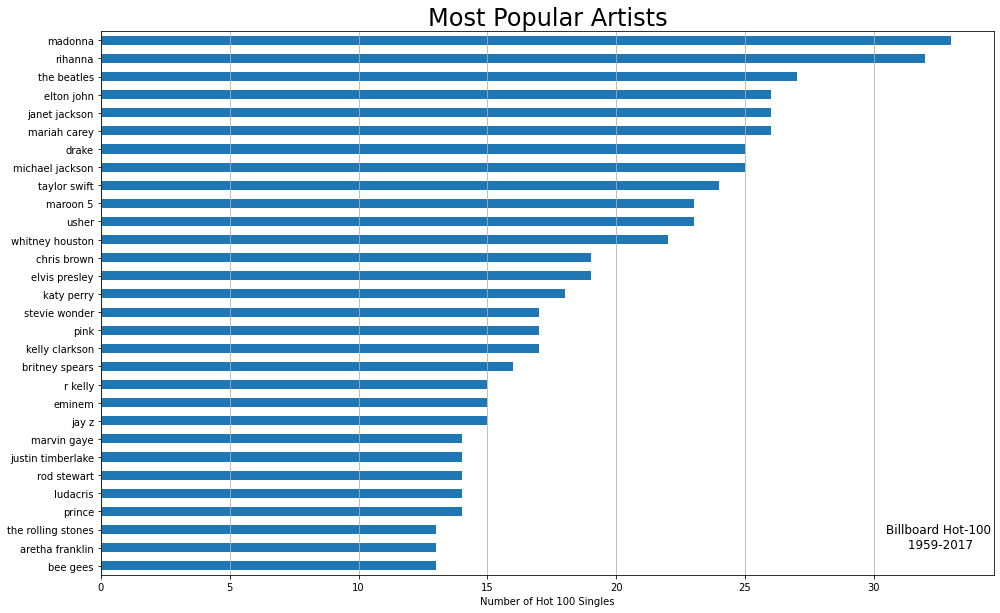

In [ ]:
ax = billboard['artist_clean'].value_counts().sort_values().tail(30)\
                       .plot.barh(figsize=(16,10))
ax.xaxis.grid(True)
ax.set(xlabel='Number of Hot 100 Singles')
ax.set_title('Most Popular Artists', fontsize=24)
ax.annotate('Billboard Hot-100\n 1959-2017', xy=(30,1),
            fontsize=12, ha='center')


As we can see from the above analysis that Madonna Tops the charts which is a great achievement along with Rihanna. 

### Checking for Artist Diversity throughout the years

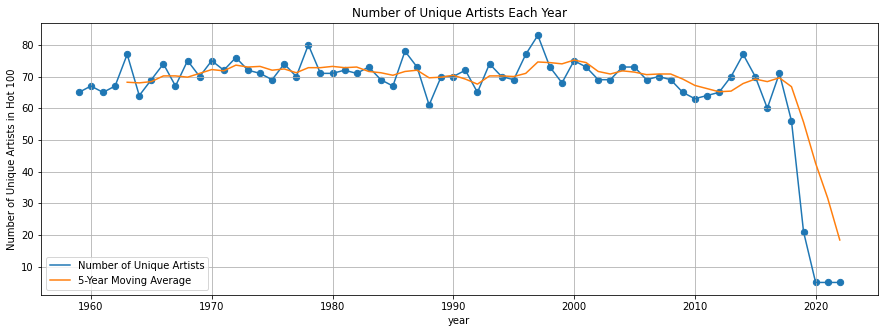

In [ ]:
# calculate number of unique artists for each year
unique_artists = billboard.groupby(['year'])['artist_clean'].agg(pd.Series.nunique)

# generate line plot and augment with points
ax = unique_artists.plot.line(figsize = (15,5), grid=True)
ax.scatter(unique_artists.index, unique_artists, s=40)
ax.set(ylabel='Number of Unique Artists in Hot 100',
       title='Number of Unique Artists Each Year')

# denoise with a 10-year moving average
unique_artists.rolling(window=5).mean().plot(grid=True, label='5-year moving average')
plt.legend(['Number of Unique Artists', '5-Year Moving Average']);

As we can see from the above trend that the number of unique artists has dropped for the years 2020-22 where a few artists are dominating the charts

### Checking as to how the Collaberation Trend has increased/decreased!

Text(1962, 1.5, 'Billboard Year Hot-100 1\n960-2017')

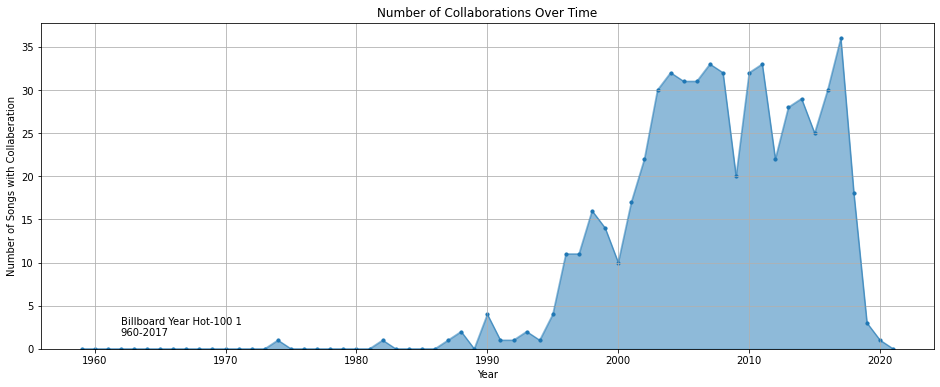

In [ ]:
# Checking for collaberation if artist_all has 'featuring' 
billboard_collab = billboard[billboard['artist_all'].str.contains('featuring')]
billboard_collab = billboard_collab.groupby(['year'])['artist_clean']\
                     .count().reindex(range(1959, 2022))
billboard_collab = billboard_collab.fillna(0)

# generate line plot and augment with points
ax = billboard_collab.plot.area(figsize=(16,6), grid=True, alpha=0.5)
ax.scatter(billboard_collab.index, billboard_collab, s=10)
ax.set(ylabel='Number of Songs with Collaberation',
       xlabel='Year',
       title='Number of Collaborations Over Time');
ax.annotate('Billboard Year Hot-100 1\n959-2022',
            xy=(1962,1.5))

We can see that from the mid-90s the number of collaberations has increased! but then again in the late 2010s it has decreased

### Word2VEC Embeddings
We now make use of W2V Embeddings to tokenize our lyrics and then do so EDA to check our most frequent words, similarity of words to other words!

In [ ]:
# Creating representation of tokens which appear more than twice
min_count = 2
lyrics = billboard['lyrics'].dropna().values.tolist()
lyrics_tokenized = [lyric.split() for lyric in lyrics]
model = Word2Vec(lyrics_tokenized, size=50, min_count=min_count, window=5)

# Creating a list based on the frequency
count = CountVectorizer(stop_words='english')
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)
mask = freqs >= min_count
indices = np.argsort(-freqs).squeeze().tolist()
freqs_filtered = freqs[indices]
words_sorted = np.array(count.get_feature_names())[indices]

In [ ]:
# print most similar words to query_words
query_words = ['you', 'love', 'heart', 'die', 'money']
similar_words = [[res[0] for res in model.wv.most_similar(qw)] \
                         for qw in query_words]
for word in query_words:
    print('|{:^15}|'.format(word), end='')
print()
print('=' * 85)
for i in range(10):
    for j in range(5):
        print('|{:^15}|'.format(similar_words[j][i]), end='')
    print()

|      you      ||     love      ||     heart     ||      die      ||     money     |
|       i       ||    loving     ||     pride     ||    survive    ||     cash      |
|      me       ||     baby      ||     arms      ||     stay      ||     shit      |
|     baby      ||    believe    ||     soul      ||      cry      ||     bank      |
|     girl      ||     true      ||     pain      ||    forever    ||    respect    |
|     just      ||     life      ||     life      ||     pray      ||      pay      |
|      it       ||      you      ||    breath     ||     live      ||     dough     |
|     babe      ||     lovin     ||     mind      ||      beg      ||     price     |
|   anything    ||     know      ||     world     ||    choose     ||     fuck      |
|     cause     ||     need      ||   strength    ||     fight     ||      job      |
|      now      ||     girl      ||     part      ||      be       ||     bitch     |


### Plotting Embeddings
We now plot the Embeddings in 2D Space via TSNE and then check the frequency of each word

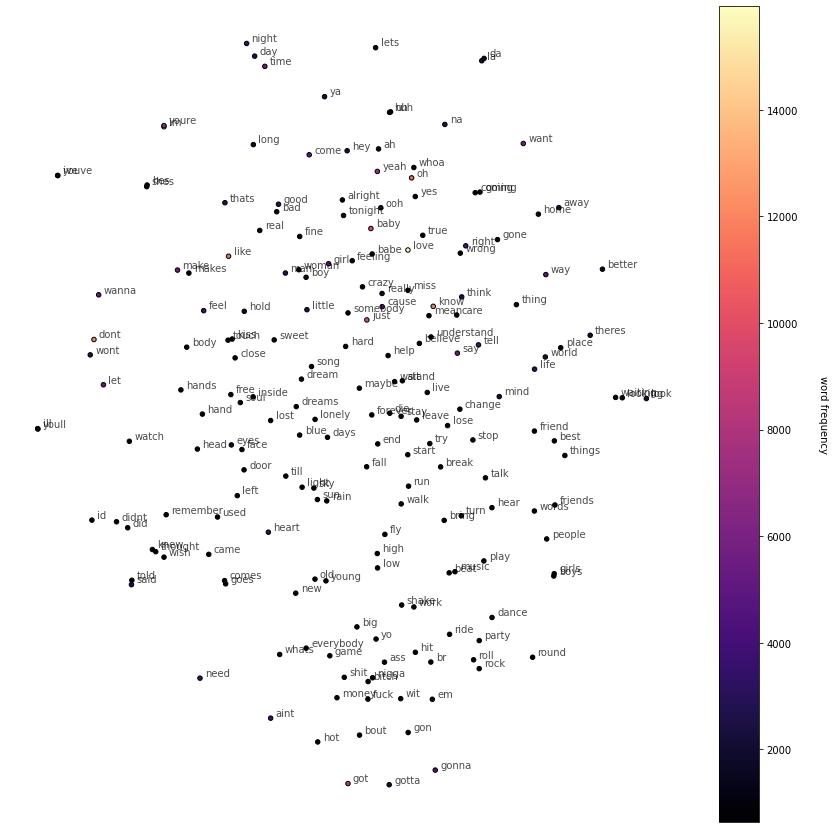

In [ ]:
# To plot the word embeddings in 2D
n_words_display = 200
X = model[words_sorted[:n_words_display]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

#Plotting Projections of the top n words
plt.figure(figsize=(15,15))
ax = plt.gca()
cb = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=20, c=freqs_filtered[:n_words_display],
                cmap='magma', edgecolor='black')
cb = plt.colorbar(cb)
cb.set_label('word frequency', rotation=270, labelpad=30)
ax.axis('off')

# annotate each point
for index, word in enumerate(words_sorted[:n_words_display]):
    xy = X_tsne[index]
    ax.annotate(word, xy=xy, xytext=(5,2), textcoords='offset points',
                 alpha=0.7)

### Create Word Map
We now use a Word Map to display the words which have high frequency

In [ ]:
# We now clear word maps where we map fontsize to it's color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

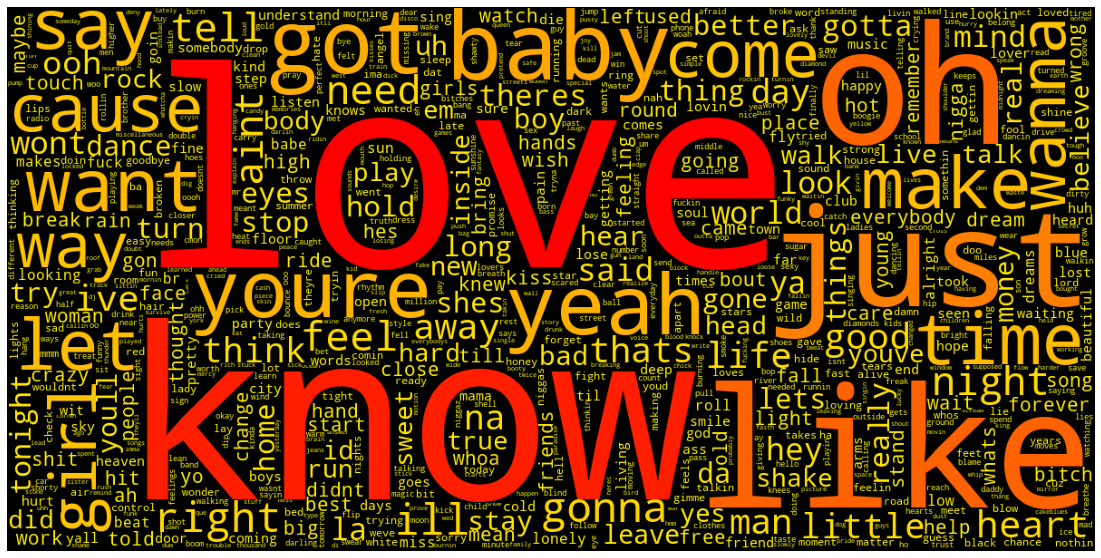

In [ ]:
# calculate word frequencies
stop_words = list(ENGLISH_STOP_WORDS)
count = CountVectorizer(stop_words=stop_words)
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count.get_feature_names(), freqs))
wordcloud = WordCloud(height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('autumn_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.imshow(wordcloud)
ax.axis('off');

##**Model - A**

In this part, we make a Baseline model, with simple LSTM, where we train on the lyrics and try to make a model that complete the lyrics by itself.

We take the cleaned dataframe that we have scrapped from Billboard above.

The data is already cleaned, and doesn't require much preprocessing, except some basic preparations that we will do in this part.

###Data Preparation

In [ ]:
df= pd.read_csv('billboard-lyrics_cleaned.csv')
df.head()

,index,rank,song,artist_base,artist_all,year,song_clean,artist_clean,lyrics,source
0,0,1,the battle of new orleans,johnny horton,johnny horton,1959,the battle of new orleans,johnny horton,the battle of new orleans johnny horton pop ch...,songlyrics.com
1,1,2,mack the knife,bobby darin,bobby darin,1959,mack the knife,bobby darin,oh the shark babe has such teeth dear and it s...,songlyrics.com
2,2,3,personality,lloyd price,lloyd price,1959,personality,lloyd price,over and over i tried to prove my love to you ...,songlyrics.com
3,3,4,venus,frankie avalon,frankie avalon,1959,venus,frankie avalon,hey venus oh venus venus if you will please se...,songlyrics.com
4,4,5,lonely boy,paul anka,paul anka,1959,lonely boy,paul anka,im just a lonely boy lonely and blue im all al...,songlyrics.com


In [ ]:
df.lyrics[0]

'the battle of new orleans johnny horton pop chart 1 apr 27 1959 columbia legacy records ck 69971 transcriber in 1814 we took a little trip along with colonel jackson down the mighty mississip we took a little bacon and we took a little beans and we caught the bloody british in a town in new orleans we fired our guns and the british kept a comin there wasnt nigh as many as there was a while ago we fired once more and they begin to runnin on down the mississippi to the gulf of mexico we looked down a river and we seed the british come and there must have been a hundred ofem beatin on the drums they stepped so high and they made their bugles ring we stood by our cotton bales and didnt say a thing we fired our guns and the british kept a comin there wasnt nigh as many as there was a while ago we fired once more and they begin to runnin on down the mississippi to the gulf of mexico old hickory said we could take em by surprise if we didnt fire our muskets till we looked em in the eye we he

In [ ]:
#converting all to string type and filtering all above 100 words
df['lyrics']= df.lyrics.astype(str)
lyrics= df.lyrics[df.lyrics.str.split(' ').apply(len).values>100]


In [ ]:
#adding start and end tokens
lyrics= '<s> '+lyrics + ' </s>'
lyrics[0]

'<s> the battle of new orleans johnny horton pop chart 1 apr 27 1959 columbia legacy records ck 69971 transcriber in 1814 we took a little trip along with colonel jackson down the mighty mississip we took a little bacon and we took a little beans and we caught the bloody british in a town in new orleans we fired our guns and the british kept a comin there wasnt nigh as many as there was a while ago we fired once more and they begin to runnin on down the mississippi to the gulf of mexico we looked down a river and we seed the british come and there must have been a hundred ofem beatin on the drums they stepped so high and they made their bugles ring we stood by our cotton bales and didnt say a thing we fired our guns and the british kept a comin there wasnt nigh as many as there was a while ago we fired once more and they begin to runnin on down the mississippi to the gulf of mexico old hickory said we could take em by surprise if we didnt fire our muskets till we looked em in the eye w

###Model with the Entire Data

Here we take the entire data that we scrapped into account and train the model. At the end we will predict on a lyrics of the artist who has maximum number of songs.

In the next model, we will train the model on the data of that specific artist and predict the same lyrics as above. We can then compare how the model behaves on limited and specific data.

In [ ]:
# Size of the vocabulary
vocab_size=8000 

# define the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,
                                                  lower=False, 
                                                  char_level=False, 
                                                  split=' ', 
                                                  oov_token=None, 
                                                  filters='')

In [ ]:
# Fit the tokenizer on text
tokenizer.fit_on_texts(lyrics)

# Convert the text to integer sequence
sequences = tokenizer.texts_to_sequences(lyrics)

print(len(sequences))

5264


In [ ]:
# declaring predictor and response variable
x_data = [i[:-1] for i in sequences]     #everything except last token
y_data = [i[1:] for i in sequences]      #everything except 1st token
print(np.shape(x_data))

(5264,)


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
# padding and converting to tensors
x_data = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_data, padding='post', maxlen=100))
y_data = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(y_data, padding='post', maxlen=100))

In [ ]:
#checking the shape
x_data.shape,y_data.shape

(TensorShape([5264, 100]), TensorShape([5264, 100]))

In [ ]:
#clear session 

tf.keras.backend.clear_session()

In [ ]:
#defining LSTM Baseline Model

hidden_size= 300
sent_input = Input(shape=x_data.shape[1:], 
                                 name='sentence_input')

embedding = Embedding(input_dim=vocab_size+1, 
                                           output_dim=hidden_size, 
                                           name='word_embedding', 
                                           mask_zero=True)

masked_embedding = embedding(sent_input)

#lstm 1
LSTM1 = LSTM(300, return_sequences=True)(masked_embedding)

#lstm 2
LSTM2 = LSTM(512, return_sequences = True)(LSTM1)

#output
output = Dense(vocab_size, activation='softmax')(LSTM2)


lstm_model = Model(inputs=sent_input, outputs=output)

lstm_model.compile(loss='sparse_categorical_crossentropy', 
              metrics = ['accuracy'], 
              optimizer=Adam(1e-2))

In [ ]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence_input (InputLayer)  [(None, 100)]            0         
                                                                 
 word_embedding (Embedding)  (None, 100, 300)          2400300   
                                                                 
 lstm (LSTM)                 (None, 100, 300)          721200    
                                                                 
 lstm_1 (LSTM)               (None, 100, 512)          1665024   
                                                                 
 dense (Dense)               (None, 100, 8000)         4104000   
                                                                 
Total params: 8,890,524
Trainable params: 8,890,524
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history  = lstm_model.fit(x_data,
                    y_data, 
                    epochs=100, 
                    batch_size=512, 
                    validation_split=0.2)

Epoch 1/100
9/9 [==============================] - 7s 798ms/step - loss: 6.4369 - accuracy: 0.0398 - val_loss: 6.6509 - val_accuracy: 0.0437
Epoch 2/100
9/9 [==============================] - 7s 817ms/step - loss: 6.3146 - accuracy: 0.0421 - val_loss: 6.5773 - val_accuracy: 0.0437
Epoch 3/100
9/9 [==============================] - 7s 834ms/step - loss: 6.2544 - accuracy: 0.0415 - val_loss: 6.5024 - val_accuracy: 0.0437
Epoch 4/100
9/9 [==============================] - 7s 828ms/step - loss: 6.2340 - accuracy: 0.0397 - val_loss: 6.4848 - val_accuracy: 0.0437
Epoch 5/100
9/9 [==============================] - 7s 814ms/step - loss: 6.2220 - accuracy: 0.0415 - val_loss: 6.3914 - val_accuracy: 0.0437
Epoch 6/100
9/9 [==============================] - 7s 804ms/step - loss: 6.1740 - accuracy: 0.0436 - val_loss: 6.3240 - val_accuracy: 0.0441
Epoch 7/100
9/9 [==============================] - 7s 794ms/step - loss: 6.0909 - accuracy: 0.0437 - val_loss: 6.2463 - val_accuracy: 0.0490
Epoch 8/100
9

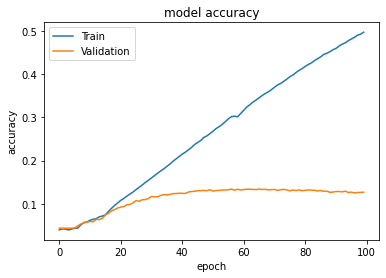

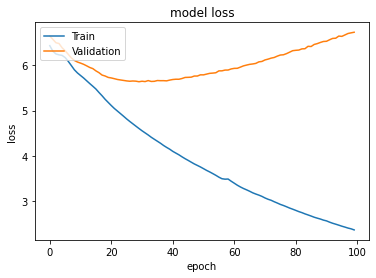

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###Model prediction

In [ ]:
#define a function to take a word as input and then generate lyrics for this.
def process_text(text:str, tokenizer):
  text = re.sub("[^a-zA-Z0-9 ]", "",text)
  text = text.strip(' ')
  text = '<s> ' + text.lower()

  tokens = tokenizer.texts_to_sequences([text])
  return tf.convert_to_tensor(tokens[0])

In [ ]:
def complete_lyrics(model, tokenizer,
                      sentence:str)->str:
  
  old_predicted = ''
  for _ in range(100):
    tokenized_sentence = process_text(sentence, tokenizer)

    #expand the tensor along the last dimension
    tokenized_sentence = tf.expand_dims(tokenized_sentence,axis=-1)

    predicted_word_idx = model(tokenized_sentence).numpy().argmax().squeeze()

    predicted_word = tokenizer.index_word[predicted_word_idx]

    sentence = sentence + ' ' + predicted_word

    if (predicted_word == ' </s>'): #or old_predicted==predicted_word):
      return sentence

    else:
      old_predicted = predicted_word

    

  return sentence 

In [ ]:
#we will select the 1st 5 words of the songs and use it to predict the rest
#for this we will select the artist with maximum number of value_counts, so that we can compare the result with the next part
artist= df.artist_clean.value_counts().index[0]
df_artist= df[df.artist_clean==artist].reset_index()
beginning= ' '.join(df_artist['lyrics'][0].split(' ')[:5])      #we will use this same sentence to predict in the next model as well in order to compare

print(f'Sentence : {beginning}\n\n\n')


pred = complete_lyrics(model = lstm_model, tokenizer=tokenizer,
                         sentence = beginning)
print(f'predicted lyrics :\n\n{pred}')

Sentence : something in the way you 


 
Predicted Lyrics:

 were too more only too more then take way give why as give around aint more by ive are night need only ive some ill thats aint will never her feel back where ill here wont here thats at ill come some think only never girl good tell man keep night ive wanna was at then around never they give think heart was give tell way good aint ive were too were day come said ooh ill girl he well at are na ooh think girl well come there at good girl are ive around


###Model with single artist

In this section we will take only one artist and train on his lyrics data and see how accurate the model could predict the lyrics as opposed to our previous model where we have trained on a mixed corpus of different artist.

In [ ]:
#we will select the artist with the maximum songs
df= pd.read_csv('/content/billboard-lyrics_cleaned.csv')

artist= df.artist_clean.value_counts().index[0]

print('The artist with maximum songs is ', artist)
df.artist_clean.value_counts()[:10]

The artist with maximum songs is  madonna


madonna            33
rihanna            32
the beatles        27
elton john         26
janet jackson      26
mariah carey       26
drake              25
michael jackson    25
taylor swift       24
usher              23
Name: artist_clean, dtype: int64

In [ ]:
#making the df of only one artist
df_artist= df[df.artist_clean==artist].reset_index()

#truncating the sequences to 1024 sequences
df_artist['lyrics']= df_artist.lyrics.astype(str)
lyrics= df_artist.lyrics[df_artist.lyrics.str.split(' ').apply(len).values>10]

#lyrics = lyrics.apply(lambda x:x[:1000])

#adding start and end tokens
lyrics= '<s> '+lyrics + ' </s>'
lyrics[0]

'<s> something in the way you love me wont let me be i dont want to be your prisoner so baby wont you set me free stop playing with my heart finish what you start when you make my love come down if you want me let me know baby let it show honey dont you fool around just try to understand ive given all i can cause you got the best of me borderline feels like im going to lose my mind you just keep on pushing my love over the borderline borderline feels like im going to lose my mind you just keep on pushing my love over the borderline borderline keep on pushing me baby dont you know you drive me crazy you just keep on pushing my love over the borderline something in your eyes is makin such a fool of me when you hold me in your arms you love me till i just cant see but then you let me down when i look around baby you just cant be found stop driving me away i just wanna stay theres something i just got to say just try to understand ive given all i can cause you got the best of me borderline

In [ ]:
# Size of the vocabulary
vocab_size=2000 

# define the tokenizer
tokenizer_a = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,
                                                  lower=False, 
                                                  char_level=False, 
                                                  split=' ', 
                                                  oov_token=None, 
                                                  filters='')

In [ ]:
# Fit the tokenizer on text
tokenizer_a.fit_on_texts(lyrics)

# Convert the text to integer sequence
sequences = tokenizer_a.texts_to_sequences(lyrics)

print(len(sequences))

33


In [ ]:
# declaring predictor and response variable
x_data = [i[:-1] for i in sequences]     #everything except last token
y_data = [i[1:] for i in sequences]      #everything except 1st token
print(np.shape(x_data))

(33,)


In [ ]:
# padding and converting to tensors
x_data = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_data, padding='post', maxlen=100))
y_data = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(y_data, padding='post', maxlen=100))

In [ ]:
#checking the shape
x_data.shape,y_data.shape

(TensorShape([33, 100]), TensorShape([33, 100]))

In [ ]:
#clear session 

tf.keras.backend.clear_session()

In [ ]:
#defining LSTM Baseline Model

hidden_size= 300
sent_input = Input(shape=x_data.shape[1:], 
                                 name='sentence_input')

embedding = Embedding(input_dim=vocab_size+1, 
                                           output_dim=hidden_size, 
                                           name='word_embedding', 
                                           mask_zero=True)

masked_embedding = embedding(sent_input)

#lstm 1
LSTM1 = LSTM(300, return_sequences=True)(masked_embedding)

#lstm 2
LSTM2 = tf.keras.layers.LSTM(512, return_sequences = True)(LSTM1)

#output
output = tf.keras.layers.Dense(vocab_size,
                               activation='softmax')(LSTM2)


artist_model = tf.keras.models.Model(inputs=sent_input, outputs=output)

artist_model.compile(loss='sparse_categorical_crossentropy', 
              metrics = ['accuracy'], 
              optimizer=Adam(1e-2))

In [ ]:
artist_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence_input (InputLayer)  [(None, 100)]            0         
                                                                 
 word_embedding (Embedding)  (None, 100, 300)          600300    
                                                                 
 lstm (LSTM)                 (None, 100, 300)          721200    
                                                                 
 lstm_1 (LSTM)               (None, 100, 512)          1665024   
                                                                 
 dense (Dense)               (None, 100, 2000)         1026000   
                                                                 
Total params: 4,012,524
Trainable params: 4,012,524
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history  = artist_model.fit(x_data,
                    y_data, 
                    epochs=100, 
                    batch_size=512, 
                    validation_split=0.2)

Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 7.6011 - accuracy: 0.0000e+00 - val_loss: 7.5739 - val_accuracy: 0.0514
Epoch 2/100
1/1 [==============================] - 0s 92ms/step - loss: 7.5505 - accuracy: 0.0788 - val_loss: 6.5606 - val_accuracy: 0.0300
Epoch 3/100
1/1 [==============================] - 0s 97ms/step - loss: 6.0660 - accuracy: 0.0188 - val_loss: 7.7139 - val_accuracy: 0.0200
Epoch 4/100
1/1 [==============================] - 0s 91ms/step - loss: 5.7584 - accuracy: 0.0273 - val_loss: 8.5824 - val_accuracy: 0.0529
Epoch 5/100
1/1 [==============================] - 0s 78ms/step - loss: 5.9970 - accuracy: 0.0373 - val_loss: 9.0462 - val_accuracy: 0.0157
Epoch 6/100
1/1 [==============================] - 0s 77ms/step - loss: 5.8622 - accuracy: 0.0242 - val_loss: 9.2033 - val_accuracy: 0.0257
Epoch 7/100
1/1 [==============================] - 0s 71ms/step - loss: 5.6653 - accuracy: 0.0235 - val_loss: 9.4884 - val_accuracy: 0.0243
Epoch 8/100
1/1 [=

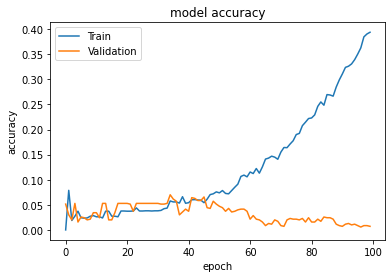

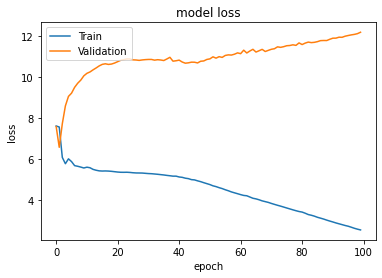

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#we will now predict the model on one artist, on the same sentence predicted above

print(f'Sentence : {beginning}\n\n\n')


pred = complete_lyrics(model = artist_model, tokenizer=tokenizer_a,
                         sentence = beginning)
print(f'predicted lyrics : \n{beginning+pred}')

Sentence : something in the way you 


 
Predicted Lyrics:

something in the way you night come come are tell aint will her have was have right heart well right wanna gonna were right wanna gonna were from feel are were heart take were right back will from have at girl they her her take well were they not girl well not tell they way right night night they gonna right are he girl were juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices juices 


###Model A inferences:

The model was a simple LSTM model, and trained on a larger dataset. The Embedding used was keras embedding, and is not pretrained on a large variety of data. This model was expected to perform with lesser accuracy and context.

When comparing the two cases, where in the 1st model we trained on a larger corpus of data, and then an artist specific data, we could see that the model trained on the larger corpus performs better (accuracy of 50%). The accuracy of artist specific model is lesser (accuracy of 39%).

This Model is only an attempt to show how importatnt the context embeddings are in a model. The lacunas of this model can be overcome by making a State of the Art (SOTA) model, that we are gonna exhibit in the next part.

##**SOTA Model**

### Loading dataset

In [ ]:
#connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the file into a dataframe
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/billboard-lyrics_cleaned.csv")
#display first 5 rows of the df
df.head()

,index,rank,song,artist_base,artist_all,year,song_clean,artist_clean,lyrics,source
0,0,1,the battle of new orleans,johnny horton,johnny horton,1959,the battle of new orleans,johnny horton,the battle of new orleans johnny horton pop ch...,songlyrics.com
1,1,2,mack the knife,bobby darin,bobby darin,1959,mack the knife,bobby darin,oh the shark babe has such teeth dear and it s...,songlyrics.com
2,2,3,personality,lloyd price,lloyd price,1959,personality,lloyd price,over and over i tried to prove my love to you ...,songlyrics.com
3,3,4,venus,frankie avalon,frankie avalon,1959,venus,frankie avalon,hey venus oh venus venus if you will please se...,songlyrics.com
4,4,5,lonely boy,paul anka,paul anka,1959,lonely boy,paul anka,im just a lonely boy lonely and blue im all al...,songlyrics.com


In [ ]:
#looking for null values
display(df.isna().sum())
#dropping null values
df.dropna(inplace=True)

index           0
rank            0
song            0
artist_base     0
artist_all      0
year            0
song_clean      0
artist_clean    0
lyrics          1
source          0
dtype: int64

In [ ]:
print(f"Shape of the df is {df.shape}")

Shape of the df is (5400, 10)


In [ ]:
#taking only those lyrics with atleast 100 characters
#making a new df with only the lyrics
#converting the dtype of the lyrics column to str
lyrics =  df[["lyrics"]][df.lyrics.apply(len)>100].astype(str)

In [ ]:
#looking at the first 5 rows of the lyrics df
lyrics.head()

,lyrics
0,the battle of new orleans johnny horton pop ch...
1,oh the shark babe has such teeth dear and it s...
2,over and over i tried to prove my love to you ...
3,hey venus oh venus venus if you will please se...
4,im just a lonely boy lonely and blue im all al...


### Fine tuning the model on the whole dataset





#### Loading the pretrained model and tokenizer

In [ ]:
#importing the tokenizer and model 
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

#intializing the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

#### Organizing the train data

In [ ]:
#making a dataset of lyrics
dataset = []
#setting max_length as 1024 of gpt2
max_length = 1024
#tokenizing the end of text token 
end_token = tokenizer.encode("<|endoftext|>")

#tokenizing the lyric and adding the end of text token
for row in lyrics['lyrics']:
  #append the lyrics to the dataset
  dataset.append(torch.tensor(tokenizer.encode(row)[:max_length - 1] + end_token))


Token indices sequence length is longer than the specified maximum sequence length for this model (1177 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
#to prevent the kernel from crashing , using accumulation of gradients
#https://towardsdatascience.com/how-to-fine-tune-gpt-2-for-text-generation-ae2ea53bc272

#code for accumulating the gradients
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
  if packed_tensor is None:
    return new_tensor, True, None
  if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
    return packed_tensor, False, new_tensor
  else:
    packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
    return packed_tensor, True, None




#### Training the model 

In [ ]:
#setting the hyperparameters

#batch size
batch_size=16

#epochs
epochs=5

#learning rate
lr=2e-5

#max sequence length
max_seq_len=1024

#number of warmup steps
warmup_steps=200

#type of model used
gpt2_type="gpt2" 

#output directory as current
output_dir="." 

#test_mode
test_mode=False

#save model after every epoch
save_model_on_epoch=False

#accumulation steps
acc_steps = 100

#setting the device as cuda
device=torch.device("cuda")
model = model.cuda()
model.train()

#setting the optimizer as AdamW
optimizer = AdamW(model.parameters(), lr=lr)

#setting a scheduler with warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=-1
    )

#creating a Dataloader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

#intializing some variables
loss=0
accumulating_batch_count = 0
input_tensor = None

#training the model
for epoch in range(epochs):

    print(f"Training epoch {epoch}")
    for idx, entry in tqdm(enumerate(dataloader)):
        (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

        if carry_on and idx != len(dataloader) - 1:
            continue

        input_tensor = input_tensor.to(device)
        outputs = model(input_tensor, labels=input_tensor)
        loss = outputs[0]
        loss.backward()

        if (accumulating_batch_count % batch_size) == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            model.zero_grad()

        accumulating_batch_count += 1
        input_tensor = None



Training epoch 0


5370it [05:30, 16.27it/s]


Training epoch 1


5370it [05:31, 16.19it/s]


Training epoch 2


5370it [05:29, 16.29it/s]


Training epoch 3


5370it [05:28, 16.37it/s]


Training epoch 4


5370it [05:32, 16.14it/s]


#### Generating lyrics

In [ ]:
#generating predictions

#prompt
prompt = "I'm just a lonely boy, Lonely and blue, I'm all alone, With nothinn to do"

#intializing other hyperparmeters
entry_count=2
entry_length=100 #maximum number of words

#filtering the word probabilities
top_p=0.8

#creativity of the model
temperature=1

#how many outputs to generate
generated_num = 0
generated_list = []
filter_value = -float("Inf")


 
#running the model on cpu
model.to('cpu').eval()

with torch.no_grad():


  for entry_idx in trange(entry_count):

      entry = False
      generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

      for i in range(entry_length):
          outputs = model(generated, labels=generated)
          loss, logits = outputs[:2]
          logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

          sorted_logits, sorted_indices = torch.sort(logits, descending=True)
          cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

          sorted_indices_to_remove = cumulative_probs > top_p
          sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
              ..., :-1
          ].clone()
          sorted_indices_to_remove[..., 0] = 0

          indices_to_remove = sorted_indices[sorted_indices_to_remove]
          logits[:, indices_to_remove] = filter_value

          next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
          generated = torch.cat((generated, next_token), dim=1)

          if next_token in tokenizer.encode("<|endoftext|>"):
              entry = True

          if entry:

              generated_num = generated_num + 1

              output_list = list(generated.squeeze().numpy())
              output_text = tokenizer.decode(output_list)
              generated_list.append(output_text)
              break
      
      if not entry:
        output_list = list(generated.squeeze().numpy())
        output_text = f"{tokenizer.decode(output_list)}<|endoftext|>" 
        generated_list.append(output_text)
            



100%|██████████| 2/2 [00:41<00:00, 20.86s/it]


In [ ]:
def display_lyrics(lyric):
  lyric = lyric.split(" ")
  max_subseq = max(list(map(len,[i.split(" ") for i in prompt.split(",")]))) *2
  for i in range(len(lyric)//max_subseq + 1):
    print(" ".join(lyric[:max_subseq+1]) + "\n")
    lyric = lyric[max_subseq+1:]




In [ ]:
#displaying the generated lyrics
print(f"Prompt : {prompt}")
for i in range(len(generated_list)):
  print()
  print(f"Generated Lyric {i+1} ")
  print()
  display_lyrics(generated_list[i])
  print()


Prompt : I'm just a lonely boy, Lonely and blue, I'm all alone, With nothinn to do

Generated Lyric 1 

I'm just a lonely boy, Lonely and blue, I'm all alone,

With nothinn to do and a little rain to make me

get back home. In vain love in vain tender words she

sings and singes of all the colors in the sky she

brings all you never knew o oh she dances around on

the rock on the way home where dreams are made she

sings and sings on the hill singing some verses but never

much a girl would do it for me oh oh o

oh she sings a few words and sings on the hill

singing some verses but never much a girl would do it

for me oh<|endoftext|>





Generated Lyric 2 

I'm just a lonely boy, Lonely and blue, I'm all alone,

With nothinn to do anything for you and your love with

no man to worry over and no man to blame.<|endoftext|>






###Fine tuning 2 separate models with different artists lyrics

We now use the lyrics of 2 different artists and do the fine tuning separately and compare the generated lyrics. The 2 artists we have taken are : Panic at the disco and Bruno Mars

#### Loading the datasets

In [ ]:
bm_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bm-lyrics_cleaned.csv')
panic_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/patd-lyrics_cleaned.csv')

In [ ]:
print(f"Shape of bm_df : {bm_df.shape}")
bm_df.head()

Shape of bm_df : (33, 1)


,lyrics
0,tonight i just want to take you higher throw y...
1,she got to shake her little something throwing...
2,now look at you been walking in here looking a...
3,i got a condo in manhattan baby girl whats hat...
4,lets take our time tonight girl above us all t...


In [ ]:
print(f"Shape of bm_df : {panic_df.shape}")
panic_df.head()

Shape of bm_df : (67, 1)


,lyrics
0,fuck a silver lining fuck a silver lining caus...
1,all my life been hustling and tonight is my ap...
2,had to have high high hopes for a living shoot...
3,broadway is black like a sinkhole everyone rac...
4,im a moon walker im like mj up in the clouds i...


In [ ]:
#looking for null values
display(bm_df.isna().sum())
display(panic_df.isna().sum())


lyrics    0
dtype: int64

lyrics    0
dtype: int64

In [ ]:
#taking only those lyrics with atleast 100 characters
#making a new df with only the lyrics
#converting the dtype of the lyrics column to str
bm_lyrics =  bm_df[["lyrics"]][bm_df.lyrics.apply(len)>100].astype(str)
panic_lyrics =  panic_df[["lyrics"]][panic_df.lyrics.apply(len)>100].astype(str)


#### Loading the pretrained model and tokenizer

In [ ]:

#intializing the tokenizer and model
tokenizer_bm = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_panic= GPT2Tokenizer.from_pretrained('gpt2')

model_bm = GPT2LMHeadModel.from_pretrained('gpt2')
model_panic = GPT2LMHeadModel.from_pretrained('gpt2')

#### Organizing the train data

In [ ]:
#making datasets of lyrics
dataset_bm = []
dataset_panic = []
#setting max_length as 1024 of gpt2
max_length = 1024
#tokenizing the end of text token 
end_token_bm = tokenizer_bm.encode("<|endoftext|>")
end_token_panic = tokenizer_panic.encode("<|endoftext|>")

#tokenizing the lyric and adding the end of text token
for row in bm_lyrics['lyrics']:
  #append the lyrics to the dataset
  dataset_bm.append(torch.tensor(tokenizer.encode(row)[:max_length - 1] + end_token_bm))

for row in panic_lyrics['lyrics']:
  #append the lyrics to the dataset
  dataset_panic.append(torch.tensor(tokenizer.encode(row)[:max_length - 1] + end_token_panic))


#### Training the model 

#### Setting the hyperparameters

In [ ]:
#setting the hyperparameters

#batch size
batch_size=16

#epochs
epochs=5

#learning rate
lr=2e-5

#max sequence length
max_seq_len=1024

#number of warmup steps
warmup_steps=200

#type of model used
gpt2_type="gpt2" 

#output directory as current
output_dir="." 

#test_mode
test_mode=False

#save model after every epoch
save_model_on_epoch=False

#accumulation steps
acc_steps = 100

#setting the device as cuda
device=torch.device("cuda")
model_bm = model_bm.cuda()
model_bm.train()
model_panic = model_panic.cuda()
model_panic.train()

#setting the optimizers as AdamW
optimizer_bm = AdamW(model_bm.parameters(), lr=lr)
optimizer_panic = AdamW(model_panic.parameters(), lr=lr)


#setting schedulers with warmup steps
scheduler_bm = get_linear_schedule_with_warmup(optimizer_bm,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=-1
    )
scheduler_panic = get_linear_schedule_with_warmup(optimizer_panic,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=-1
    )

#creating Dataloaders
dataloader_bm = DataLoader(dataset_bm, batch_size=1, shuffle=True)
dataloader_panic = DataLoader(dataset_panic, batch_size=1, shuffle=True)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training the Bruno Mars model

In [ ]:
#intializing some variables
loss_bm=0
accumulating_batch_count = 0
input_tensor = None

#training the model
for epoch in range(epochs):

    print(f"Training epoch {epoch}")
    for idx, entry in tqdm(enumerate(dataloader_bm)):
        (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

        if carry_on and idx != len(dataloader_bm) - 1:
            continue

        input_tensor = input_tensor.to(device)
        outputs = model_bm(input_tensor, labels=input_tensor)
        loss_bm = outputs[0]
        loss_bm.backward()

        if (accumulating_batch_count % batch_size) == 0:
            optimizer_bm.step()
            scheduler_bm.step()
            optimizer_bm.zero_grad()
            model_bm.zero_grad()

        accumulating_batch_count += 1
        input_tensor = None



Training epoch 0


33it [00:02, 15.30it/s]


Training epoch 1


33it [00:02, 15.06it/s]


Training epoch 2


33it [00:02, 15.11it/s]


Training epoch 3


33it [00:02, 14.38it/s]


Training epoch 4


33it [00:02, 14.89it/s]


#### Training the Panic at the disco model

In [ ]:
#intializing some variables
loss_panic=0
accumulating_batch_count = 0
input_tensor = None

#training the model
for epoch in range(epochs):

    print(f"Training epoch {epoch}")
    for idx, entry in tqdm(enumerate(dataloader_panic)):
        (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

        if carry_on and idx != len(dataloader_panic) - 1:
            continue

        input_tensor = input_tensor.to(device)
        outputs = model_panic(input_tensor, labels=input_tensor)
        loss_panic = outputs[0]
        loss_panic.backward()

        if (accumulating_batch_count % batch_size) == 0:
            optimizer_panic.step()
            scheduler_panic.step()
            optimizer_panic.zero_grad()
            model_panic.zero_grad()

        accumulating_batch_count += 1
        input_tensor = None



Training epoch 0


66it [00:03, 16.86it/s]


Training epoch 1


66it [00:03, 17.38it/s]


Training epoch 2


66it [00:03, 17.85it/s]


Training epoch 3


66it [00:03, 17.45it/s]


Training epoch 4


66it [00:03, 17.76it/s]


#### Generating lyrics

In [ ]:
#generating lyrics

#prompt
prompt = "Tonight, I just want to take you higher , Throw your hands up in the sky , Let's set this party off right"

#intializing other hyperparmeters
entry_count=1
entry_length=100 #maximum number of words

#filtering the word probabilities
top_p=0.8

#creativity of the model
temperature=1


#### Generating lyrics using model_panic

In [ ]:
#for model_panic
#how many outputs to generate
generated_num = 0
generated_list = []
filter_value = -float("Inf")


 
#running the model on cpu
model_panic.to('cpu').eval()

with torch.no_grad():


  for entry_idx in trange(entry_count):

      entry = False
      generated = torch.tensor(tokenizer_panic.encode(prompt)).unsqueeze(0)

      for i in range(entry_length):
          outputs = model_panic(generated, labels=generated)
          loss, logits = outputs[:2]
          logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

          sorted_logits, sorted_indices = torch.sort(logits, descending=True)
          cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

          sorted_indices_to_remove = cumulative_probs > top_p
          sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
              ..., :-1
          ].clone()
          sorted_indices_to_remove[..., 0] = 0

          indices_to_remove = sorted_indices[sorted_indices_to_remove]
          logits[:, indices_to_remove] = filter_value

          next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
          generated = torch.cat((generated, next_token), dim=1)

          if next_token in tokenizer.encode("<|endoftext|>"):
              entry = True

          if entry:

              generated_num = generated_num + 1

              output_list = list(generated.squeeze().numpy())
              output_text = tokenizer.decode(output_list)
              generated_list.append(output_text)
              break
      
      if not entry:
        output_list = list(generated.squeeze().numpy())
        output_text = f"{tokenizer.decode(output_list)}<|endoftext|>" 
        generated_list.append(output_text)
            
panic_output = generated_list


100%|██████████| 1/1 [00:42<00:00, 42.90s/it]


#### Generating lyrics using model_bm

In [ ]:
temperature=0.85
top_p = 0.65
#for model_bm
#how many outputs to generate
generated_num = 0
generated_list = []
filter_value = -float("Inf")


 
#running the model on cpu
model_bm.to('cpu').eval()

with torch.no_grad():


  for entry_idx in trange(entry_count):

      entry = False
      generated = torch.tensor(tokenizer_bm.encode(prompt)).unsqueeze(0)

      for i in range(entry_length):
          outputs = model_bm(generated, labels=generated)
          loss, logits = outputs[:2]
          logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

          sorted_logits, sorted_indices = torch.sort(logits, descending=True)
          cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

          sorted_indices_to_remove = cumulative_probs > top_p
          sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
              ..., :-1
          ].clone()
          sorted_indices_to_remove[..., 0] = 0

          indices_to_remove = sorted_indices[sorted_indices_to_remove]
          logits[:, indices_to_remove] = filter_value

          next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
          generated = torch.cat((generated, next_token), dim=1)

          if next_token in tokenizer.encode("<|endoftext|>"):
              entry = True

          if entry:

              generated_num = generated_num + 1

              output_list = list(generated.squeeze().numpy())
              output_text = tokenizer.decode(output_list)
              generated_list.append(output_text)
              break
      
      if not entry:
        output_list = list(generated.squeeze().numpy())
        output_text = f"{tokenizer.decode(output_list)}<|endoftext|>" 
        generated_list.append(output_text)
            
bm_output = generated_list


100%|██████████| 1/1 [00:40<00:00, 40.99s/it]


In [ ]:
def display_lyrics(lyric):
  lyric = lyric.split(" ")
  max_subseq = max(list(map(len,[i.split(" ") for i in prompt.split(",")]))) *2
  for i in range(len(lyric)//max_subseq + 1):
    print(" ".join(lyric[:max_subseq+1]) + "\n")
    lyric = lyric[max_subseq+1:]




#### Displaying the generated lyrics

In [ ]:
#displaying the generated lyrics
print(f"Prompt : {prompt}")
for i in range(len(panic_output)):
  print()
  print(f"Generated Lyric {i+1} ")
  print()
  display_lyrics(panic_output[i])
  print()


Prompt : Tonight, I just want to take you higher , Throw your hands up in the sky , Let's set this party off right

Generated Lyric 1 

Tonight, I just want to take you higher, Throw your hands up in the sky, Let's set this party

off right over there! Yes, I think we've got it. I think we've got it. I think we've got

it. Now that we've got it, I'm gonna have you grow and move, keep your head down and move

and turn and move and turn and move and turn and move and turn and turn and move and

turn and turn and move and turn and move to the sky. No, don't stop moving, I can't hear

you and the wind is ripping your hair off<|endoftext|>




In [ ]:
#displaying the generated lyrics
print(f"Prompt : {prompt}")
for i in range(len(bm_output)):
  print()
  print(f"Generated Lyric {i+1} ")
  print()
  display_lyrics(bm_output[i])
  print()


Prompt : Tonight, I just want to take you higher , Throw your hands up in the sky , Let's set this party off right

Generated Lyric 1 

Tonight, I just want to take you higher, Throw your hands up in the sky, Let's set this party

off right here on Earth.

I know you're not going to believe it, but the sun is always setting right

here in the sky.

It's always setting right here in the sky.

I know you're not going to believe it, but

the sun is always setting right here in the sky.

I know you're not going to believe it, but the

sun is always setting right here in the sky.

It's always setting right here in the sky.<|endoftext|>






##**Conclusion**

We started the Project by scrapping the data from Billboard. The necessary preprocessing are done on the data and then did the Exploratory Data Analysis on the data.

The data was then ready for modelling.

In Model A, the accuracy was quite low as expected. It was due to the simple Model tasked for higher order task. We used the keras embedding layer to learn the embedding its own and without any pretrained weights. This caused the model to lack context. Also the accuracy was quite low. As we can see from the generated lyrics, the lyrics doesn't hold any artistic brilliance!
However this model was expected only to demonstrate the shortcoming of simple LSTM model and the importance of better word embedding.

All these lacunas were overcome by the State of the Art Model (GPT2). We refered few of the online resources to learn its implementation. The primary challenge was its implementation in the online sources were made using PyTorch. None the less, the final outcome was better and we could get fairly better generation of lyrics from the given beginning sentence. 

The project was a great learning opportunity to deal with sequential data, use the State of the Art models, fine tune it to our specific needs, use Hugging face models, get familiar with using ML tools in a better way, better handling of large sized data in a memory efficient way and to get the outcome as desired. 


Finally to conclude, music always bring color to our life. Hence this Project was a great and curious learning experience!

##**References**

https://www.activestate.com/blog/how-to-build-a-lyrics-generator-with-python-recurrent-neural-networks/


https://medium.com/analytics-vidhya/how-to-scrape-song-lyrics-a-gentle-python-tutorial-5b1d4ab351d2


https://github.com/shaariqch/Music-Lyrics-Analysis


https://aclanthology.org/D15-1221.pdf


https://towardsdatascience.com/how-to-fine-tune-gpt-2-for-text-generation-ae2ea53bc272


https://huggingface.co/docs/transformers/index



Home Work- 1 Solution
